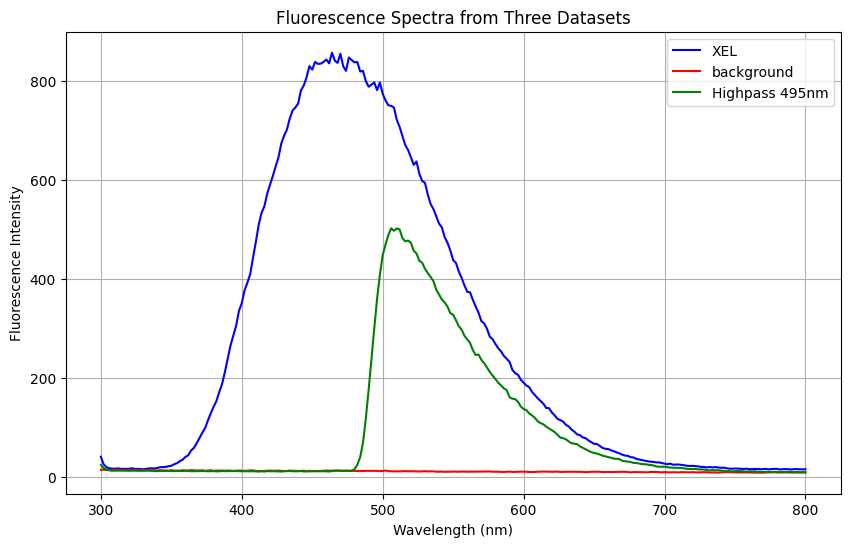

In [1]:
import matplotlib.pyplot as plt

def read_data(file_path):
    wavelengths = []
    fluorescence = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Find the "Data Points" section and start reading the data
        start_reading = False
        for line in lines:
            line = line.strip()

            # Skip header lines until you reach the data section
            if line.startswith("Data Points"):
                start_reading = True
                continue

            if start_reading:
                # Split the line into parts (assuming they are separated by spaces or tabs)
                parts = line.split()

                # Check if the line has two parts (wavelength and fluorescence value)
                if len(parts) == 2:
                    try:
                        # Convert to float, assuming the data format is correct
                        wavelength = float(parts[0])  # First part: wavelength (nm)
                        intensity = float(parts[1])   # Second part: intensity

                        wavelengths.append(wavelength)
                        fluorescence.append(intensity)
                    except ValueError:
                        # Skip lines where the data cannot be converted to float
                        continue

    return wavelengths, fluorescence


def plot_data(wavelengths1, fluorescence1, wavelengths2, fluorescence2, wavelengths3, fluorescence3):
    plt.figure(figsize=(10, 6))

    # Plot the first dataset
    plt.plot(wavelengths1, fluorescence1, label='XEL', color='b')
    
    # Plot the second dataset
    plt.plot(wavelengths2, fluorescence2, label='background', color='r')
    
    # Plot the third dataset
    plt.plot(wavelengths3, fluorescence3, label='Highpass 495nm', color='g')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Fluorescence Intensity')
    plt.title('Fluorescence Spectra from Three Datasets')
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage
file_path_1 = 'b-bgo-12_xel_1.TXT'  # Replace with the first file path
file_path_2 = 'b-bgo-12_xel_1_bg.TXT'  # Replace with the second file path
file_path_3 = 'b-bgo-12_xel_1_hp.TXT'  # Replace with the third file path

# Read the data from the three files
wavelengths1, fluorescence1 = read_data(file_path_1)
wavelengths2, fluorescence2 = read_data(file_path_2)
wavelengths3, fluorescence3 = read_data(file_path_3)

# Plot the data
plot_data(wavelengths1, fluorescence1, wavelengths2, fluorescence2, wavelengths3, fluorescence3)


/var/folders/np/1nk6dbzn3dn79swcw81d2rkm0000gn/T/ipykernel_4973/3477487958.py:12: RuntimeWarning: invalid value encountered in power
  A * (n / np.abs(alpha))**n * np.exp(-0.5 * alpha**2) * (n / np.abs(alpha) - np.abs(alpha) - z) ** (-n)
/var/folders/np/1nk6dbzn3dn79swcw81d2rkm0000gn/T/ipykernel_4973/3477487958.py:130: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(crystal_ball,wavelengths1,normalized_fluorescence, p0=[1, 0, 1, 1.5, 2])


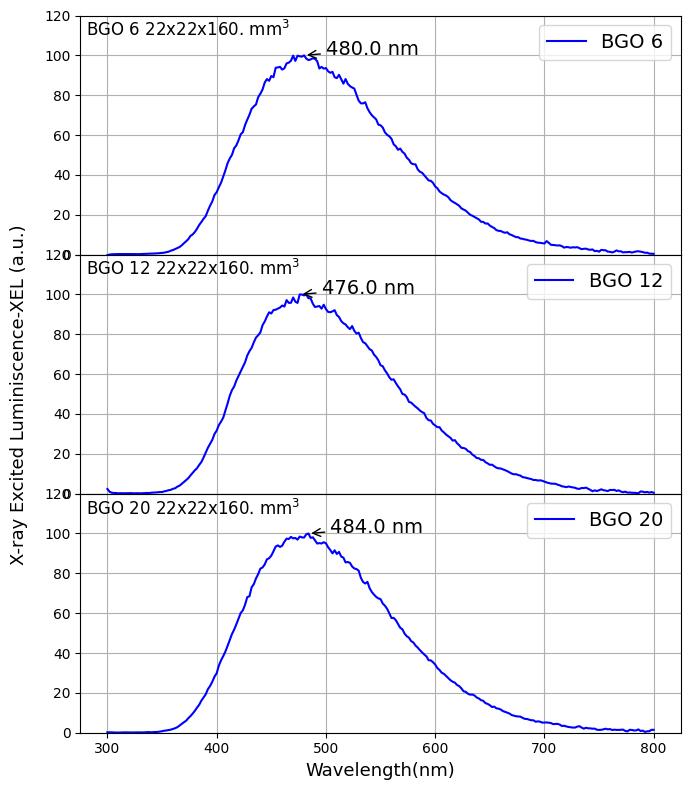

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp
from scipy.optimize import curve_fit

def crystal_ball(x, A, mean, sigma, alpha, n):
    z = (x - mean) / sigma
    # Apply np.where to handle the array case correctly
    result = np.where(
        z > -alpha,
        A * np.exp(-0.5 * z**2),
        A * (n / np.abs(alpha))**n * np.exp(-0.5 * alpha**2) * (n / np.abs(alpha) - np.abs(alpha) - z) ** (-n)
    )
    return result



def read_data(file_path):
    """Reads the data from a given file."""
    wavelengths = []
    fluorescence = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        start_reading = False

        for line in lines:
            line = line.strip()

            # Start reading data after the "Data Points" header
            if line.startswith("Data Points"):
                start_reading = True
                continue

            if start_reading:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        wavelength = float(parts[0])
                        intensity = float(parts[1])
                        wavelengths.append(wavelength)
                        fluorescence.append(intensity)
                    except ValueError:
                        continue  # Ignore lines that can't be converted to float
    return wavelengths, fluorescence

def process_fluorescence(wavelengths1, fluorescence1, wavelengths2, fluorescence2, wavelengths3, fluorescence3, calib):
    """Process the fluorescence data based on given rules and normalize it."""
    adjusted_fluorescence = []
    for i in range(len(wavelengths1)):
        if wavelengths1[i] <= 700:
            adjusted_value = (fluorescence1[i] - fluorescence2[i]) / calib[i]
        else:
            adjusted_value = (fluorescence3[i] - fluorescence2[i])*(fluorescence1[200] - fluorescence2[200])/ ((fluorescence3[200] - fluorescence2[200])*calib[i])
        adjusted_fluorescence.append(adjusted_value)
    
    # Normalize the fluorescence values
    max_value = max(adjusted_fluorescence)
    normalized_fluorescence = [val*100/ max_value for val in adjusted_fluorescence]
    
    return normalized_fluorescence

def plot_data(ax, wavelengths, normalized_fluorescence, label, ylabel):
    """Plots the fluorescence data and annotates the peak."""
    ax.plot(wavelengths, normalized_fluorescence, label=label, color='b')

    # Find the peak value and its position
    peak_value = max(normalized_fluorescence)
    peak_wavelength = wavelengths[normalized_fluorescence.index(peak_value)]

    #Annotate peak with a larger font size
    ax.annotate(f"{peak_wavelength} nm", 
                xy=(peak_wavelength, peak_value), 
                xytext=(peak_wavelength+20, peak_value+0.1),
                arrowprops=dict(facecolor='black', arrowstyle="->"),
                fontsize=14)  # Increased font size for peak annotation
    #ax.plot(wavelengths, crystal_ball(wavelengths, *data[key]['popt']), 'r', label=f"(Peak={popt[1]:.2f})")
    ax.grid(True)
    ax.legend(fontsize = 14)
    #ax.set_ylabel(ylabel)
    ax.set_ylim(0,120)
    # Add label at the top left for each plot
    ax.text(0.01, 0.98, f'{label} 22x22x160. mm$^3$', transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')

# File paths for the three sets of files (corresponding to BGO 1, 7, and 14)
file_paths = {
    6: {'file1': 'b-bgo-6_xel_1.TXT', 'file2': 'b-bgo-6_xel_1_bg.TXT', 'file3': 'b-bgo-6_xel_1_hp.TXT'},
    12: {'file1': 'b-bgo-12_xel_1.TXT', 'file2': 'b-bgo-12_xel_1_bg.TXT', 'file3': 'b-bgo-12_xel_1_hp.TXT'},
    20: {'file1': 'b-bgo-20_xel_1.TXT', 'file2': 'b-bgo-20_xel_1_bg.TXT', 'file3': 'b-bgo-20_xel_1_hp.TXT'}
}

# Example calibration data
calib = [
    1.0399, 1.0546, 1.0630, 1.0623, 1.0577, 1.0573, 1.0633, 1.0732, 1.0879, 1.1023, 
    1.1138, 1.1315, 1.1398, 1.1311, 1.1217, 1.1093, 1.0838, 1.0598, 1.0468, 1.0376, 
    1.0312, 1.0289, 1.0298, 1.0312, 1.0311, 1.0319, 1.0319, 1.0337, 1.0358, 1.0381, 
    1.0395, 1.0428, 1.0439, 1.0435, 1.0421, 1.0398, 1.0352, 1.0306, 1.0263, 1.0224, 
    1.0196, 1.0176, 1.0161, 1.0160, 1.0151, 1.0138, 1.0115, 1.0074, 1.0017, 0.9955, 
    0.9875, 0.9792, 0.9709, 0.9616, 0.9523, 0.9435, 0.9346, 0.9260, 0.9177, 0.9096, 
    0.9022, 0.8958, 0.8900, 0.8851, 0.8801, 0.8747, 0.8692, 0.8635, 0.8577, 0.8522, 
    0.8466, 0.8394, 0.8314, 0.8263, 0.8292, 0.8277, 0.8279, 0.8221, 0.8179, 0.8162, 
    0.8116, 0.8089, 0.8023, 0.7987, 0.7940, 0.7900, 0.7824, 0.7787, 0.7710, 0.7668, 
    0.7657, 0.7625, 0.7592, 0.7610, 0.7625, 0.7647, 0.7665, 0.7692, 0.7646, 0.7642, 
    0.7591, 0.7568, 0.7491, 0.7449, 0.7366, 0.7313, 0.7244, 0.7216, 0.7110, 0.7057, 
    0.7010, 0.6920, 0.6869, 0.6797, 0.6740, 0.6654, 0.6609, 0.6553, 0.6482, 0.6439, 
    0.6381, 0.6336, 0.6270, 0.6221, 0.6167, 0.6117, 0.6085, 0.6031, 0.5988, 0.5944, 
    0.5874, 0.5828, 0.5770, 0.5717, 0.5657, 0.5609, 0.5552, 0.5500, 0.5462, 0.5408, 
    0.5335, 0.5271, 0.5246, 0.5189, 0.5141, 0.5074, 0.5017, 0.4993, 0.4934, 0.4889, 
    0.4858, 0.4814, 0.4736, 0.4720, 0.4667, 0.4620, 0.4579, 0.4520, 0.4463, 0.4413, 
    0.4368, 0.4326, 0.4282, 0.4220, 0.4175, 0.4103, 0.4045, 0.4012, 0.3962, 0.3904, 
    0.3851, 0.3792, 0.3753, 0.3718, 0.3639, 0.3607, 0.3562, 0.3505, 0.3461, 0.3410, 
    0.3379, 0.3326, 0.3281, 0.3244, 0.3204, 0.3160, 0.3126, 0.3085, 0.3034, 0.3011, 
    0.2969, 0.2932, 0.2892, 0.2848, 0.2812, 0.2782, 0.2748, 0.2715, 0.2695, 0.2673, 
    0.2642, 0.2630, 0.2621, 0.2629, 0.2629, 0.2643, 0.2648, 0.2671, 0.2692, 0.2719, 
    0.2715, 0.2717, 0.2696, 0.2657, 0.2615, 0.2568, 0.2504, 0.2444, 0.2380, 0.2315, 
    0.2272, 0.2215, 0.2171, 0.2117, 0.2071, 0.2024, 0.1989, 0.1942, 0.1915, 0.1870, 
    0.1835, 0.1805, 0.1783, 0.1750, 0.1713, 0.1677, 0.1651, 0.1622, 0.1591, 0.1566, 
    0.1548, 0.1523, 0.1511, 0.1495, 0.1487, 0.1498, 0.1514, 0.1531, 0.1556, 0.1591, 
    0.1633
]


# Read and process the data for each set (BGO 1, 7, 14)
data = {}
for key in file_paths:
    wavelengths1, fluorescence1 = read_data(file_paths[key]['file1'])
    wavelengths2, fluorescence2 = read_data(file_paths[key]['file2'])
    wavelengths3, fluorescence3 = read_data(file_paths[key]['file3'])
    
    normalized_fluorescence = process_fluorescence(wavelengths1, fluorescence1, wavelengths2, fluorescence2, wavelengths3, fluorescence3, calib)
    popt, _ = curve_fit(crystal_ball,wavelengths1,normalized_fluorescence, p0=[1, 0, 1, 1.5, 2])
    data[key] = {
        'popt' : popt,
        'wavelengths': wavelengths1,
        'fluorescence': normalized_fluorescence,
        'label': f'BGO {key}'
    }

# Create a single figure with three connected subplots sharing the x-axis
fig, axes = plt.subplots(3, 1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0})

# Plot data for each set (BGO 1, 7, 14)
ylabels = ['XEL', 'XEL', 'XEL']
for ax, key, ylabel in zip(axes, [6, 12, 20], ylabels):
    plot_data(ax, data[key]['wavelengths'], data[key]['fluorescence'], data[key]['label'], ylabel)
    #plot_data(ax, data[key]['wavelengths'], crystal_ball(data[key]['wavelengths'], *data[key]['popt']), f"(Peak={popt[1]:.2f})", ylabel)

# Set x-axis label only for the last subplot
#axes[-1].set_xlabel('Wavelength (nm)')
plt.xlabel("Wavelength(nm)", fontsize = 13)
fig.supylabel("X-ray Excited Luminiscence-XEL (a.u.)", fontsize = 13)
#plt.scatter(data[6]['wavelengths'], data[6]['fluorescence'],label='BGO 6', marker= '^')
plt.tight_layout()
plt.savefig("XEL_6-12-20" + ".pdf", format="pdf")
plt.show()

Text(0.57, 0.66, 'EWQE: 13.0%')

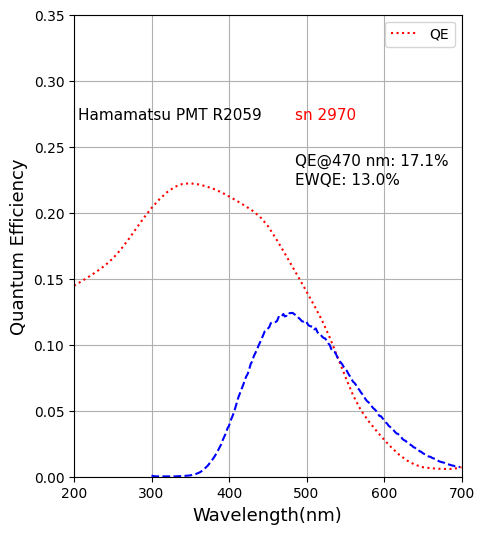

In [125]:
lam = [200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 
300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 
404, 406, 408, 410, 412, 414, 416, 418, 420, 422, 424, 426, 428, 430, 432, 434, 436, 438, 440, 442, 444, 446, 448, 450, 452, 454, 456, 458, 460, 462, 464, 466, 468, 470, 472, 474, 476, 478, 480, 482, 484, 486, 488, 490, 492, 494, 496, 498, 500, 502, 504, 506, 
508, 510, 512, 514, 516, 518, 520, 522, 524, 526, 528, 530, 532, 534, 536, 538, 540, 542, 544, 546, 548, 550, 552, 554, 556, 558, 560, 562, 564, 566, 568, 570, 572, 574, 576, 578, 580, 582, 584, 586, 588, 590, 592, 594, 596, 598, 600, 602, 604, 606, 608, 610, 
612, 614, 616, 618, 620, 622, 624, 626, 628, 630, 632, 634, 636, 638, 640, 642, 644, 646, 648, 650, 652, 654, 656, 658, 660, 662, 664, 666, 668, 670, 672, 674, 676, 678, 680, 682, 684, 686, 688, 690, 692, 694, 696, 698, 700]
QE = [
    0.14465, 0.14535, 0.14606, 0.14676, 0.14747, 0.14817, 0.1489, 0.14963, 0.15036, 0.15109,
    0.15182, 0.1526, 0.15338, 0.15416, 0.15494, 0.15572, 0.1566, 0.15747, 0.15835, 0.15922,
    0.1601, 0.16115, 0.1622, 0.16324, 0.16429, 0.16534, 0.16665, 0.16795, 0.16926, 0.17056,
    0.17187, 0.17341, 0.17496, 0.1765, 0.17805, 0.17959, 0.18125, 0.18291, 0.18457, 0.18623,
    0.18789, 0.18953, 0.19116, 0.1928, 0.19443, 0.19607, 0.19757, 0.19907, 0.20056, 0.20206,
    0.20356, 0.20486, 0.20617, 0.20747, 0.20878, 0.21008, 0.21117, 0.21226, 0.21335, 0.21444,
    0.21553, 0.21634, 0.21715, 0.21797, 0.21878, 0.21959, 0.22004, 0.22048, 0.22093, 0.22137,
    0.22182, 0.22191, 0.222, 0.22209, 0.22218, 0.22227, 0.22212, 0.22197, 0.22181, 0.22166,
    0.22151, 0.22122, 0.22092, 0.22063, 0.22033, 0.22004, 0.21964, 0.21925, 0.21885, 0.21846,
    0.21806, 0.21755, 0.21703, 0.21652, 0.216, 0.21549, 0.21487, 0.21426, 0.21364, 0.21303,
    0.21241, 0.21174, 0.21107, 0.2104, 0.20973, 0.20906, 0.20835, 0.20764, 0.20692, 0.20621,
    0.2055, 0.20473, 0.20395, 0.20318, 0.2024, 0.20163, 0.20069, 0.19975, 0.19881, 0.19787,
    0.19693, 0.19555, 0.19418, 0.1928, 0.19143, 0.19005, 0.18824, 0.18643, 0.18463, 0.18282,
    0.18101, 0.17904, 0.17707, 0.17509, 0.17312, 0.17115, 0.16912, 0.16709, 0.16507, 0.16304,
    0.16101, 0.15895, 0.1569, 0.15484, 0.15279, 0.15073, 0.14865, 0.14656, 0.14448, 0.14239,
    0.14031, 0.13818, 0.13606, 0.13393, 0.13181, 0.12968, 0.12743, 0.12517, 0.12292, 0.12066,
    0.11841, 0.11581, 0.11321, 0.11062, 0.10802, 0.10542, 0.1025, 0.09957, 0.09665, 0.09372,
    0.0908, 0.08781, 0.08483, 0.08184, 0.07886, 0.07587, 0.07306, 0.07024, 0.06743, 0.06461,
    0.0618, 0.05955, 0.05729, 0.05504, 0.05278, 0.05053, 0.04885, 0.04717, 0.04548, 0.0438,
    0.04212, 0.04066, 0.0392, 0.03773, 0.03627, 0.03481, 0.03345, 0.0321, 0.03074, 0.02939,
    0.02803, 0.0268, 0.02556, 0.02433, 0.02309, 0.02186, 0.02078, 0.0197, 0.01863, 0.01755,
    0.01647, 0.01561, 0.01475, 0.01389, 0.01303, 0.01217, 0.01155, 0.01093, 0.01031, 0.00969,
    0.00907, 0.0087, 0.00833, 0.00797, 0.0076, 0.00723, 0.00707, 0.00691, 0.00675, 0.00659,
    0.00643, 0.00635, 0.00627, 0.00619, 0.00611, 0.00603, 0.00599, 0.00594, 0.0059, 0.00585,
    0.00581, 0.00584, 0.00588, 0.00591, 0.00595, 0.00598, 0.00623, 0.00648, 0.00672, 0.00697,
    0.00722
]
plt.figure(figsize=(5,6))
Emis = [(a+b+c)/2400 for a,b,c in zip(data[6]['fluorescence'], data[12]['fluorescence'], data[20]['fluorescence'])][0:200]
E = sum(Emis[i-50] * QE[i] for i in range(50, 250)) / sum(Emis[i-50] for i in range(50,250))
plt.plot(lam, QE, label= 'QE', linestyle=':', color='red')
plt.plot(data[6]['wavelengths'][0:200], Emis , linestyle='--', color = 'blue')
# plt.scatter(data[6]['wavelengths'], data[6]['fluorescence'],label='BGO 6', marker= '^')
# plt.scatter(data[12]['wavelengths'], data[12]['fluorescence'],label='BGO 12', marker= 's')
# plt.scatter(data[20]['wavelengths'], data[20]['fluorescence'],label='BGO 20', marker= '.')
plt.xlabel("Wavelength(nm)", fontsize = 13)
plt.grid(True)
plt.legend()
plt.ylim(0,0.35)
plt.xlim(200,700)
plt.ylabel("Quantum Efficiency", fontsize = 13)
plt.text(0.01, 0.8, f'Hamamatsu PMT R2059' , transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
plt.text(0.57, 0.8, f'sn 2970' , transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='red')
plt.text(0.57, 0.7, f'QE@470 nm: {QE[135]*100:.1f}%' , transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
plt.text(0.57, 0.66, f'EWQE: {E*100:.1f}%' , transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')



In [ ]:
max(QE)
QE[135]

0.17115

IMPORT PACKAGES

In [6]:
import matplotlib.pyplot as plt


lam = [200.0, 202.0, 204.0, 206.0, 208.0, 210.0, 212.0, 214.0, 216.0, 218.0, 220.0, 222.0, 224.0, 226.0, 228.0, 230.0, 232.0, 234.0, 236.0, 238.0, 240.0, 242.0, 244.0, 246.0, 248.0, 250.0, 252.0, 254.0, 256.0, 258.0, 260.0, 262.0, 264.0, 266.0, 268.0, 270.0, 272.0, 274.0, 276.0, 278.0, 280.0, 282.0, 284.0, 286.0, 288.0, 290.0, 292.0, 294.0, 296.0, 298.0, 300.0, 302.0, 304.0, 306.0, 308.0, 310.0, 312.0, 314.0, 316.0, 318.0, 320.0, 322.0, 324.0, 326.0, 328.0, 330.0, 332.0, 334.0, 336.0, 338.0, 340.0, 342.0, 344.0, 346.0, 348.0, 350.0, 352.0, 354.0, 356.0, 358.0, 360.0, 362.0, 364.0, 366.0, 368.0, 370.0, 372.0, 374.0, 376.0, 378.0, 380.0, 382.0, 384.0, 386.0, 388.0, 390.0, 392.0, 394.0, 396.0, 398.0, 400.0, 402.0, 404.0, 406.0, 408.0, 410.0, 412.0, 414.0, 416.0, 418.0, 420.0, 422.0, 424.0, 426.0, 428.0, 430.0, 432.0, 434.0, 436.0, 438.0, 440.0, 442.0, 444.0, 446.0, 448.0, 450.0, 452.0, 454.0, 456.0, 458.0, 460.0, 462.0, 464.0, 466.0, 468.0, 470.0, 472.0, 474.0, 476.0, 478.0, 480.0, 482.0, 484.0, 486.0, 488.0, 490.0, 492.0, 494.0, 496.0, 498.0, 500.0, 502.0, 504.0, 506.0, 508.0, 510.0, 512.0, 514.0, 516.0, 518.0, 520.0, 522.0, 524.0, 526.0, 528.0, 530.0, 532.0, 534.0, 536.0, 538.0, 540.0, 542.0, 544.0, 546.0, 548.0, 550.0, 552.0, 554.0, 556.0, 558.0, 560.0, 562.0, 564.0, 566.0, 568.0, 570.0, 572.0, 574.0, 576.0, 578.0, 580.0, 582.0, 584.0, 586.0, 588.0, 590.0, 592.0, 594.0, 596.0, 598.0, 600.0, 602.0, 604.0, 606.0, 608.0, 610.0, 612.0, 614.0, 616.0, 618.0, 620.0, 622.0, 624.0, 626.0, 628.0, 630.0, 632.0, 634.0, 636.0, 638.0, 640.0, 642.0, 644.0, 646.0, 648.0, 650.0, 652.0, 654.0, 656.0, 658.0, 660.0, 662.0, 664.0, 666.0, 668.0, 670.0, 672.0, 674.0, 676.0, 678.0, 680.0, 682.0, 684.0, 686.0, 688.0, 690.0, 692.0, 694.0, 696.0, 698.0, 700.0, 702.0, 704.0, 706.0, 708.0, 710.0, 712.0, 714.0, 716.0, 718.0, 720.0, 722.0, 724.0, 726.0, 728.0, 730.0, 732.0, 734.0, 736.0, 738.0, 740.0, 742.0, 744.0, 746.0, 748.0, 750.0, 752.0, 754.0, 756.0, 758.0, 760.0, 762.0, 764.0, 766.0, 768.0, 770.0, 772.0, 774.0, 776.0, 778.0, 780.0, 782.0, 784.0, 786.0, 788.0, 790.0, 792.0, 794.0, 796.0, 798.0, 800.0]
# Tper_L_1 = [1.29, 1.26001, 1.09001, 1.20001, 1.08, 1.02, 1.02, 1.03001, 1.03001, 0.920013, 0.980011, 0.900009, 0.920013, 0.880005, 0.900009, 0.890015, 0.910004, 0.880005, 0.86, 0.800003, 0.790008, 0.770004, 0.820007, 0.76001, 0.710007, 0.730011, 0.740005, 0.710007, 0.690002, 0.690002, 0.670013, 0.630005, 0.650009, 0.630005, 0.600006, 0.630005, 0.630005, 0.650009, 0.650009, 0.650009, 0.630005, 0.630005, 0.670013, 0.670013, 0.640015, 0.670013, 0.680008, 0.640015, 0.650009, 0.640015, 0.660004, 0.640015, 0.61, 0.62001, 0.600006, 0.580002, 0.730011, 1.41, 3.46, 7.24, 11.1, 15.09, 19.04, 23.09, 27.64, 31.2, 34.5, 38.0, 41.47, 45.19, 47.59, 50.26, 52.51, 54.98, 57.41, 59.28, 60.62, 61.43, 62.8, 63.72, 65.25, 65.25, 66.35, 67.38, 67.02, 67.98, 68.2, 69.01, 69.43, 69.82, 69.72, 70.02, 70.22, 70.72, 70.12, 69.81, 70.75, 70.88, 71.27, 71.29, 71.64, 71.63, 71.7, 71.8, 71.76, 71.77, 71.96, 72.28, 72.36, 72.27, 72.56, 72.49, 72.64, 73.03, 72.94, 72.92, 73.11, 72.91, 73.34, 73.08, 73.19, 73.38, 73.34, 73.47, 73.57, 73.63, 73.59, 73.88, 73.8, 73.99, 74.01, 74.09, 74.05, 74.12, 74.27, 74.2, 74.33, 74.46, 74.42, 74.61, 74.61, 74.68, 74.7, 74.72, 74.78, 74.67, 74.72, 74.97, 74.89, 75.03, 75.06, 75.03, 75.0, 75.04, 75.13, 75.13, 75.21, 75.27, 75.26, 75.31, 75.31, 75.49, 75.47, 75.46, 75.65, 75.6, 75.62, 75.51, 75.65, 75.69, 75.73, 75.74, 75.79, 75.97, 75.88, 75.88, 76.06, 75.97, 76.06, 75.95, 76.11, 76.13, 76.21, 76.2, 76.15, 76.13, 76.25, 76.15, 76.22, 76.24, 76.34, 76.34, 76.5, 76.4, 76.53, 76.5, 76.59, 76.51, 76.55, 76.63, 76.69, 76.56, 76.7, 76.68, 76.76, 76.72, 76.68, 76.79, 76.91, 76.67, 76.8, 76.76, 76.93, 76.86, 76.85, 76.95, 77.01, 76.85, 76.96, 77.07, 77.22, 77.18, 77.2, 77.02, 77.13, 77.06, 77.23, 77.05, 77.18, 77.2, 77.15, 77.08, 77.11, 77.24, 77.17, 77.25, 77.09, 77.29, 77.33, 77.31, 77.4, 77.35, 77.43, 77.44, 77.48, 77.47, 77.6, 77.39, 77.44, 77.47, 77.55, 77.6, 77.56, 77.67, 77.76, 77.51, 77.56, 77.53, 77.74, 77.6, 77.72, 77.66, 77.69, 77.7, 77.45, 77.53, 77.77, 77.49, 77.63, 77.64, 77.82, 77.62, 77.83, 77.76, 77.76, 77.5, 78.03, 77.98, 77.83, 77.73, 77.67, 78.25, 77.97, 77.86, 77.92, 77.94, 77.97, 77.74, 77.94, 78.03, 77.97, 77.88, 77.93, 78.13, 78.11, 77.71, 78.03, 78.05, 78.11, 78.21, 78.36]
# Tper_L_7 = [0.800003, 0.940002, 0.780014, 0.750015, 0.780014, 0.76001, 0.790008, 0.660004, 0.740005, 0.720001, 0.740005, 0.680008, 0.670013, 0.670013, 0.680008, 0.670013, 0.680008, 0.670013, 0.680008, 0.670013, 0.660004, 0.630005, 0.61, 0.600006, 0.570007, 0.61, 0.580002, 0.590011, 0.600006, 0.550003, 0.560013, 0.520004, 0.520004, 0.530014, 0.550003, 0.550003, 0.540008, 0.520004, 0.550003, 0.550003, 0.560013, 0.550003, 0.590011, 0.580002, 0.570007, 0.560013, 0.560013, 0.550003, 0.570007, 0.570007, 0.550003, 0.550003, 0.570007, 0.570007, 0.540008, 0.550003, 0.740005, 1.65, 4.21001, 8.62001, 12.9, 17.16, 21.32, 25.13, 29.54, 32.34, 35.52, 38.7, 41.82, 44.58, 47.02, 49.61, 52.17, 54.11, 55.39, 57.3, 58.06, 59.68, 60.6, 62.19, 62.59, 63.36, 64.11, 64.51, 65.32, 65.97, 65.97, 67.32, 67.04, 66.85, 67.04, 68.08, 68.15, 68.48, 68.24, 68.23, 68.6, 68.75, 68.81, 69.22, 69.28, 69.42, 69.66, 69.76, 69.82, 70.07, 70.11, 70.39, 70.23, 70.55, 70.5, 70.56, 70.9, 70.74, 70.76, 70.89, 71.06, 71.05, 71.24, 71.23, 71.34, 71.43, 71.57, 71.57, 71.66, 71.92, 71.87, 71.98, 72.07, 72.0, 72.18, 72.28, 72.24, 72.36, 72.37, 72.55, 72.46, 72.68, 72.5, 72.75, 72.8, 72.8, 72.94, 72.93, 73.01, 73.16, 73.18, 73.15, 73.22, 73.29, 73.25, 73.2, 73.47, 73.49, 73.57, 73.61, 73.6, 73.55, 73.7, 73.61, 73.78, 73.79, 73.84, 73.84, 74.02, 73.93, 73.99, 74.11, 74.06, 74.06, 74.33, 74.3, 74.29, 74.2, 74.37, 74.38, 74.43, 74.42, 74.5, 74.63, 74.6, 74.58, 74.52, 74.68, 74.67, 74.75, 74.81, 74.87, 74.8, 74.7, 74.93, 74.95, 75.02, 75.02, 74.92, 74.94, 75.09, 75.07, 75.12, 75.13, 75.16, 75.34, 75.28, 75.16, 75.3, 75.29, 75.34, 75.3, 75.34, 75.36, 75.42, 75.52, 75.6, 75.4, 75.55, 75.52, 75.48, 75.51, 75.6, 75.72, 75.66, 75.72, 75.66, 75.61, 75.71, 75.9, 75.84, 75.84, 75.98, 75.7, 75.87, 76.05, 75.93, 76.03, 75.95, 76.0, 76.02, 76.12, 76.16, 75.9, 76.05, 75.95, 75.99, 76.13, 76.08, 76.05, 76.05, 76.23, 76.38, 76.23, 76.1, 76.25, 76.34, 76.29, 76.2, 76.4, 76.19, 76.3, 76.38, 76.32, 76.36, 76.33, 76.4, 76.42, 76.09, 76.4, 76.57, 76.65, 76.57, 76.74, 76.84, 76.49, 76.52, 76.46, 76.68, 76.5, 76.11, 76.64, 76.52, 76.67, 76.55, 76.65, 76.7, 76.91, 76.63, 76.66, 76.56, 76.76, 77.0, 76.84, 76.97, 76.72, 76.45, 76.61, 76.87, 76.86, 76.94, 77.28, 76.93, 76.94, 76.6]
# Tper_L_14 = [1.21, 1.18, 1.17001, 1.06001, 0.940002, 1.13, 1.03001, 1.09001, 1.02, 1.03001, 0.880005, 0.980011, 0.940002, 0.900009, 0.920013, 0.930008, 0.890015, 0.900009, 0.87001, 0.830002, 0.840011, 0.830002, 0.790008, 0.750015, 0.770004, 0.780014, 0.750015, 0.730011, 0.740005, 0.680008, 0.680008, 0.680008, 0.670013, 0.670013, 0.660004, 0.62001, 0.650009, 0.640015, 0.670013, 0.670013, 0.680008, 0.690002, 0.680008, 0.690002, 0.700012, 0.670013, 0.690002, 0.670013, 0.670013, 0.680008, 0.670013, 0.670013, 0.650009, 0.640015, 0.630005, 0.630005, 0.920013, 2.44, 6.67001, 14.08, 20.56, 26.74, 31.4, 35.37, 39.24, 41.9, 43.98, 46.56, 48.76, 50.52, 51.96, 54.43, 55.88, 56.8, 58.3, 59.88, 60.82, 61.54, 62.4, 63.5, 64.27, 64.89, 65.89, 65.85, 67.16, 67.08, 66.77, 67.87, 67.96, 68.5, 68.46, 69.28, 69.0, 69.22, 69.19, 70.05, 69.9, 69.91, 69.87, 70.23, 70.07, 70.47, 70.62, 70.8, 70.62, 70.97, 70.89, 71.07, 71.23, 71.38, 71.41, 71.53, 71.67, 71.55, 71.76, 71.72, 71.89, 72.05, 71.98, 72.18, 72.38, 72.31, 72.41, 72.31, 72.67, 72.8, 72.8, 72.69, 73.02, 72.95, 73.16, 73.05, 73.02, 73.21, 73.13, 73.31, 73.41, 73.44, 73.42, 73.59, 73.52, 73.67, 73.61, 73.64, 73.74, 73.85, 73.86, 73.72, 74.06, 74.04, 74.09, 74.0, 74.09, 74.22, 74.24, 74.42, 74.49, 74.37, 74.54, 74.34, 74.53, 74.71, 74.5, 74.61, 74.76, 74.71, 74.8, 74.81, 74.8, 74.76, 74.97, 74.91, 74.82, 75.03, 75.0, 75.08, 75.07, 75.23, 75.2, 75.23, 75.23, 75.24, 75.29, 75.26, 75.3, 75.34, 75.33, 75.38, 75.27, 75.38, 75.55, 75.58, 75.61, 75.57, 75.55, 75.52, 75.73, 75.71, 75.63, 75.73, 75.67, 75.63, 75.68, 75.73, 75.9, 75.99, 75.83, 75.77, 76.02, 75.89, 75.99, 75.97, 76.08, 75.97, 75.94, 76.08, 75.91, 76.07, 76.24, 76.13, 76.16, 76.12, 76.13, 76.14, 76.22, 76.16, 76.1, 76.27, 76.22, 76.3, 76.13, 76.3, 76.43, 76.22, 76.3, 76.48, 76.4, 76.43, 76.34, 76.43, 76.53, 76.39, 76.48, 76.44, 76.55, 76.48, 76.32, 76.45, 76.59, 76.62, 76.61, 76.74, 76.57, 76.77, 76.51, 76.7, 76.72, 76.63, 76.76, 76.67, 76.76, 76.81, 76.65, 76.88, 76.57, 76.8, 76.81, 77.16, 77.06, 76.98, 76.92, 76.88, 76.83, 76.76, 76.95, 76.98, 76.75, 77.05, 76.9, 76.79, 77.06, 76.8, 76.69, 77.3, 77.04, 76.8, 76.87, 77.04, 76.93, 76.95, 77.01, 77.17, 77.04, 77.23, 77.16, 77.12, 77.11, 77.11, 77.2, 77.39, 77.25]
# Tper_T_1 = [0.840011, 0.920013, 0.960007, 0.87001, 0.87001, 0.840011, 0.750015, 0.750015, 0.800003, 0.770004, 0.750015, 0.780014, 0.700012, 0.710007, 0.730011, 0.710007, 0.710007, 0.710007, 0.690002, 0.670013, 0.680008, 0.650009, 0.650009, 0.640015, 0.630005, 0.62001, 0.61, 0.600006, 0.580002, 0.540008, 0.570007, 0.550003, 0.540008, 0.520004, 0.530014, 0.540008, 0.530014, 0.550003, 0.540008, 0.550003, 0.540008, 0.580002, 0.570007, 0.560013, 0.530014, 0.560013, 0.550003, 0.560013, 0.560013, 0.540008, 0.550003, 0.540008, 0.62001, 1.04, 3.8, 9.87001, 19.22, 29.38, 38.48, 45.22, 49.16, 52.06, 54.63, 56.94, 58.2, 60.06, 62.1, 62.78, 64.52, 65.55, 66.4, 66.83, 67.31, 68.6, 69.34, 69.63, 70.47, 69.79, 70.47, 70.65, 71.2, 71.98, 72.3, 72.11, 72.32, 73.01, 72.91, 73.12, 72.99, 73.54, 73.39, 73.54, 73.26, 73.93, 74.14, 73.35, 73.88, 74.01, 74.08, 74.22, 74.31, 74.28, 74.57, 74.56, 74.75, 74.57, 74.74, 74.89, 74.97, 74.73, 75.04, 74.95, 75.15, 75.17, 75.3, 75.32, 75.47, 75.31, 75.61, 75.47, 75.38, 75.66, 75.54, 75.56, 75.72, 75.81, 75.62, 75.81, 75.9, 75.93, 76.0, 76.15, 76.14, 76.03, 76.14, 76.1, 76.19, 76.23, 76.33, 76.26, 76.24, 76.25, 76.45, 76.55, 76.3, 76.54, 76.56, 76.52, 76.55, 76.52, 76.55, 76.49, 76.57, 76.71, 76.68, 76.72, 76.65, 76.69, 76.81, 76.86, 76.88, 76.72, 76.83, 76.91, 77.02, 77.01, 77.0, 77.0, 76.95, 77.01, 77.14, 77.06, 77.12, 77.04, 77.17, 77.19, 77.25, 77.27, 77.43, 77.32, 77.31, 77.29, 77.37, 77.32, 77.28, 77.27, 77.16, 77.3, 77.37, 77.49, 77.46, 77.33, 77.43, 77.54, 77.53, 77.57, 77.57, 77.48, 77.49, 77.66, 77.59, 77.55, 77.54, 77.53, 77.62, 77.7, 77.68, 77.63, 77.71, 77.68, 77.75, 77.79, 77.7, 77.77, 77.68, 77.83, 77.8, 77.78, 77.78, 77.74, 77.85, 77.92, 77.92, 77.87, 77.92, 77.73, 77.95, 77.77, 77.92, 78.06, 77.94, 78.08, 77.97, 77.89, 77.97, 78.13, 77.98, 77.89, 78.11, 77.99, 77.93, 77.97, 78.11, 78.08, 78.01, 78.03, 78.13, 78.1, 78.06, 78.18, 78.19, 78.24, 78.28, 78.29, 78.26, 78.22, 78.1, 78.17, 78.22, 78.5, 78.46, 78.29, 78.09, 77.97, 78.16, 78.31, 78.22, 78.1, 78.22, 78.27, 78.52, 78.47, 78.36, 78.28, 78.41, 78.29, 78.48, 78.46, 78.16, 78.19, 78.51, 78.52, 78.43, 78.47, 78.64, 78.47, 78.43, 78.15, 78.47, 78.28, 78.47, 78.55, 78.5, 78.56, 78.42, 78.71, 78.59, 78.47, 78.48, 78.53, 78.63]
# Tper_T_7 = [1.09001, 0.990005, 0.86, 0.87001, 0.900009, 0.920013, 0.840011, 0.800003, 0.76001, 0.740005, 0.720001, 0.770004, 0.76001, 0.730011, 0.720001, 0.720001, 0.680008, 0.710007, 0.690002, 0.730011, 0.690002, 0.680008, 0.650009, 0.670013, 0.630005, 0.640015, 0.650009, 0.630005, 0.62001, 0.590011, 0.580002, 0.580002, 0.570007, 0.570007, 0.580002, 0.560013, 0.590011, 0.570007, 0.580002, 0.600006, 0.590011, 0.590011, 0.600006, 0.600006, 0.590011, 0.590011, 0.61, 0.600006, 0.590011, 0.61, 0.590011, 0.590011, 0.62001, 1.07, 3.95001, 10.26, 19.94, 29.92, 39.19, 45.84, 49.46, 52.77, 54.66, 56.64, 58.88, 60.36, 61.21, 62.91, 64.12, 64.67, 65.27, 66.51, 66.65, 67.95, 67.85, 69.45, 68.72, 69.88, 70.03, 70.32, 70.73, 71.06, 71.34, 71.34, 71.92, 72.25, 71.66, 72.19, 72.5, 72.42, 73.01, 73.17, 72.9, 73.35, 73.42, 72.02, 73.1, 73.29, 73.39, 73.48, 73.4, 73.66, 73.75, 73.77, 73.81, 73.92, 73.89, 74.12, 74.09, 74.29, 74.09, 74.25, 74.25, 74.25, 74.34, 74.15, 74.51, 74.46, 74.68, 74.59, 74.7, 74.76, 74.68, 74.97, 74.99, 75.15, 74.91, 74.9, 75.13, 75.01, 75.16, 75.28, 75.04, 75.28, 75.15, 75.29, 75.36, 75.41, 75.4, 75.39, 75.48, 75.41, 75.53, 75.76, 75.6, 75.63, 75.61, 75.77, 75.68, 75.56, 75.78, 75.7, 75.73, 75.88, 75.77, 75.95, 75.95, 75.9, 76.03, 75.99, 76.06, 75.99, 76.08, 76.02, 75.95, 76.12, 76.13, 76.29, 76.18, 76.19, 76.35, 76.29, 76.32, 76.25, 76.25, 76.28, 76.44, 76.27, 76.38, 76.48, 76.48, 76.48, 76.37, 76.44, 76.49, 76.5, 76.43, 76.46, 76.58, 76.45, 76.65, 76.77, 76.59, 76.69, 76.57, 76.57, 76.66, 76.7, 76.76, 76.74, 76.75, 76.65, 76.63, 76.79, 76.76, 76.79, 76.84, 76.76, 76.91, 76.86, 76.96, 76.93, 76.86, 76.85, 76.87, 76.94, 76.74, 76.82, 76.95, 76.95, 77.1, 76.89, 77.0, 77.03, 77.0, 77.2, 77.12, 76.94, 77.11, 77.08, 77.12, 77.27, 76.96, 77.04, 77.22, 77.3, 77.45, 77.38, 77.13, 77.3, 77.26, 77.15, 77.33, 77.18, 77.16, 77.31, 76.89, 77.26, 77.29, 77.39, 77.18, 77.31, 77.38, 77.24, 77.56, 77.34, 77.17, 77.47, 77.28, 77.3, 77.26, 77.18, 77.11, 77.53, 77.41, 77.51, 77.23, 77.48, 77.5, 77.7, 77.49, 77.25, 77.38, 77.35, 77.46, 77.28, 77.04, 77.48, 77.39, 77.43, 77.51, 77.32, 77.37, 77.99, 77.56, 77.49, 77.62, 77.38, 77.68, 77.56, 77.98, 77.33, 77.47, 77.28, 77.59, 77.52, 77.39, 77.62, 77.58, 77.94, 77.42]
# Tper_T_14 = [0.86, 1.06001, 0.500015, 0.790008, 0.920013, 0.830002, 0.970001, 0.900009, 0.880005, 0.800003, 0.800003, 0.730011, 0.770004, 0.770004, 0.720001, 0.780014, 0.76001, 0.76001, 0.740005, 0.690002, 0.670013, 0.690002, 0.660004, 0.680008, 0.670013, 0.650009, 0.660004, 0.630005, 0.640015, 0.61, 0.630005, 0.580002, 0.630005, 0.600006, 0.590011, 0.580002, 0.590011, 0.570007, 0.570007, 0.62001, 0.62001, 0.62001, 0.600006, 0.61, 0.62001, 0.600006, 0.62001, 0.62001, 0.61, 0.590011, 0.61, 0.630005, 0.700012, 1.18, 4.28001, 11.57, 22.65, 34.27, 44.52, 52.11, 55.99, 58.45, 60.87, 62.35, 63.98, 64.88, 66.26, 67.38, 68.04, 68.3, 68.82, 70.2, 70.9, 71.11, 70.55, 72.0, 72.36, 72.81, 72.71, 72.87, 73.4, 73.81, 73.94, 73.73, 74.03, 74.28, 73.91, 74.83, 75.08, 75.05, 74.71, 75.31, 75.66, 75.29, 75.14, 74.47, 75.74, 75.57, 75.35, 75.7, 75.54, 75.78, 75.68, 75.83, 75.7, 75.82, 75.92, 76.05, 76.15, 75.97, 76.09, 76.24, 76.22, 76.09, 76.43, 76.23, 76.25, 76.34, 76.39, 76.5, 76.47, 76.38, 76.64, 76.57, 76.5, 76.75, 76.58, 76.62, 76.8, 76.57, 76.66, 76.71, 76.68, 76.92, 76.76, 76.99, 76.79, 76.79, 76.92, 76.95, 76.89, 77.03, 76.95, 77.06, 76.91, 77.13, 77.1, 77.08, 77.16, 76.96, 77.11, 77.07, 77.26, 77.2, 77.18, 77.26, 77.15, 77.32, 77.29, 77.3, 77.33, 77.33, 77.34, 77.38, 77.33, 77.33, 77.37, 77.38, 77.46, 77.46, 77.53, 77.47, 77.33, 77.49, 77.6, 77.52, 77.49, 77.48, 77.59, 77.58, 77.69, 77.55, 77.59, 77.63, 77.51, 77.65, 77.59, 77.65, 77.58, 77.49, 77.7, 77.77, 77.75, 77.64, 77.73, 77.64, 77.75, 77.7, 77.63, 77.64, 77.71, 77.71, 77.65, 77.69, 77.58, 77.94, 77.84, 77.74, 77.71, 77.83, 77.78, 77.66, 77.86, 77.74, 77.8, 77.79, 77.71, 77.75, 77.89, 77.64, 77.74, 77.86, 77.86, 77.75, 77.71, 77.76, 77.83, 78.0, 77.98, 77.91, 77.74, 77.9, 77.91, 77.74, 77.85, 77.87, 78.19, 77.99, 77.94, 77.82, 78.0, 77.81, 77.95, 78.13, 77.94, 77.96, 77.83, 78.0, 77.91, 77.84, 78.04, 78.12, 78.01, 77.94, 78.01, 78.02, 77.9, 77.88, 77.94, 77.96, 78.09, 77.91, 78.03, 78.31, 77.89, 77.95, 78.04, 78.26, 78.29, 78.17, 78.11, 78.37, 78.04, 77.99, 77.98, 78.08, 77.91, 78.01, 77.94, 77.99, 77.93, 77.99, 77.87, 78.2, 77.84, 77.88, 78.02, 77.98, 78.02, 77.95, 78.11, 78.25, 78.15, 78.23, 78.19, 78.28, 78.12, 78.28, 78.42, 78.22, 78.17]
Tper_L = [[1.29, 1.26001, 1.09001, 1.20001, 1.08, 1.02, 1.02, 1.03001, 1.03001, 0.920013, 0.980011, 0.900009, 0.920013, 0.880005, 0.900009, 0.890015, 0.910004, 0.880005, 0.86, 0.800003, 0.790008, 0.770004, 0.820007, 0.76001, 0.710007, 0.730011, 0.740005, 0.710007, 0.690002, 0.690002, 0.670013, 0.630005, 0.650009, 0.630005, 0.600006, 0.630005, 0.630005, 0.650009, 0.650009, 0.650009, 0.630005, 0.630005, 0.670013, 0.670013, 0.640015, 0.670013, 0.680008, 0.640015, 0.650009, 0.640015, 0.660004, 0.640015, 0.61, 0.62001, 0.600006, 0.580002, 0.730011, 1.41, 3.46, 7.24, 11.1, 15.09, 19.04, 23.09, 27.64, 31.2, 34.5, 38.0, 41.47, 45.19, 47.59, 50.26, 52.51, 54.98, 57.41, 59.28, 60.62, 61.43, 62.8, 63.72, 65.25, 65.25, 66.35, 67.38, 67.02, 67.98, 68.2, 69.01, 69.43, 69.82, 69.72, 70.02, 70.22, 70.72, 70.12, 69.81, 70.75, 70.88, 71.27, 71.29, 71.64, 71.63, 71.7, 71.8, 71.76, 71.77, 71.96, 72.28, 72.36, 72.27, 72.56, 72.49, 72.64, 73.03, 72.94, 72.92, 73.11, 72.91, 73.34, 73.08, 73.19, 73.38, 73.34, 73.47, 73.57, 73.63, 73.59, 73.88, 73.8, 73.99, 74.01, 74.09, 74.05, 74.12, 74.27, 74.2, 74.33, 74.46, 74.42, 74.61, 74.61, 74.68, 74.7, 74.72, 74.78, 74.67, 74.72, 74.97, 74.89, 75.03, 75.06, 75.03, 75.0, 75.04, 75.13, 75.13, 75.21, 75.27, 75.26, 75.31, 75.31, 75.49, 75.47, 75.46, 75.65, 75.6, 75.62, 75.51, 75.65, 75.69, 75.73, 75.74, 75.79, 75.97, 75.88, 75.88, 76.06, 75.97, 76.06, 75.95, 76.11, 76.13, 76.21, 76.2, 76.15, 76.13, 76.25, 76.15, 76.22, 76.24, 76.34, 76.34, 76.5, 76.4, 76.53, 76.5, 76.59, 76.51, 76.55, 76.63, 76.69, 76.56, 76.7, 76.68, 76.76, 76.72, 76.68, 76.79, 76.91, 76.67, 76.8, 76.76, 76.93, 76.86, 76.85, 76.95, 77.01, 76.85, 76.96, 77.07, 77.22, 77.18, 77.2, 77.02, 77.13, 77.06, 77.23, 77.05, 77.18, 77.2, 77.15, 77.08, 77.11, 77.24, 77.17, 77.25, 77.09, 77.29, 77.33, 77.31, 77.4, 77.35, 77.43, 77.44, 77.48, 77.47, 77.6, 77.39, 77.44, 77.47, 77.55, 77.6, 77.56, 77.67, 77.76, 77.51, 77.56, 77.53, 77.74, 77.6, 77.72, 77.66, 77.69, 77.7, 77.45, 77.53, 77.77, 77.49, 77.63, 77.64, 77.82, 77.62, 77.83, 77.76, 77.76, 77.5, 78.03, 77.98, 77.83, 77.73, 77.67, 78.25, 77.97, 77.86, 77.92, 77.94, 77.97, 77.74, 77.94, 78.03, 77.97, 77.88, 77.93, 78.13, 78.11, 77.71, 78.03, 78.05, 78.11, 78.21, 78.36], [1.21, 0.950012, 0.970001, 1.12001, 0.920013, 1.00001, 0.820007, 0.920013, 0.960007, 1.02, 0.86, 0.87001, 0.920013, 0.840011, 0.800003, 0.86, 0.830002, 0.820007, 0.820007, 0.780014, 0.790008, 0.76001, 0.770004, 0.730011, 0.700012, 0.710007, 0.730011, 0.700012, 0.670013, 0.650009, 0.61, 0.630005, 0.61, 0.630005, 0.62001, 0.61, 0.600006, 0.630005, 0.650009, 0.61, 0.640015, 0.660004, 0.660004, 0.660004, 0.660004, 0.660004, 0.670013, 0.660004, 0.640015, 0.640015, 0.630005, 0.650009, 0.630005, 0.630005, 0.600006, 0.61, 0.86, 2.01001, 5.05, 10.54, 15.76, 20.38, 24.94, 28.85, 32.95, 35.66, 38.69, 41.22, 44.23, 46.94, 49.16, 51.48, 53.06, 55.29, 57.51, 58.39, 59.83, 61.38, 62.3, 63.0, 63.76, 64.56, 65.53, 66.9, 66.82, 67.14, 67.85, 68.1, 68.84, 68.8, 68.75, 69.55, 69.65, 69.56, 69.94, 70.27, 69.93, 70.31, 70.47, 70.56, 70.69, 70.9, 71.06, 71.09, 71.11, 71.2, 71.47, 71.5, 71.81, 71.56, 71.92, 71.87, 72.03, 72.18, 72.11, 72.32, 72.39, 72.34, 72.83, 72.63, 72.72, 72.69, 72.89, 72.88, 73.05, 73.18, 73.16, 73.21, 73.43, 73.31, 73.47, 73.61, 73.44, 73.7, 73.73, 73.79, 73.74, 73.95, 74.05, 74.07, 74.05, 74.21, 74.21, 74.25, 74.12, 74.33, 74.31, 74.47, 74.46, 74.47, 74.5, 74.51, 74.54, 74.69, 74.68, 74.74, 74.92, 74.8, 74.82, 75.01, 75.02, 75.12, 75.0, 75.13, 75.2, 75.22, 75.13, 75.27, 75.3, 75.2, 75.33, 75.31, 75.39, 75.49, 75.53, 75.46, 75.44, 75.56, 75.62, 75.49, 75.75, 75.72, 75.72, 75.75, 75.78, 75.83, 75.83, 75.87, 75.89, 75.95, 76.06, 76.05, 76.05, 76.1, 76.15, 76.14, 76.15, 76.1, 76.11, 76.09, 76.24, 76.22, 76.26, 76.18, 76.38, 76.38, 76.41, 76.36, 76.48, 76.26, 76.5, 76.49, 76.57, 76.52, 76.52, 76.57, 76.58, 76.52, 76.65, 76.68, 76.72, 76.7, 76.78, 76.8, 76.71, 76.8, 76.88, 76.62, 76.78, 76.89, 76.86, 76.68, 76.92, 76.79, 76.78, 76.97, 76.67, 77.0, 76.88, 77.08, 77.03, 76.96, 77.07, 76.96, 77.03, 77.0, 77.09, 76.97, 77.28, 76.98, 77.02, 77.09, 77.37, 77.31, 77.32, 77.24, 77.09, 76.96, 77.32, 77.42, 77.28, 77.46, 77.32, 77.43, 77.28, 77.35, 77.15, 77.42, 77.69, 77.34, 77.46, 77.47, 77.54, 77.46, 77.54, 77.57, 77.61, 77.75, 77.76, 77.43, 77.37, 77.9, 77.66, 77.64, 77.48, 77.7, 77.29, 77.43, 77.63, 77.62, 77.54, 77.49, 77.64, 77.93, 77.72, 77.83, 77.78, 77.92, 77.77, 77.62, 77.96], [1.24, 1.04, 1.20001, 1.1, 1.04, 1.11, 1.00001, 1.11, 0.970001, 0.780014, 1.03001, 1.00001, 0.980011, 0.900009, 0.920013, 0.890015, 0.880005, 0.87001, 0.930008, 0.840011, 0.850006, 0.800003, 0.76001, 0.810013, 0.76001, 0.750015, 0.76001, 0.730011, 0.700012, 0.680008, 0.640015, 0.630005, 0.660004, 0.630005, 0.650009, 0.650009, 0.650009, 0.62001, 0.680008, 0.670013, 0.690002, 0.680008, 0.680008, 0.680008, 0.680008, 0.680008, 0.680008, 0.630005, 0.680008, 0.680008, 0.640015, 0.690002, 0.670013, 0.650009, 0.61, 0.590011, 0.86, 1.97, 5.05, 10.77, 15.96, 21.0, 25.34, 29.27, 33.1, 36.2, 38.86, 41.35, 44.13, 47.1, 49.22, 51.38, 53.56, 55.15, 56.98, 58.07, 60.0, 60.77, 62.11, 62.75, 63.65, 64.28, 64.76, 65.73, 66.01, 66.96, 67.02, 67.42, 68.08, 68.7, 68.08, 68.76, 69.09, 69.0, 69.66, 68.35, 69.22, 69.53, 69.77, 69.83, 70.03, 70.41, 70.24, 70.63, 70.51, 70.46, 70.81, 71.01, 70.95, 71.14, 71.06, 71.34, 71.44, 71.45, 71.3, 71.67, 71.72, 71.57, 71.97, 71.83, 72.07, 71.96, 72.06, 72.06, 72.39, 72.26, 72.26, 72.5, 72.48, 72.65, 72.75, 72.73, 72.69, 72.83, 72.98, 72.95, 72.94, 73.13, 73.03, 73.07, 73.3, 73.39, 73.31, 73.37, 73.43, 73.33, 73.37, 73.53, 73.48, 73.63, 73.58, 73.69, 73.6, 73.79, 73.79, 73.86, 73.91, 73.84, 73.95, 74.12, 74.08, 74.15, 74.07, 74.16, 74.21, 74.26, 74.2, 74.24, 74.25, 74.37, 74.4, 74.36, 74.3, 74.49, 74.59, 74.6, 74.65, 74.63, 74.61, 74.58, 74.74, 74.67, 74.79, 74.78, 74.86, 74.82, 74.88, 74.93, 74.93, 74.79, 74.97, 75.07, 75.08, 75.1, 75.22, 75.22, 75.18, 75.07, 75.2, 75.2, 75.2, 75.21, 75.3, 75.31, 75.24, 75.33, 75.28, 75.31, 75.43, 75.42, 75.44, 75.31, 75.41, 75.45, 75.38, 75.52, 75.49, 75.51, 75.46, 75.51, 75.58, 75.57, 75.66, 75.65, 75.64, 75.56, 75.73, 75.55, 75.61, 75.73, 75.55, 75.7, 75.66, 75.7, 75.75, 75.86, 75.64, 75.81, 75.8, 75.65, 75.95, 75.8, 75.77, 75.88, 75.93, 75.9, 75.71, 75.97, 75.99, 76.05, 75.77, 76.11, 76.11, 76.26, 76.12, 76.12, 75.85, 75.95, 75.99, 76.05, 76.15, 76.14, 76.21, 76.19, 75.85, 75.96, 76.24, 76.04, 76.13, 76.23, 76.07, 76.21, 76.36, 76.46, 76.13, 76.17, 76.36, 76.38, 76.37, 76.31, 76.14, 76.21, 76.2, 76.43, 76.33, 76.32, 76.33, 76.18, 76.16, 76.52, 76.1, 76.36, 76.34, 76.82, 76.37, 76.36, 76.44, 76.21, 76.3, 76.44, 76.33], [1.07, 1.03001, 1.05, 1.07, 0.960007, 0.960007, 1.00001, 0.930008, 0.940002, 0.930008, 0.930008, 0.950012, 0.850006, 0.900009, 0.880005, 0.850006, 0.850006, 0.86, 0.850006, 0.830002, 0.790008, 0.780014, 0.790008, 0.770004, 0.770004, 0.740005, 0.76001, 0.740005, 0.730011, 0.680008, 0.660004, 0.670013, 0.640015, 0.630005, 0.660004, 0.62001, 0.640015, 0.650009, 0.630005, 0.670013, 0.660004, 0.680008, 0.670013, 0.660004, 0.670013, 0.640015, 0.670013, 0.700012, 0.670013, 0.660004, 0.640015, 0.650009, 0.640015, 0.62001, 0.62001, 0.590011, 0.800003, 1.84001, 4.71001, 9.78002, 14.44, 19.4, 23.99, 28.35, 32.64, 35.77, 38.91, 41.98, 44.92, 48.25, 50.33, 53.23, 55.16, 57.99, 58.89, 60.31, 61.53, 63.3, 64.1, 65.24, 66.15, 66.62, 67.7, 67.85, 68.72, 68.9, 69.05, 69.7, 70.21, 70.21, 70.84, 71.39, 71.17, 71.84, 70.8, 71.24, 71.55, 71.66, 71.6, 71.66, 71.76, 71.97, 72.16, 72.24, 72.38, 72.55, 72.4, 72.74, 72.64, 72.82, 72.81, 72.97, 73.11, 72.95, 73.11, 73.16, 73.21, 73.37, 73.51, 73.43, 73.57, 73.49, 73.71, 73.87, 73.73, 73.98, 73.92, 73.9, 74.15, 74.0, 74.16, 74.17, 74.27, 74.49, 74.29, 74.52, 74.46, 74.55, 74.57, 74.47, 74.66, 74.68, 74.67, 74.85, 74.84, 74.92, 75.05, 75.08, 75.01, 74.97, 75.12, 75.13, 75.14, 75.27, 75.2, 75.31, 75.26, 75.29, 75.39, 75.39, 75.42, 75.53, 75.51, 75.51, 75.44, 75.66, 75.69, 75.71, 75.66, 75.76, 75.74, 75.86, 75.82, 75.93, 76.0, 75.98, 75.95, 76.06, 76.01, 76.0, 76.04, 76.04, 76.1, 76.16, 76.25, 76.22, 76.16, 76.12, 76.16, 76.24, 76.32, 76.46, 76.33, 76.35, 76.25, 76.4, 76.49, 76.5, 76.44, 76.62, 76.55, 76.52, 76.46, 76.5, 76.67, 76.64, 76.71, 76.51, 76.69, 76.68, 76.75, 76.8, 76.88, 76.75, 76.82, 76.79, 76.71, 76.81, 76.76, 76.89, 76.86, 76.94, 76.79, 76.98, 76.88, 77.02, 77.0, 76.93, 77.15, 76.98, 76.99, 77.34, 77.16, 77.0, 77.15, 77.06, 77.18, 77.25, 77.19, 77.34, 77.14, 77.22, 77.15, 77.31, 77.36, 77.05, 77.05, 77.19, 77.46, 77.22, 77.22, 77.47, 77.29, 77.44, 77.46, 77.2, 77.24, 77.2, 77.24, 77.27, 77.36, 77.32, 77.53, 77.52, 77.34, 77.34, 77.48, 77.66, 77.59, 77.37, 77.56, 77.41, 77.71, 77.7, 77.46, 77.76, 77.38, 77.83, 77.57, 77.74, 77.81, 77.63, 77.49, 77.83, 77.87, 77.68, 77.44, 77.59, 77.58, 77.78, 77.93, 77.32, 77.8, 77.78, 77.71, 78.05, 77.76, 77.94, 77.86, 77.85, 77.52], [1.19, 1.02, 1.14001, 0.960007, 1.08, 0.86, 0.950012, 1.04, 1.08, 0.910004, 0.910004, 0.940002, 0.900009, 0.880005, 0.890015, 0.880005, 0.87001, 0.86, 0.840011, 0.820007, 0.820007, 0.780014, 0.790008, 0.770004, 0.750015, 0.76001, 0.710007, 0.700012, 0.740005, 0.680008, 0.670013, 0.670013, 0.660004, 0.640015, 0.650009, 0.640015, 0.670013, 0.660004, 0.660004, 0.690002, 0.660004, 0.690002, 0.670013, 0.690002, 0.690002, 0.700012, 0.690002, 0.680008, 0.680008, 0.680008, 0.670013, 0.670013, 0.670013, 0.650009, 0.62001, 0.61, 0.770004, 1.62001, 4.1, 8.60001, 13.01, 17.64, 21.72, 26.01, 30.11, 33.32, 36.7, 39.69, 42.55, 45.58, 47.67, 50.95, 52.72, 55.07, 56.1, 57.66, 58.73, 60.64, 61.4, 62.84, 63.73, 64.21, 64.76, 65.09, 66.36, 66.65, 66.54, 67.84, 67.82, 68.18, 68.03, 68.72, 68.79, 69.09, 68.93, 68.83, 69.43, 69.56, 69.58, 69.81, 69.97, 70.2, 70.43, 70.38, 70.33, 70.91, 70.8, 70.89, 70.77, 71.27, 71.09, 71.19, 71.33, 71.27, 71.46, 71.44, 71.67, 71.7, 71.83, 71.94, 72.14, 71.93, 72.13, 72.23, 72.18, 72.6, 72.4, 72.51, 72.69, 72.52, 72.71, 72.76, 72.76, 72.94, 73.05, 73.04, 73.2, 73.13, 73.34, 73.18, 73.2, 73.34, 73.48, 73.64, 73.61, 73.61, 73.7, 73.65, 73.74, 73.72, 73.82, 73.86, 73.88, 74.02, 74.01, 74.14, 74.18, 74.22, 74.16, 74.23, 74.35, 74.35, 74.4, 74.41, 74.47, 74.48, 74.59, 74.61, 74.68, 74.61, 74.82, 74.73, 74.64, 74.72, 74.89, 74.8, 74.93, 74.96, 74.93, 74.97, 75.12, 75.13, 75.05, 75.18, 75.18, 75.26, 75.29, 75.22, 75.29, 75.37, 75.47, 75.5, 75.46, 75.44, 75.42, 75.39, 75.61, 75.56, 75.51, 75.69, 75.63, 75.44, 75.6, 75.54, 75.68, 75.75, 75.76, 75.73, 75.79, 75.83, 75.77, 75.91, 75.99, 75.88, 75.89, 75.97, 75.92, 75.89, 75.98, 76.01, 76.25, 76.1, 76.07, 76.06, 76.03, 76.1, 76.15, 76.14, 76.28, 76.16, 76.34, 76.29, 76.33, 76.11, 76.28, 76.41, 76.29, 76.44, 76.25, 76.36, 76.43, 76.27, 76.42, 76.44, 76.48, 76.49, 76.53, 76.6, 76.62, 76.38, 76.71, 76.54, 76.62, 76.74, 76.56, 76.71, 76.48, 76.54, 76.8, 76.72, 76.68, 76.8, 76.69, 76.95, 76.61, 76.62, 76.93, 77.08, 76.99, 76.62, 76.99, 76.79, 76.94, 76.78, 76.91, 76.91, 76.92, 76.9, 76.82, 76.76, 76.9, 76.9, 77.08, 77.04, 76.99, 77.1, 76.64, 76.97, 77.04, 76.97, 77.27, 77.32, 76.98, 77.36, 77.04, 77.12, 76.92, 77.33, 77.19, 77.32, 77.23], [0.910004, 1.15, 0.660004, 0.910004, 0.980011, 0.87001, 0.840011, 0.920013, 0.910004, 0.800003, 0.87001, 0.87001, 0.86, 0.86, 0.840011, 0.86, 0.820007, 0.840011, 0.820007, 0.810013, 0.76001, 0.790008, 0.76001, 0.740005, 0.730011, 0.730011, 0.720001, 0.690002, 0.690002, 0.670013, 0.660004, 0.640015, 0.630005, 0.630005, 0.62001, 0.61, 0.630005, 0.62001, 0.650009, 0.640015, 0.660004, 0.680008, 0.660004, 0.690002, 0.690002, 0.660004, 0.660004, 0.660004, 0.690002, 0.650009, 0.680008, 0.640015, 0.670013, 0.640015, 0.630005, 0.650009, 1.00001, 2.53001, 6.86, 14.39, 20.94, 27.17, 32.05, 36.27, 40.49, 42.75, 45.76, 48.08, 50.03, 52.49, 54.04, 56.28, 57.29, 59.35, 60.09, 61.22, 62.58, 63.79, 64.23, 65.83, 66.22, 66.66, 67.53, 67.92, 68.58, 68.92, 69.32, 69.58, 69.92, 70.15, 70.16, 70.49, 71.18, 70.46, 70.79, 71.21, 71.04, 71.32, 71.31, 71.52, 71.58, 71.68, 71.94, 72.12, 72.05, 72.2, 72.04, 72.17, 72.28, 72.4, 72.42, 72.57, 72.75, 72.64, 72.72, 72.65, 73.05, 73.06, 73.13, 73.19, 73.48, 73.19, 73.28, 73.49, 73.55, 73.62, 73.67, 73.79, 73.9, 73.92, 73.91, 73.94, 73.96, 74.18, 74.12, 74.15, 74.17, 74.24, 74.29, 74.41, 74.25, 74.54, 74.52, 74.56, 74.56, 74.57, 74.73, 74.78, 74.74, 74.72, 74.82, 74.72, 74.96, 75.06, 74.95, 74.98, 74.97, 75.09, 74.94, 75.12, 75.32, 75.35, 75.31, 75.32, 75.24, 75.3, 75.45, 75.44, 75.59, 75.6, 75.63, 75.53, 75.53, 75.59, 75.79, 75.63, 75.8, 75.67, 75.85, 75.87, 76.0, 75.86, 75.95, 75.93, 76.01, 76.05, 76.01, 76.05, 76.04, 76.02, 76.07, 76.15, 76.29, 76.16, 76.05, 76.18, 76.32, 76.27, 76.17, 76.29, 76.32, 76.34, 76.31, 76.31, 76.42, 76.53, 76.45, 76.41, 76.41, 76.52, 76.49, 76.56, 76.64, 76.52, 76.54, 76.55, 76.49, 76.57, 76.73, 76.69, 76.63, 76.73, 76.8, 76.75, 76.65, 76.79, 76.8, 76.79, 76.8, 76.89, 76.65, 76.95, 76.9, 76.86, 76.91, 76.89, 76.93, 76.87, 76.9, 77.07, 77.06, 76.96, 76.85, 77.1, 76.99, 76.88, 77.02, 77.06, 77.24, 77.07, 77.1, 77.17, 77.12, 77.13, 77.37, 77.37, 76.93, 77.05, 76.97, 77.32, 77.27, 77.12, 77.22, 77.57, 77.12, 77.04, 77.41, 77.56, 77.44, 77.31, 77.45, 77.3, 77.39, 77.32, 77.33, 77.53, 77.31, 77.24, 77.42, 77.44, 77.42, 77.48, 77.54, 77.57, 77.42, 77.6, 77.48, 77.48, 77.41, 77.51, 77.63, 77.27, 77.6, 77.72, 77.71, 77.71, 77.72, 77.64, 77.81, 77.8, 77.56], [0.800003, 0.940002, 0.780014, 0.750015, 0.780014, 0.76001, 0.790008, 0.660004, 0.740005, 0.720001, 0.740005, 0.680008, 0.670013, 0.670013, 0.680008, 0.670013, 0.680008, 0.670013, 0.680008, 0.670013, 0.660004, 0.630005, 0.61, 0.600006, 0.570007, 0.61, 0.580002, 0.590011, 0.600006, 0.550003, 0.560013, 0.520004, 0.520004, 0.530014, 0.550003, 0.550003, 0.540008, 0.520004, 0.550003, 0.550003, 0.560013, 0.550003, 0.590011, 0.580002, 0.570007, 0.560013, 0.560013, 0.550003, 0.570007, 0.570007, 0.550003, 0.550003, 0.570007, 0.570007, 0.540008, 0.550003, 0.740005, 1.65, 4.21001, 8.62001, 12.9, 17.16, 21.32, 25.13, 29.54, 32.34, 35.52, 38.7, 41.82, 44.58, 47.02, 49.61, 52.17, 54.11, 55.39, 57.3, 58.06, 59.68, 60.6, 62.19, 62.59, 63.36, 64.11, 64.51, 65.32, 65.97, 65.97, 67.32, 67.04, 66.85, 67.04, 68.08, 68.15, 68.48, 68.24, 68.23, 68.6, 68.75, 68.81, 69.22, 69.28, 69.42, 69.66, 69.76, 69.82, 70.07, 70.11, 70.39, 70.23, 70.55, 70.5, 70.56, 70.9, 70.74, 70.76, 70.89, 71.06, 71.05, 71.24, 71.23, 71.34, 71.43, 71.57, 71.57, 71.66, 71.92, 71.87, 71.98, 72.07, 72.0, 72.18, 72.28, 72.24, 72.36, 72.37, 72.55, 72.46, 72.68, 72.5, 72.75, 72.8, 72.8, 72.94, 72.93, 73.01, 73.16, 73.18, 73.15, 73.22, 73.29, 73.25, 73.2, 73.47, 73.49, 73.57, 73.61, 73.6, 73.55, 73.7, 73.61, 73.78, 73.79, 73.84, 73.84, 74.02, 73.93, 73.99, 74.11, 74.06, 74.06, 74.33, 74.3, 74.29, 74.2, 74.37, 74.38, 74.43, 74.42, 74.5, 74.63, 74.6, 74.58, 74.52, 74.68, 74.67, 74.75, 74.81, 74.87, 74.8, 74.7, 74.93, 74.95, 75.02, 75.02, 74.92, 74.94, 75.09, 75.07, 75.12, 75.13, 75.16, 75.34, 75.28, 75.16, 75.3, 75.29, 75.34, 75.3, 75.34, 75.36, 75.42, 75.52, 75.6, 75.4, 75.55, 75.52, 75.48, 75.51, 75.6, 75.72, 75.66, 75.72, 75.66, 75.61, 75.71, 75.9, 75.84, 75.84, 75.98, 75.7, 75.87, 76.05, 75.93, 76.03, 75.95, 76.0, 76.02, 76.12, 76.16, 75.9, 76.05, 75.95, 75.99, 76.13, 76.08, 76.05, 76.05, 76.23, 76.38, 76.23, 76.1, 76.25, 76.34, 76.29, 76.2, 76.4, 76.19, 76.3, 76.38, 76.32, 76.36, 76.33, 76.4, 76.42, 76.09, 76.4, 76.57, 76.65, 76.57, 76.74, 76.84, 76.49, 76.52, 76.46, 76.68, 76.5, 76.11, 76.64, 76.52, 76.67, 76.55, 76.65, 76.7, 76.91, 76.63, 76.66, 76.56, 76.76, 77.0, 76.84, 76.97, 76.72, 76.45, 76.61, 76.87, 76.86, 76.94, 77.28, 76.93, 76.94, 76.6], [1.00001, 0.910004, 0.830002, 0.86, 0.850006, 0.810013, 0.850006, 0.800003, 0.790008, 0.810013, 0.770004, 0.76001, 0.740005, 0.790008, 0.770004, 0.700012, 0.76001, 0.76001, 0.720001, 0.730011, 0.710007, 0.690002, 0.690002, 0.650009, 0.650009, 0.680008, 0.650009, 0.61, 0.62001, 0.61, 0.62001, 0.590011, 0.560013, 0.580002, 0.580002, 0.560013, 0.560013, 0.590011, 0.570007, 0.590011, 0.560013, 0.580002, 0.600006, 0.61, 0.630005, 0.600006, 0.61, 0.600006, 0.560013, 0.590011, 0.580002, 0.590011, 0.600006, 0.560013, 0.530014, 0.530014, 0.670013, 1.34001, 3.3, 7.07001, 10.89, 14.72, 18.7, 22.65, 26.85, 30.33, 33.86, 36.45, 39.74, 43.58, 45.83, 48.2, 50.55, 52.91, 54.56, 55.92, 57.86, 58.74, 59.95, 60.98, 62.23, 62.92, 63.59, 63.83, 64.42, 65.36, 65.85, 65.84, 66.16, 66.6, 67.07, 67.13, 67.36, 67.2, 68.19, 68.71, 68.35, 68.3, 68.6, 68.68, 68.86, 69.06, 69.07, 69.12, 69.41, 69.47, 69.72, 69.92, 70.05, 70.07, 69.94, 70.27, 70.16, 70.36, 70.29, 70.5, 70.55, 70.65, 70.81, 70.8, 70.98, 70.94, 71.22, 71.24, 71.39, 71.3, 71.5, 71.56, 71.58, 71.46, 71.71, 71.9, 71.89, 72.08, 72.08, 72.16, 72.11, 72.17, 72.2, 72.21, 72.33, 72.56, 72.58, 72.55, 72.45, 72.63, 72.8, 72.6, 72.78, 72.77, 72.81, 72.86, 73.05, 72.98, 73.04, 73.21, 73.17, 73.29, 73.26, 73.28, 73.31, 73.4, 73.42, 73.52, 73.57, 73.64, 73.65, 73.57, 73.71, 73.77, 73.79, 73.8, 73.84, 73.83, 73.92, 73.94, 73.98, 74.04, 74.0, 74.06, 74.02, 74.11, 74.17, 74.2, 74.23, 74.18, 74.3, 74.33, 74.36, 74.39, 74.51, 74.45, 74.46, 74.44, 74.45, 74.5, 74.51, 74.61, 74.56, 74.59, 74.79, 74.68, 74.84, 74.89, 74.77, 74.86, 74.79, 74.97, 74.79, 74.94, 75.04, 74.97, 74.98, 75.09, 74.93, 75.21, 75.09, 75.0, 75.01, 75.05, 75.11, 75.07, 75.22, 75.13, 75.21, 75.14, 75.29, 75.37, 75.21, 75.35, 75.23, 75.37, 75.39, 75.35, 75.25, 75.35, 75.31, 75.48, 75.57, 75.52, 75.2, 75.31, 75.46, 75.38, 75.57, 75.7, 75.59, 75.63, 75.5, 75.77, 75.66, 75.73, 75.73, 75.64, 75.6, 75.7, 75.56, 75.54, 75.6, 75.77, 75.8, 75.86, 75.72, 75.71, 75.74, 75.82, 75.63, 75.9, 75.92, 75.76, 75.82, 75.85, 76.08, 75.78, 75.85, 76.09, 75.86, 75.9, 75.75, 75.95, 75.94, 75.9, 76.18, 76.21, 75.88, 75.72, 75.93, 75.7, 76.02, 76.06, 76.04, 76.29, 76.13, 76.17, 75.84, 76.0, 76.13, 76.27, 76.08, 76.0, 75.83], [1.17001, 1.13, 1.06001, 0.990005, 1.00001, 0.940002, 0.910004, 0.880005, 0.880005, 0.86, 0.880005, 0.820007, 0.850006, 0.840011, 0.790008, 0.840011, 0.820007, 0.770004, 0.770004, 0.76001, 0.730011, 0.740005, 0.750015, 0.740005, 0.700012, 0.690002, 0.690002, 0.680008, 0.670013, 0.630005, 0.630005, 0.600006, 0.570007, 0.590011, 0.590011, 0.590011, 0.61, 0.570007, 0.61, 0.590011, 0.630005, 0.640015, 0.630005, 0.600006, 0.660004, 0.62001, 0.62001, 0.630005, 0.640015, 0.600006, 0.600006, 0.640015, 0.61, 0.580002, 0.530014, 0.540008, 0.61, 1.12001, 2.65001, 5.71001, 8.96001, 12.54, 16.11, 20.04, 24.49, 28.1, 31.86, 35.68, 39.23, 43.04, 45.94, 49.17, 50.76, 53.85, 55.87, 57.07, 58.88, 60.35, 61.97, 62.97, 63.74, 64.65, 65.36, 65.82, 66.43, 67.05, 67.57, 68.0, 67.86, 68.16, 69.24, 68.94, 69.27, 69.43, 69.42, 69.6, 69.82, 69.85, 70.24, 70.17, 70.24, 70.59, 70.54, 70.61, 70.77, 71.0, 71.04, 71.2, 71.4, 71.37, 71.62, 71.67, 71.72, 71.6, 71.71, 71.87, 71.96, 72.08, 72.33, 72.45, 72.3, 72.35, 72.42, 72.54, 72.6, 72.75, 72.85, 72.86, 72.91, 72.93, 73.0, 73.1, 73.14, 73.2, 73.4, 73.44, 73.44, 73.47, 73.58, 73.57, 73.61, 73.72, 73.64, 73.78, 73.86, 73.86, 73.95, 74.03, 74.09, 74.08, 74.18, 74.14, 74.12, 74.26, 74.29, 74.45, 74.39, 74.53, 74.46, 74.56, 74.58, 74.58, 74.57, 74.69, 74.78, 74.75, 74.81, 74.86, 74.92, 74.93, 74.93, 74.85, 75.02, 75.11, 75.13, 75.09, 75.15, 75.28, 75.32, 75.22, 75.32, 75.29, 75.45, 75.4, 75.36, 75.51, 75.56, 75.41, 75.64, 75.6, 75.58, 75.66, 75.68, 75.67, 75.63, 75.8, 75.8, 75.83, 75.91, 75.8, 76.05, 75.86, 76.05, 75.96, 76.15, 76.07, 76.01, 76.03, 76.05, 76.06, 76.19, 75.91, 76.16, 76.21, 76.37, 76.34, 76.27, 76.3, 76.33, 76.4, 76.29, 76.34, 76.55, 76.44, 76.62, 76.47, 76.47, 76.53, 76.59, 76.73, 76.48, 76.45, 76.61, 76.56, 76.43, 76.63, 76.83, 76.61, 76.56, 76.66, 76.6, 76.65, 76.8, 76.7, 76.8, 76.91, 76.62, 76.71, 76.92, 76.94, 77.03, 76.82, 76.91, 77.08, 77.01, 77.01, 76.79, 77.13, 76.84, 77.27, 77.28, 77.15, 77.28, 76.89, 77.28, 77.35, 77.0, 77.33, 77.31, 77.25, 77.17, 77.28, 77.43, 77.27, 77.21, 77.45, 77.16, 77.15, 77.21, 77.02, 77.16, 77.55, 77.4, 77.39, 77.45, 77.2, 77.22, 76.87, 77.22, 77.29, 77.75, 77.45, 77.35, 77.37, 77.11, 77.7, 77.36, 77.63, 77.63, 77.43, 77.31], [1.09001, 1.07, 1.06001, 0.990005, 1.02, 1.11, 1.03001, 0.980011, 0.960007, 0.970001, 0.960007, 0.87001, 0.940002, 0.86, 0.890015, 0.87001, 0.880005, 0.840011, 0.820007, 0.800003, 0.790008, 0.730011, 0.76001, 0.740005, 0.740005, 0.740005, 0.700012, 0.680008, 0.670013, 0.630005, 0.640015, 0.650009, 0.630005, 0.62001, 0.590011, 0.590011, 0.630005, 0.590011, 0.600006, 0.62001, 0.62001, 0.660004, 0.660004, 0.650009, 0.650009, 0.660004, 0.650009, 0.630005, 0.62001, 0.630005, 0.630005, 0.630005, 0.590011, 0.590011, 0.600006, 0.570007, 0.710007, 1.55, 4.00001, 8.24001, 12.68, 17.31, 21.42, 25.52, 29.82, 32.97, 36.65, 39.51, 42.84, 46.11, 48.65, 51.45, 53.61, 55.36, 57.59, 58.75, 60.42, 61.38, 63.09, 63.99, 65.28, 66.06, 66.34, 66.55, 67.45, 68.32, 68.96, 68.82, 68.98, 69.37, 70.36, 69.99, 70.16, 70.35, 71.35, 71.13, 70.68, 70.93, 71.06, 71.38, 71.47, 71.59, 71.56, 71.61, 71.87, 71.93, 72.17, 72.18, 72.16, 72.38, 72.33, 72.52, 72.64, 72.75, 72.71, 72.75, 72.74, 72.98, 73.07, 73.27, 73.01, 73.22, 73.32, 73.27, 73.53, 73.47, 73.55, 73.69, 73.75, 73.78, 73.69, 73.98, 73.98, 74.09, 74.13, 74.18, 74.21, 74.16, 74.37, 74.16, 74.28, 74.39, 74.53, 74.63, 74.59, 74.72, 74.79, 74.66, 74.68, 74.66, 74.95, 74.86, 74.91, 75.0, 74.96, 75.09, 74.88, 75.08, 75.08, 75.07, 75.07, 75.23, 75.13, 75.19, 75.27, 75.31, 75.43, 75.36, 75.39, 75.44, 75.47, 75.66, 75.47, 75.6, 75.66, 75.71, 75.68, 75.75, 75.88, 75.76, 75.81, 75.9, 75.82, 75.96, 75.88, 75.98, 76.06, 75.91, 76.07, 76.13, 76.18, 76.14, 76.08, 75.99, 76.07, 76.23, 76.09, 76.17, 76.37, 76.19, 76.41, 76.29, 76.31, 76.42, 76.42, 76.53, 76.53, 76.51, 76.52, 76.62, 76.63, 76.43, 76.63, 76.63, 76.53, 76.59, 76.59, 76.71, 76.66, 76.74, 76.73, 76.74, 76.64, 76.88, 76.83, 76.7, 76.79, 76.88, 76.85, 76.79, 76.94, 76.83, 77.01, 76.84, 77.1, 77.0, 77.14, 77.02, 76.99, 76.89, 76.78, 77.04, 77.09, 76.9, 77.28, 77.21, 77.01, 76.98, 77.13, 77.13, 77.37, 77.27, 77.34, 77.19, 77.13, 77.34, 77.07, 77.26, 77.23, 77.39, 77.23, 77.36, 77.3, 77.49, 77.22, 77.31, 77.28, 77.62, 77.43, 77.57, 77.54, 77.47, 77.55, 77.27, 77.59, 77.73, 77.43, 77.52, 77.43, 77.3, 77.5, 77.42, 77.72, 77.47, 77.55, 77.37, 77.6, 77.67, 77.67, 77.45, 77.63, 77.49, 77.74, 77.45, 77.26, 77.52, 77.86, 77.79, 77.82, 77.51, 77.35], [1.03001, 0.730011, 0.890015, 0.720001, 0.830002, 0.76001, 0.740005, 0.86, 0.820007, 0.76001, 0.840011, 0.820007, 0.800003, 0.76001, 0.76001, 0.770004, 0.790008, 0.750015, 0.710007, 0.720001, 0.700012, 0.690002, 0.680008, 0.700012, 0.680008, 0.670013, 0.660004, 0.650009, 0.640015, 0.62001, 0.640015, 0.600006, 0.570007, 0.570007, 0.580002, 0.590011, 0.570007, 0.560013, 0.570007, 0.570007, 0.600006, 0.630005, 0.61, 0.61, 0.61, 0.62001, 0.62001, 0.580002, 0.600006, 0.61, 0.600006, 0.61, 0.570007, 0.570007, 0.590011, 0.550003, 0.730011, 1.67001, 4.33, 9.08, 13.67, 18.16, 22.12, 26.14, 30.15, 33.04, 36.24, 38.76, 41.66, 44.76, 46.85, 49.66, 51.56, 53.4, 55.6, 57.04, 58.25, 59.46, 60.95, 61.92, 63.02, 63.76, 64.4, 65.14, 65.58, 66.07, 66.42, 67.01, 67.14, 67.51, 68.26, 67.86, 68.45, 68.88, 69.48, 70.03, 68.73, 69.21, 69.44, 69.46, 69.61, 69.8, 69.91, 69.93, 70.08, 70.4, 70.52, 70.44, 70.71, 70.76, 70.67, 70.98, 71.08, 70.99, 71.07, 71.28, 71.46, 71.51, 71.5, 71.65, 71.69, 71.76, 71.79, 71.92, 72.03, 72.15, 72.31, 72.31, 72.46, 72.48, 72.51, 72.72, 72.67, 72.85, 72.88, 72.72, 73.03, 72.96, 73.09, 73.02, 73.04, 73.26, 73.33, 73.26, 73.4, 73.47, 73.61, 73.6, 73.58, 73.64, 73.75, 73.79, 73.78, 73.82, 73.91, 74.02, 73.97, 74.19, 74.21, 74.18, 74.09, 74.29, 74.3, 74.32, 74.41, 74.56, 74.56, 74.53, 74.64, 74.58, 74.71, 74.64, 74.64, 74.8, 74.68, 74.82, 74.81, 74.88, 75.07, 74.98, 75.03, 75.06, 75.12, 75.09, 75.15, 75.19, 75.24, 75.19, 75.26, 75.31, 75.39, 75.29, 75.27, 75.39, 75.43, 75.53, 75.57, 75.62, 75.61, 75.52, 75.7, 75.64, 75.83, 75.85, 75.79, 75.92, 75.93, 75.84, 75.87, 75.93, 75.84, 75.83, 75.87, 76.02, 76.03, 76.04, 76.14, 76.14, 76.03, 76.2, 76.24, 76.36, 76.15, 76.23, 76.28, 76.1, 76.17, 76.23, 76.42, 76.29, 76.34, 76.12, 76.35, 76.41, 76.27, 76.52, 76.53, 76.32, 76.51, 76.49, 76.28, 76.57, 76.59, 76.45, 76.56, 76.71, 76.72, 76.45, 76.76, 76.81, 76.86, 76.73, 76.8, 76.83, 76.8, 76.77, 76.77, 76.82, 76.7, 76.9, 76.73, 77.12, 77.08, 77.0, 76.78, 76.98, 76.93, 77.22, 77.25, 76.97, 77.12, 77.27, 77.3, 77.09, 77.07, 77.2, 77.27, 77.21, 77.39, 77.2, 77.11, 77.27, 77.44, 77.24, 77.45, 77.11, 77.26, 77.07, 77.21, 77.2, 77.5, 77.05, 77.73, 77.39, 77.2, 77.16, 77.27, 77.45, 77.42, 77.24, 77.14], [1.47, -0.260009, -0.740005, 0.950012, -0.0800018, 0.430008, 1.24, 0.660004, 0.650009, 0.62001, 0.850006, 0.940002, 0.930008, 1.17001, 0.990005, 0.990005, 1.07, 0.630005, 0.920013, 0.740005, 0.560013, 0.800003, 0.560013, 0.660004, 0.570007, 0.750015, 0.62001, 0.680008, 0.560013, 0.550003, 0.76001, 0.680008, 0.51001, 0.590011, 0.560013, 0.690002, 0.540008, 0.550003, 0.520004, 0.590011, 0.520004, 0.580002, 0.600006, 0.540008, 0.680008, 0.590011, 0.600006, 0.490005, 0.62001, 0.580002, 0.540008, 0.500015, 0.480011, 0.630005, 0.580002, 0.500015, 0.700012, 1.46, 3.87001, 8.27001, 12.59, 16.72, 21.18, 25.51, 29.94, 33.39, 36.91, 40.1, 43.47, 47.21, 49.6, 52.3, 54.83, 56.76, 58.79, 60.21, 61.14, 63.29, 63.92, 64.86, 65.51, 66.72, 67.59, 68.09, 68.41, 69.06, 69.18, 70.09, 69.68, 70.43, 70.38, 70.7, 70.8, 71.17, 72.15, 72.09, 71.6, 71.66, 72.04, 71.99, 72.11, 72.43, 72.38, 72.42, 72.63, 72.64, 72.76, 73.19, 73.06, 73.04, 73.11, 73.34, 73.32, 73.3, 73.35, 73.44, 73.64, 73.57, 73.74, 73.78, 73.8, 73.88, 73.84, 73.94, 74.19, 74.15, 74.33, 74.42, 74.32, 74.41, 74.58, 74.59, 74.62, 74.68, 74.94, 74.74, 74.79, 74.9, 74.98, 74.81, 74.88, 75.05, 75.08, 75.14, 75.15, 75.2, 75.4, 75.33, 75.44, 75.35, 75.5, 75.43, 75.48, 75.49, 75.54, 75.61, 75.62, 75.64, 75.64, 75.68, 75.69, 75.7, 75.78, 75.84, 75.9, 75.83, 75.97, 76.02, 75.89, 76.09, 76.04, 76.11, 75.92, 76.08, 76.18, 76.25, 76.27, 76.11, 76.35, 76.28, 76.41, 76.35, 76.35, 76.33, 76.37, 76.49, 76.47, 76.47, 76.52, 76.56, 76.58, 76.51, 76.5, 76.6, 76.63, 76.73, 76.71, 76.64, 76.64, 76.76, 76.89, 76.89, 76.9, 76.68, 76.9, 76.98, 76.97, 76.92, 76.78, 77.03, 76.92, 77.05, 77.06, 77.13, 77.09, 77.08, 77.07, 77.07, 77.04, 77.13, 77.09, 77.16, 77.17, 77.21, 77.19, 77.13, 77.33, 77.33, 77.45, 77.28, 77.3, 77.22, 77.31, 77.47, 77.28, 77.44, 77.46, 77.24, 77.46, 77.5, 77.39, 77.27, 77.49, 77.46, 77.52, 77.44, 77.42, 77.39, 77.69, 77.5, 77.69, 77.66, 77.6, 77.62, 77.49, 77.59, 77.74, 77.72, 77.56, 77.78, 77.54, 77.68, 77.76, 77.6, 77.68, 77.5, 77.82, 77.63, 77.66, 77.9, 77.74, 77.87, 77.94, 77.84, 77.77, 77.86, 77.79, 77.76, 77.69, 77.88, 77.98, 78.02, 77.9, 78.13, 78.05, 77.76, 77.96, 77.74, 77.81, 77.91, 78.18, 78.16, 78.05, 77.78, 77.85, 77.97, 77.83, 78.22, 77.96, 77.87, 78.37], [1.12001, 0.990005, 1.1, 0.910004, 0.980011, 0.970001, 0.960007, 0.970001, 0.850006, 0.910004, 0.850006, 0.790008, 0.850006, 0.850006, 0.810013, 0.850006, 0.790008, 0.820007, 0.800003, 0.770004, 0.750015, 0.720001, 0.720001, 0.710007, 0.710007, 0.690002, 0.710007, 0.730011, 0.680008, 0.640015, 0.650009, 0.61, 0.62001, 0.62001, 0.600006, 0.630005, 0.630005, 0.590011, 0.630005, 0.62001, 0.640015, 0.640015, 0.670013, 0.680008, 0.650009, 0.650009, 0.660004, 0.660004, 0.650009, 0.650009, 0.650009, 0.640015, 0.650009, 0.62001, 0.590011, 0.650009, 1.06001, 2.83, 7.50001, 15.29, 21.62, 27.52, 32.1, 36.0, 39.35, 41.76, 44.0, 45.69, 47.97, 50.09, 51.57, 52.87, 54.61, 56.54, 57.72, 58.71, 59.86, 61.15, 62.48, 62.83, 63.18, 64.36, 64.91, 65.46, 65.93, 66.42, 66.58, 67.19, 67.36, 67.62, 68.31, 68.27, 69.1, 68.4, 69.03, 69.4, 69.03, 69.2, 69.56, 69.44, 69.88, 69.81, 69.84, 69.94, 70.34, 70.52, 70.36, 70.68, 70.82, 70.82, 70.91, 70.85, 71.07, 71.05, 71.16, 71.38, 71.43, 71.52, 71.69, 71.78, 71.61, 71.86, 71.9, 71.99, 72.12, 72.11, 72.35, 72.44, 72.39, 72.43, 72.52, 72.77, 72.77, 72.8, 72.91, 73.07, 73.1, 73.03, 73.14, 73.13, 73.11, 73.45, 73.31, 73.28, 73.42, 73.52, 73.67, 73.62, 73.62, 73.68, 73.76, 73.91, 73.86, 73.95, 74.07, 74.1, 74.01, 74.13, 74.22, 74.22, 74.25, 74.3, 74.31, 74.43, 74.53, 74.55, 74.57, 74.58, 74.64, 74.69, 74.74, 74.77, 74.77, 74.85, 74.95, 74.99, 74.87, 74.83, 75.1, 74.99, 74.96, 75.11, 75.24, 75.23, 75.29, 75.23, 75.2, 75.3, 75.28, 75.39, 75.35, 75.42, 75.34, 75.46, 75.44, 75.57, 75.58, 75.57, 75.56, 75.69, 75.72, 75.67, 75.8, 75.77, 75.74, 75.69, 75.8, 75.83, 75.79, 76.07, 75.96, 75.89, 76.04, 75.99, 76.06, 76.03, 76.08, 76.16, 76.03, 76.24, 76.3, 76.23, 76.16, 76.22, 76.18, 76.15, 76.01, 76.23, 76.38, 76.32, 76.26, 76.24, 76.28, 76.51, 76.29, 76.6, 76.43, 76.69, 76.46, 76.6, 76.17, 76.52, 76.62, 76.37, 76.74, 76.59, 76.7, 76.6, 76.78, 76.8, 76.89, 76.88, 76.79, 76.91, 76.74, 76.77, 76.71, 76.73, 76.67, 76.78, 76.98, 76.89, 77.12, 77.05, 76.64, 77.08, 77.07, 77.05, 77.26, 76.9, 77.04, 77.0, 77.13, 77.07, 77.18, 77.0, 76.99, 77.09, 77.13, 77.1, 76.95, 77.48, 77.15, 77.23, 77.05, 77.26, 76.99, 77.31, 76.97, 77.04, 77.21, 77.21, 77.65, 77.19, 77.01, 77.33, 77.14, 77.46, 77.32, 77.21, 77.35], [1.21, 1.18, 1.17001, 1.06001, 0.940002, 1.13, 1.03001, 1.09001, 1.02, 1.03001, 0.880005, 0.980011, 0.940002, 0.900009, 0.920013, 0.930008, 0.890015, 0.900009, 0.87001, 0.830002, 0.840011, 0.830002, 0.790008, 0.750015, 0.770004, 0.780014, 0.750015, 0.730011, 0.740005, 0.680008, 0.680008, 0.680008, 0.670013, 0.670013, 0.660004, 0.62001, 0.650009, 0.640015, 0.670013, 0.670013, 0.680008, 0.690002, 0.680008, 0.690002, 0.700012, 0.670013, 0.690002, 0.670013, 0.670013, 0.680008, 0.670013, 0.670013, 0.650009, 0.640015, 0.630005, 0.630005, 0.920013, 2.44, 6.67001, 14.08, 20.56, 26.74, 31.4, 35.37, 39.24, 41.9, 43.98, 46.56, 48.76, 50.52, 51.96, 54.43, 55.88, 56.8, 58.3, 59.88, 60.82, 61.54, 62.4, 63.5, 64.27, 64.89, 65.89, 65.85, 67.16, 67.08, 66.77, 67.87, 67.96, 68.5, 68.46, 69.28, 69.0, 69.22, 69.19, 70.05, 69.9, 69.91, 69.87, 70.23, 70.07, 70.47, 70.62, 70.8, 70.62, 70.97, 70.89, 71.07, 71.23, 71.38, 71.41, 71.53, 71.67, 71.55, 71.76, 71.72, 71.89, 72.05, 71.98, 72.18, 72.38, 72.31, 72.41, 72.31, 72.67, 72.8, 72.8, 72.69, 73.02, 72.95, 73.16, 73.05, 73.02, 73.21, 73.13, 73.31, 73.41, 73.44, 73.42, 73.59, 73.52, 73.67, 73.61, 73.64, 73.74, 73.85, 73.86, 73.72, 74.06, 74.04, 74.09, 74.0, 74.09, 74.22, 74.24, 74.42, 74.49, 74.37, 74.54, 74.34, 74.53, 74.71, 74.5, 74.61, 74.76, 74.71, 74.8, 74.81, 74.8, 74.76, 74.97, 74.91, 74.82, 75.03, 75.0, 75.08, 75.07, 75.23, 75.2, 75.23, 75.23, 75.24, 75.29, 75.26, 75.3, 75.34, 75.33, 75.38, 75.27, 75.38, 75.55, 75.58, 75.61, 75.57, 75.55, 75.52, 75.73, 75.71, 75.63, 75.73, 75.67, 75.63, 75.68, 75.73, 75.9, 75.99, 75.83, 75.77, 76.02, 75.89, 75.99, 75.97, 76.08, 75.97, 75.94, 76.08, 75.91, 76.07, 76.24, 76.13, 76.16, 76.12, 76.13, 76.14, 76.22, 76.16, 76.1, 76.27, 76.22, 76.3, 76.13, 76.3, 76.43, 76.22, 76.3, 76.48, 76.4, 76.43, 76.34, 76.43, 76.53, 76.39, 76.48, 76.44, 76.55, 76.48, 76.32, 76.45, 76.59, 76.62, 76.61, 76.74, 76.57, 76.77, 76.51, 76.7, 76.72, 76.63, 76.76, 76.67, 76.76, 76.81, 76.65, 76.88, 76.57, 76.8, 76.81, 77.16, 77.06, 76.98, 76.92, 76.88, 76.83, 76.76, 76.95, 76.98, 76.75, 77.05, 76.9, 76.79, 77.06, 76.8, 76.69, 77.3, 77.04, 76.8, 76.87, 77.04, 76.93, 76.95, 77.01, 77.17, 77.04, 77.23, 77.16, 77.12, 77.11, 77.11, 77.2, 77.39, 77.25], [1.1, 1.22, 0.970001, 0.880005, 0.86, 0.920013, 0.86, 0.920013, 0.890015, 0.840011, 0.880005, 0.910004, 0.830002, 0.880005, 0.830002, 0.86, 0.810013, 0.820007, 0.820007, 0.820007, 0.780014, 0.740005, 0.730011, 0.720001, 0.730011, 0.700012, 0.710007, 0.700012, 0.650009, 0.640015, 0.62001, 0.630005, 0.630005, 0.600006, 0.600006, 0.630005, 0.61, 0.61, 0.600006, 0.62001, 0.650009, 0.630005, 0.660004, 0.660004, 0.630005, 0.650009, 0.630005, 0.630005, 0.650009, 0.640015, 0.640015, 0.630005, 0.640015, 0.590011, 0.580002, 0.590011, 0.740005, 1.64001, 4.16, 8.96001, 13.56, 18.42, 22.52, 26.75, 31.01, 34.36, 37.6, 40.47, 43.46, 46.76, 49.18, 51.65, 53.36, 55.84, 58.01, 59.13, 60.48, 61.53, 62.77, 63.59, 64.69, 65.9, 66.09, 66.48, 67.17, 67.94, 68.01, 68.8, 68.69, 69.33, 69.67, 69.48, 69.92, 70.19, 70.75, 71.67, 70.53, 70.61, 70.99, 71.1, 71.11, 71.16, 71.28, 71.45, 71.43, 71.74, 71.8, 71.9, 71.93, 72.09, 72.11, 72.22, 72.46, 72.3, 72.2, 72.62, 72.58, 72.6, 72.94, 72.87, 72.89, 73.06, 73.16, 73.22, 73.38, 73.25, 73.45, 73.57, 73.54, 73.66, 73.74, 73.83, 73.68, 74.0, 73.99, 73.97, 74.15, 74.28, 74.05, 74.12, 74.28, 74.38, 74.49, 74.44, 74.4, 74.59, 74.49, 74.65, 74.64, 74.78, 74.76, 74.72, 74.81, 74.96, 75.06, 74.96, 75.1, 75.04, 74.99, 75.15, 75.01, 75.08, 75.15, 75.2, 75.3, 75.24, 75.43, 75.34, 75.42, 75.4, 75.45, 75.66, 75.54, 75.66, 75.61, 75.72, 75.61, 75.72, 75.91, 75.81, 75.75, 75.88, 75.91, 75.87, 75.95, 75.93, 76.0, 75.99, 76.07, 76.07, 76.06, 76.15, 76.13, 76.15, 76.13, 76.21, 76.28, 76.36, 76.19, 76.36, 76.37, 76.4, 76.36, 76.46, 76.58, 76.4, 76.56, 76.49, 76.58, 76.53, 76.62, 76.57, 76.59, 76.82, 76.68, 76.71, 76.64, 76.83, 76.9, 76.83, 76.68, 76.92, 76.86, 76.87, 76.77, 76.85, 76.84, 76.89, 76.98, 76.84, 76.88, 76.93, 76.99, 77.07, 76.92, 76.96, 77.15, 77.11, 77.03, 77.14, 76.84, 76.97, 77.15, 77.13, 77.19, 77.17, 77.17, 77.1, 77.29, 77.35, 77.13, 77.36, 77.2, 77.13, 77.33, 77.29, 77.37, 77.27, 77.44, 77.55, 77.45, 77.38, 77.55, 77.58, 77.4, 77.51, 77.53, 77.32, 77.57, 77.81, 77.67, 77.72, 77.49, 77.53, 77.46, 77.77, 77.46, 77.73, 77.6, 77.24, 77.53, 77.69, 77.76, 77.78, 77.6, 77.58, 77.47, 77.41, 77.7, 77.68, 77.69, 77.96, 77.92, 77.8, 77.55, 77.52, 77.77, 78.11, 77.82, 77.42, 77.81], [1.22, 0.990005, 1.26001, 1.06001, 1.13, 1.09001, 0.970001, 1.07, 0.910004, 0.980011, 0.970001, 1.02, 0.980011, 0.950012, 0.940002, 0.930008, 0.910004, 0.910004, 0.840011, 0.830002, 0.840011, 0.810013, 0.820007, 0.76001, 0.76001, 0.740005, 0.730011, 0.720001, 0.700012, 0.680008, 0.680008, 0.650009, 0.660004, 0.62001, 0.670013, 0.650009, 0.650009, 0.670013, 0.650009, 0.650009, 0.650009, 0.670013, 0.670013, 0.710007, 0.710007, 0.670013, 0.670013, 0.690002, 0.670013, 0.670013, 0.640015, 0.670013, 0.640015, 0.62001, 0.600006, 0.62001, 0.960007, 2.57, 7.05, 14.33, 21.2, 27.42, 32.22, 36.8, 40.69, 43.14, 46.02, 47.92, 49.75, 52.3, 54.14, 55.71, 57.07, 59.07, 60.43, 61.13, 62.98, 63.48, 64.78, 65.05, 65.76, 66.8, 67.17, 67.78, 68.33, 68.77, 68.86, 68.95, 69.08, 69.85, 69.97, 70.22, 70.63, 70.3, 70.84, 71.13, 70.8, 70.91, 71.21, 71.21, 71.26, 71.52, 71.5, 71.72, 71.77, 71.87, 72.04, 72.19, 72.3, 72.38, 72.35, 72.6, 72.59, 72.63, 72.57, 72.6, 72.75, 72.96, 73.05, 73.13, 73.15, 73.17, 73.3, 73.24, 73.54, 73.59, 73.71, 73.79, 73.59, 73.77, 73.75, 73.98, 73.95, 74.09, 74.3, 74.15, 74.25, 74.23, 74.28, 74.29, 74.36, 74.6, 74.47, 74.48, 74.62, 74.65, 74.74, 74.88, 74.9, 74.94, 74.89, 75.0, 75.02, 75.05, 75.19, 75.28, 75.28, 75.24, 75.26, 75.33, 75.33, 75.47, 75.42, 75.49, 75.5, 75.55, 75.6, 75.63, 75.67, 75.77, 75.8, 75.82, 75.81, 75.86, 75.95, 76.05, 75.94, 76.01, 76.14, 76.11, 76.0, 76.0, 76.1, 76.04, 76.15, 76.19, 76.27, 76.2, 76.29, 76.28, 76.29, 76.34, 76.38, 76.24, 76.41, 76.45, 76.51, 76.48, 76.51, 76.63, 76.63, 76.64, 76.7, 76.68, 76.69, 76.75, 76.85, 76.76, 76.74, 76.89, 76.91, 76.82, 76.66, 76.93, 76.98, 77.03, 76.96, 76.96, 76.98, 77.16, 77.15, 77.01, 77.15, 77.22, 77.19, 77.15, 77.01, 77.26, 77.25, 77.29, 77.2, 77.17, 77.17, 77.07, 77.34, 77.34, 77.37, 77.24, 77.13, 77.39, 77.28, 77.3, 77.52, 77.24, 77.52, 77.55, 77.58, 77.29, 77.43, 77.75, 77.66, 77.77, 77.58, 77.89, 77.49, 77.79, 77.56, 77.63, 77.63, 77.86, 77.74, 77.73, 77.57, 77.83, 77.81, 77.76, 77.65, 77.81, 77.76, 77.97, 77.69, 78.06, 77.9, 78.03, 77.92, 78.08, 77.97, 78.0, 78.19, 78.06, 77.88, 78.15, 78.08, 78.03, 78.06, 77.94, 78.03, 77.73, 78.34, 78.13, 78.3, 78.23, 77.86, 78.09, 78.28, 78.02, 78.44, 78.43, 78.11, 78.04, 78.36], [1.07, 1.20001, 1.22, 1.04, 1.00001, 1.02, 0.950012, 0.920013, 0.840011, 0.910004, 0.890015, 0.790008, 0.820007, 0.830002, 0.810013, 0.820007, 0.820007, 0.800003, 0.810013, 0.780014, 0.780014, 0.750015, 0.750015, 0.710007, 0.710007, 0.680008, 0.730011, 0.680008, 0.650009, 0.650009, 0.630005, 0.630005, 0.62001, 0.600006, 0.61, 0.61, 0.600006, 0.61, 0.61, 0.62001, 0.640015, 0.660004, 0.650009, 0.670013, 0.640015, 0.650009, 0.650009, 0.650009, 0.670013, 0.670013, 0.630005, 0.630005, 0.640015, 0.600006, 0.590011, 0.560013, 0.630005, 1.16, 2.72, 5.69, 9.10001, 12.67, 16.31, 20.21, 24.49, 28.0, 31.56, 34.79, 38.36, 42.13, 44.93, 47.89, 50.36, 52.23, 54.8, 56.18, 57.74, 58.91, 60.54, 61.44, 62.62, 63.17, 63.98, 64.1, 64.93, 65.66, 65.58, 66.1, 66.56, 66.61, 67.37, 67.71, 68.45, 67.89, 69.49, 69.22, 68.36, 68.6, 68.92, 68.85, 69.18, 69.34, 69.3, 69.41, 69.58, 69.97, 69.86, 70.08, 70.19, 70.37, 70.44, 70.67, 70.69, 70.69, 70.65, 70.86, 70.76, 71.12, 71.14, 71.3, 71.17, 71.45, 71.42, 71.55, 71.73, 71.72, 71.88, 72.01, 71.96, 72.02, 72.02, 72.35, 72.41, 72.42, 72.57, 72.42, 72.6, 72.66, 72.76, 72.79, 72.84, 72.94, 73.05, 73.01, 73.04, 73.2, 73.19, 73.27, 73.37, 73.39, 73.4, 73.5, 73.48, 73.64, 73.66, 73.69, 73.71, 73.87, 73.72, 73.86, 73.85, 73.95, 73.99, 73.94, 74.12, 74.16, 74.19, 74.1, 74.12, 74.26, 74.33, 74.43, 74.35, 74.52, 74.56, 74.62, 74.51, 74.6, 74.71, 74.74, 74.69, 74.75, 74.86, 74.84, 74.88, 74.98, 74.95, 74.88, 75.06, 75.0, 75.04, 75.24, 75.17, 75.26, 75.03, 75.31, 75.29, 75.33, 75.38, 75.41, 75.56, 75.46, 75.47, 75.51, 75.65, 75.58, 75.58, 75.55, 75.6, 75.7, 75.61, 75.66, 75.65, 75.9, 75.82, 75.93, 75.81, 75.86, 75.99, 76.16, 75.99, 75.96, 76.03, 76.07, 76.08, 75.93, 75.96, 76.21, 76.01, 76.16, 76.16, 76.21, 76.3, 76.19, 76.2, 76.18, 76.32, 76.28, 76.27, 76.43, 76.25, 76.44, 76.45, 76.34, 76.46, 76.54, 76.46, 76.64, 76.61, 76.57, 76.66, 76.74, 76.68, 76.66, 76.78, 76.7, 76.6, 76.56, 76.55, 76.79, 76.87, 76.91, 77.04, 76.78, 76.79, 76.81, 76.78, 77.0, 76.87, 77.03, 76.83, 76.98, 76.99, 76.77, 77.01, 77.11, 77.11, 76.86, 77.16, 76.98, 77.34, 77.06, 77.08, 77.19, 77.18, 77.01, 77.18, 76.94, 77.08, 77.08, 76.89, 77.28, 77.33, 77.2, 77.11, 77.08, 77.4, 77.43, 77.47, 77.15, 77.3], [0.940002, 0.910004, 1.09001, 0.990005, 0.970001, 0.970001, 0.810013, 0.850006, 0.900009, 0.840011, 0.86, 0.820007, 0.830002, 0.810013, 0.830002, 0.770004, 0.76001, 0.770004, 0.770004, 0.76001, 0.740005, 0.700012, 0.730011, 0.690002, 0.680008, 0.660004, 0.700012, 0.700012, 0.650009, 0.630005, 0.630005, 0.590011, 0.62001, 0.580002, 0.590011, 0.61, 0.590011, 0.580002, 0.630005, 0.600006, 0.61, 0.630005, 0.650009, 0.670013, 0.640015, 0.650009, 0.62001, 0.640015, 0.62001, 0.640015, 0.62001, 0.61, 0.630005, 0.630005, 0.580002, 0.600006, 0.890015, 2.15001, 5.49, 11.41, 17.08, 22.25, 26.62, 30.8, 34.84, 37.66, 40.52, 42.87, 45.6, 48.34, 50.31, 52.62, 54.54, 56.27, 58.15, 59.36, 59.96, 61.11, 63.0, 63.32, 64.23, 65.01, 65.18, 65.76, 66.23, 66.94, 67.27, 67.93, 67.77, 68.56, 68.59, 68.86, 68.65, 69.07, 69.71, 69.97, 69.72, 69.86, 70.14, 70.15, 70.3, 70.41, 70.52, 70.67, 70.72, 71.09, 71.08, 71.35, 71.51, 71.39, 71.45, 71.69, 71.52, 71.72, 71.8, 71.95, 71.99, 72.19, 72.29, 72.5, 72.37, 72.63, 72.62, 72.73, 72.84, 72.76, 72.92, 73.03, 73.14, 73.09, 73.26, 73.44, 73.46, 73.71, 73.61, 73.67, 73.7, 73.88, 73.76, 73.91, 73.67, 74.03, 74.14, 74.11, 74.15, 74.43, 74.22, 74.2, 74.48, 74.5, 74.49, 74.58, 74.52, 74.62, 74.78, 74.91, 74.77, 74.93, 74.92, 74.96, 74.95, 75.04, 75.14, 75.12, 75.3, 75.31, 75.38, 75.4, 75.3, 75.46, 75.49, 75.46, 75.46, 75.68, 75.61, 75.6, 75.7, 75.7, 75.92, 75.78, 75.82, 75.87, 75.83, 75.93, 75.93, 76.02, 75.97, 75.95, 76.11, 76.1, 76.15, 76.16, 76.12, 76.26, 76.24, 76.35, 76.28, 76.4, 76.41, 76.52, 76.5, 76.49, 76.48, 76.42, 76.38, 76.68, 76.6, 76.54, 76.57, 76.68, 76.65, 76.68, 76.76, 76.75, 76.54, 76.86, 76.75, 76.74, 76.91, 76.99, 76.98, 76.89, 77.01, 76.97, 77.0, 76.97, 77.08, 77.25, 76.99, 77.19, 77.17, 77.13, 76.97, 77.05, 77.12, 77.3, 77.32, 77.11, 77.13, 77.19, 77.17, 77.34, 77.33, 77.13, 77.5, 77.37, 77.18, 77.36, 77.54, 77.37, 77.59, 77.47, 77.33, 77.45, 77.51, 77.47, 77.5, 77.35, 77.62, 77.83, 77.84, 77.72, 77.86, 77.69, 77.7, 77.87, 78.0, 77.88, 78.07, 77.97, 77.96, 77.89, 78.02, 77.91, 77.91, 78.09, 77.95, 77.93, 78.07, 78.06, 77.88, 78.06, 78.06, 78.0, 78.05, 78.05, 77.8, 78.31, 78.13, 78.02, 78.27, 78.2, 78.46, 78.2, 78.04, 78.06, 78.13, 78.27, 78.0, 78.1, 78.08], [1.05, 1.02, 0.910004, 0.730011, 0.850006, 0.800003, 0.920013, 0.800003, 0.790008, 0.830002, 0.76001, 0.770004, 0.880005, 0.770004, 0.730011, 0.750015, 0.770004, 0.780014, 0.76001, 0.740005, 0.730011, 0.680008, 0.700012, 0.670013, 0.680008, 0.660004, 0.660004, 0.640015, 0.630005, 0.670013, 0.600006, 0.580002, 0.61, 0.590011, 0.560013, 0.560013, 0.560013, 0.560013, 0.570007, 0.590011, 0.600006, 0.62001, 0.62001, 0.62001, 0.580002, 0.61, 0.590011, 0.570007, 0.61, 0.600006, 0.590011, 0.600006, 0.590011, 0.590011, 0.530014, 0.540008, 0.62001, 1.14001, 2.81001, 6.18001, 9.68001, 13.35, 17.17, 21.17, 25.45, 28.87, 32.06, 35.51, 39.13, 42.83, 45.34, 48.18, 50.72, 52.81, 55.06, 56.55, 58.47, 59.76, 61.34, 62.26, 62.92, 64.1, 64.28, 65.0, 65.86, 66.14, 66.65, 67.06, 67.29, 67.77, 67.77, 68.3, 68.68, 68.89, 68.93, 69.77, 69.19, 69.26, 69.58, 69.88, 69.76, 70.2, 70.2, 70.22, 70.32, 70.57, 70.45, 70.84, 70.81, 71.0, 70.85, 71.27, 71.24, 71.2, 71.23, 71.5, 71.46, 71.73, 71.81, 71.84, 71.89, 72.05, 72.19, 72.27, 72.24, 72.3, 72.48, 72.48, 72.48, 72.69, 72.76, 72.85, 72.85, 72.97, 73.16, 73.08, 73.15, 73.26, 73.26, 73.3, 73.3, 73.56, 73.65, 73.5, 73.6, 73.62, 73.66, 73.72, 73.76, 73.94, 73.98, 74.02, 74.1, 74.07, 74.18, 74.24, 74.36, 74.29, 74.37, 74.38, 74.47, 74.63, 74.51, 74.59, 74.71, 74.79, 74.73, 74.7, 74.84, 74.8, 75.02, 74.84, 74.93, 74.97, 75.1, 75.07, 75.12, 75.05, 75.25, 75.23, 75.2, 75.34, 75.39, 75.43, 75.36, 75.44, 75.42, 75.47, 75.72, 75.51, 75.64, 75.63, 75.53, 75.6, 75.69, 75.73, 75.85, 75.82, 75.9, 75.89, 75.97, 75.81, 75.82, 76.05, 76.03, 76.04, 75.97, 75.92, 76.08, 76.15, 76.06, 75.97, 76.07, 76.21, 76.16, 76.23, 75.96, 76.29, 76.17, 76.28, 76.35, 76.37, 76.42, 76.45, 76.35, 76.21, 76.53, 76.65, 76.6, 76.61, 76.72, 76.7, 76.59, 76.65, 76.52, 76.79, 76.9, 76.58, 76.6, 76.7, 76.54, 76.66, 76.71, 76.64, 76.89, 76.94, 76.92, 76.64, 76.97, 76.92, 76.98, 76.97, 77.07, 77.04, 77.01, 77.04, 76.94, 76.97, 77.11, 77.31, 77.12, 77.03, 77.18, 77.12, 77.04, 77.34, 77.28, 77.3, 77.23, 77.32, 77.16, 77.43, 77.18, 77.46, 77.21, 77.4, 77.33, 77.13, 77.57, 77.21, 77.37, 77.53, 77.68, 77.57, 77.32, 77.33, 77.38, 77.49, 77.85, 77.52, 77.49, 77.58, 77.67, 77.36, 77.45, 77.75, 77.5, 77.62, 77.7, 77.34, 77.67], [0.980011, 0.710007, 0.930008, 0.970001, 0.87001, 0.920013, 0.840011, 0.910004, 0.830002, 0.810013, 0.840011, 0.840011, 0.840011, 0.790008, 0.800003, 0.790008, 0.820007, 0.780014, 0.800003, 0.780014, 0.740005, 0.730011, 0.710007, 0.720001, 0.720001, 0.670013, 0.660004, 0.650009, 0.61, 0.61, 0.640015, 0.600006, 0.600006, 0.580002, 0.590011, 0.590011, 0.600006, 0.61, 0.61, 0.640015, 0.640015, 0.61, 0.640015, 0.640015, 0.640015, 0.650009, 0.640015, 0.640015, 0.640015, 0.640015, 0.660004, 0.62001, 0.640015, 0.61, 0.61, 0.61, 0.950012, 2.42001, 6.37001, 13.11, 19.13, 24.79, 29.17, 33.24, 36.79, 39.51, 42.19, 44.5, 46.67, 49.3, 51.12, 52.78, 54.67, 56.43, 57.59, 58.67, 60.03, 61.11, 62.53, 62.97, 63.82, 64.72, 64.62, 65.49, 66.04, 66.38, 67.1, 67.44, 67.48, 67.77, 68.19, 68.03, 68.69, 68.34, 69.92, 69.69, 68.99, 69.31, 69.74, 69.67, 69.73, 69.86, 70.05, 70.07, 70.28, 70.48, 70.57, 70.79, 70.69, 70.94, 70.85, 71.15, 71.0, 71.11, 71.15, 71.17, 71.39, 71.45, 71.72, 71.81, 71.89, 71.89, 71.93, 72.09, 72.09, 72.23, 72.47, 72.35, 72.36, 72.57, 72.47, 72.64, 72.65, 72.93, 72.99, 72.9, 72.99, 73.03, 73.04, 73.09, 73.21, 73.24, 73.24, 73.43, 73.48, 73.5, 73.57, 73.57, 73.61, 73.7, 73.75, 73.72, 73.92, 73.72, 74.02, 73.98, 73.98, 74.13, 74.07, 74.11, 74.12, 74.14, 74.14, 74.32, 74.34, 74.45, 74.44, 74.37, 74.52, 74.52, 74.6, 74.63, 74.55, 74.69, 74.73, 74.7, 74.7, 74.76, 74.97, 74.91, 74.81, 75.08, 75.02, 75.01, 74.95, 75.08, 75.1, 74.94, 75.25, 75.32, 75.11, 75.29, 75.25, 75.18, 75.21, 75.42, 75.44, 75.47, 75.4, 75.38, 75.55, 75.48, 75.53, 75.57, 75.62, 75.77, 75.56, 75.73, 75.66, 75.62, 75.81, 75.76, 75.81, 75.77, 75.7, 75.76, 75.81, 75.94, 75.93, 76.0, 75.96, 76.03, 75.95, 75.97, 76.1, 75.98, 75.99, 76.2, 76.14, 76.15, 76.24, 76.19, 76.28, 76.15, 76.12, 76.27, 76.17, 76.1, 76.24, 76.11, 76.02, 76.2, 76.32, 76.09, 76.4, 76.3, 76.48, 76.3, 76.45, 76.62, 76.44, 76.4, 76.57, 76.56, 76.48, 76.5, 76.62, 76.6, 76.54, 76.63, 76.68, 76.67, 76.77, 76.66, 76.78, 76.81, 76.63, 76.8, 76.74, 76.74, 76.54, 76.87, 76.95, 76.74, 76.92, 77.08, 76.61, 76.88, 77.01, 76.64, 76.9, 76.9, 76.94, 76.73, 77.05, 76.7, 76.83, 76.82, 76.8, 77.1, 76.93, 77.04, 77.01, 77.01, 76.77, 77.04, 77.02, 77.21, 77.04, 76.59, 76.83]]
Tper_T = [[0.840011, 0.920013, 0.960007, 0.87001, 0.87001, 0.840011, 0.750015, 0.750015, 0.800003, 0.770004, 0.750015, 0.780014, 0.700012, 0.710007, 0.730011, 0.710007, 0.710007, 0.710007, 0.690002, 0.670013, 0.680008, 0.650009, 0.650009, 0.640015, 0.630005, 0.62001, 0.61, 0.600006, 0.580002, 0.540008, 0.570007, 0.550003, 0.540008, 0.520004, 0.530014, 0.540008, 0.530014, 0.550003, 0.540008, 0.550003, 0.540008, 0.580002, 0.570007, 0.560013, 0.530014, 0.560013, 0.550003, 0.560013, 0.560013, 0.540008, 0.550003, 0.540008, 0.62001, 1.04, 3.8, 9.87001, 19.22, 29.38, 38.48, 45.22, 49.16, 52.06, 54.63, 56.94, 58.2, 60.06, 62.1, 62.78, 64.52, 65.55, 66.4, 66.83, 67.31, 68.6, 69.34, 69.63, 70.47, 69.79, 70.47, 70.65, 71.2, 71.98, 72.3, 72.11, 72.32, 73.01, 72.91, 73.12, 72.99, 73.54, 73.39, 73.54, 73.26, 73.93, 74.14, 73.35, 73.88, 74.01, 74.08, 74.22, 74.31, 74.28, 74.57, 74.56, 74.75, 74.57, 74.74, 74.89, 74.97, 74.73, 75.04, 74.95, 75.15, 75.17, 75.3, 75.32, 75.47, 75.31, 75.61, 75.47, 75.38, 75.66, 75.54, 75.56, 75.72, 75.81, 75.62, 75.81, 75.9, 75.93, 76.0, 76.15, 76.14, 76.03, 76.14, 76.1, 76.19, 76.23, 76.33, 76.26, 76.24, 76.25, 76.45, 76.55, 76.3, 76.54, 76.56, 76.52, 76.55, 76.52, 76.55, 76.49, 76.57, 76.71, 76.68, 76.72, 76.65, 76.69, 76.81, 76.86, 76.88, 76.72, 76.83, 76.91, 77.02, 77.01, 77.0, 77.0, 76.95, 77.01, 77.14, 77.06, 77.12, 77.04, 77.17, 77.19, 77.25, 77.27, 77.43, 77.32, 77.31, 77.29, 77.37, 77.32, 77.28, 77.27, 77.16, 77.3, 77.37, 77.49, 77.46, 77.33, 77.43, 77.54, 77.53, 77.57, 77.57, 77.48, 77.49, 77.66, 77.59, 77.55, 77.54, 77.53, 77.62, 77.7, 77.68, 77.63, 77.71, 77.68, 77.75, 77.79, 77.7, 77.77, 77.68, 77.83, 77.8, 77.78, 77.78, 77.74, 77.85, 77.92, 77.92, 77.87, 77.92, 77.73, 77.95, 77.77, 77.92, 78.06, 77.94, 78.08, 77.97, 77.89, 77.97, 78.13, 77.98, 77.89, 78.11, 77.99, 77.93, 77.97, 78.11, 78.08, 78.01, 78.03, 78.13, 78.1, 78.06, 78.18, 78.19, 78.24, 78.28, 78.29, 78.26, 78.22, 78.1, 78.17, 78.22, 78.5, 78.46, 78.29, 78.09, 77.97, 78.16, 78.31, 78.22, 78.1, 78.22, 78.27, 78.52, 78.47, 78.36, 78.28, 78.41, 78.29, 78.48, 78.46, 78.16, 78.19, 78.51, 78.52, 78.43, 78.47, 78.64, 78.47, 78.43, 78.15, 78.47, 78.28, 78.47, 78.55, 78.5, 78.56, 78.42, 78.71, 78.59, 78.47, 78.48, 78.53, 78.63], [1.03001, 1.16, 0.710007, 0.600006, 0.790008, 0.820007, 0.790008, 0.720001, 0.690002, 0.740005, 0.680008, 0.660004, 0.750015, 0.680008, 0.730011, 0.700012, 0.650009, 0.680008, 0.660004, 0.640015, 0.630005, 0.650009, 0.630005, 0.62001, 0.62001, 0.600006, 0.61, 0.590011, 0.580002, 0.560013, 0.560013, 0.570007, 0.560013, 0.540008, 0.540008, 0.540008, 0.560013, 0.540008, 0.550003, 0.550003, 0.580002, 0.560013, 0.570007, 0.560013, 0.560013, 0.560013, 0.560013, 0.550003, 0.550003, 0.550003, 0.590011, 0.560013, 0.590011, 1.04, 3.82, 10.14, 19.53, 29.74, 38.87, 45.36, 49.35, 51.76, 54.19, 56.29, 57.83, 59.25, 60.71, 61.83, 62.81, 63.8, 64.5, 65.33, 65.92, 66.91, 67.95, 68.48, 68.71, 69.26, 69.48, 69.71, 70.35, 70.52, 71.07, 71.42, 71.17, 71.6, 71.78, 71.82, 71.99, 72.86, 72.5, 72.46, 72.26, 72.36, 72.94, 72.47, 72.95, 72.96, 73.11, 73.42, 73.22, 73.39, 73.64, 73.7, 73.59, 73.4, 73.88, 73.94, 73.97, 74.01, 74.08, 73.97, 74.33, 74.46, 74.52, 74.4, 74.33, 74.51, 74.68, 74.62, 74.73, 74.59, 74.86, 74.86, 74.84, 74.89, 74.86, 75.03, 75.07, 75.14, 75.07, 75.18, 75.21, 75.15, 75.46, 75.35, 75.5, 75.39, 75.5, 75.52, 75.58, 75.72, 75.68, 75.77, 75.66, 75.74, 75.76, 75.79, 75.73, 75.91, 75.89, 76.0, 76.02, 76.01, 76.02, 76.07, 76.02, 76.08, 76.06, 76.25, 76.15, 76.27, 76.31, 76.33, 76.27, 76.28, 76.39, 76.36, 76.41, 76.42, 76.5, 76.41, 76.57, 76.48, 76.6, 76.59, 76.62, 76.63, 76.64, 76.64, 76.81, 76.76, 76.69, 76.79, 76.63, 76.72, 76.72, 76.8, 76.91, 76.94, 76.95, 76.76, 77.04, 76.89, 77.08, 77.15, 76.95, 76.88, 77.01, 77.08, 77.15, 77.16, 77.11, 77.04, 77.14, 77.3, 77.29, 77.22, 77.28, 77.17, 77.28, 77.37, 77.36, 77.32, 77.27, 77.43, 77.45, 77.22, 77.35, 77.42, 77.3, 77.38, 77.48, 77.47, 77.44, 77.55, 77.76, 77.29, 77.4, 77.64, 77.37, 77.44, 77.51, 77.49, 77.57, 77.56, 77.5, 77.58, 77.62, 77.56, 77.62, 77.61, 77.69, 77.67, 77.81, 77.54, 77.97, 77.76, 77.87, 77.7, 77.73, 77.8, 77.82, 77.98, 77.83, 77.91, 77.91, 77.92, 77.79, 77.87, 78.0, 77.9, 77.89, 77.77, 77.71, 77.82, 77.87, 77.61, 77.75, 78.02, 77.9, 78.17, 77.93, 77.98, 78.0, 78.01, 78.04, 78.09, 77.89, 77.9, 78.02, 78.22, 78.18, 78.28, 77.91, 78.1, 77.99, 78.15, 78.18, 77.97, 78.02, 78.16, 78.0, 78.11, 77.99, 78.21, 78.26, 78.17, 78.19, 78.26, 78.26], [0.990005, 0.580002, 0.660004, 0.980011, 0.720001, 0.830002, 0.720001, 0.800003, 0.800003, 0.770004, 0.800003, 0.750015, 0.710007, 0.700012, 0.730011, 0.710007, 0.710007, 0.670013, 0.700012, 0.700012, 0.710007, 0.62001, 0.630005, 0.640015, 0.630005, 0.62001, 0.62001, 0.62001, 0.590011, 0.570007, 0.550003, 0.560013, 0.550003, 0.550003, 0.540008, 0.570007, 0.540008, 0.560013, 0.560013, 0.570007, 0.570007, 0.570007, 0.560013, 0.590011, 0.61, 0.570007, 0.570007, 0.560013, 0.560013, 0.590011, 0.590011, 0.550003, 0.61, 1.06001, 4.11, 10.91, 20.72, 31.53, 40.95, 48.11, 51.91, 54.79, 56.81, 58.93, 59.83, 61.62, 62.7, 62.97, 64.18, 65.21, 65.84, 66.51, 67.26, 67.94, 68.8, 68.96, 69.38, 69.92, 70.77, 70.95, 70.78, 71.15, 70.91, 71.55, 71.95, 72.24, 71.8, 72.72, 72.33, 73.05, 72.56, 73.2, 73.43, 73.54, 73.27, 72.59, 73.25, 73.6, 73.53, 73.79, 73.61, 73.79, 74.16, 74.0, 74.07, 74.12, 74.23, 74.24, 74.38, 74.28, 74.58, 74.58, 74.58, 74.8, 74.63, 74.85, 74.86, 74.85, 75.06, 75.08, 74.96, 75.03, 75.09, 75.34, 75.21, 75.27, 75.24, 75.5, 75.46, 75.53, 75.54, 75.57, 75.53, 75.65, 75.64, 75.76, 75.76, 75.76, 75.92, 75.92, 75.84, 76.05, 75.97, 76.12, 76.07, 75.96, 76.07, 76.34, 76.19, 76.21, 76.19, 76.27, 76.35, 76.27, 76.24, 76.41, 76.39, 76.48, 76.38, 76.51, 76.57, 76.44, 76.54, 76.63, 76.65, 76.72, 76.64, 76.77, 76.66, 76.71, 76.87, 76.78, 76.84, 76.87, 76.91, 76.83, 76.97, 76.94, 77.06, 76.88, 77.01, 77.05, 77.03, 76.96, 76.99, 77.03, 77.11, 77.05, 77.14, 77.08, 77.17, 77.16, 77.24, 77.24, 77.21, 77.21, 77.34, 77.15, 77.17, 77.45, 77.3, 77.35, 77.32, 77.29, 77.42, 77.41, 77.52, 77.46, 77.45, 77.35, 77.51, 77.54, 77.62, 77.62, 77.52, 77.43, 77.57, 77.52, 77.45, 77.48, 77.58, 77.65, 77.64, 77.74, 77.61, 77.6, 77.75, 77.8, 77.68, 77.86, 77.69, 77.64, 77.97, 77.76, 77.82, 77.84, 77.7, 77.85, 77.81, 77.9, 77.82, 77.82, 77.82, 77.95, 77.83, 78.05, 78.05, 78.01, 77.95, 77.77, 77.88, 78.02, 78.13, 78.09, 78.0, 78.15, 78.05, 78.02, 78.15, 78.17, 78.25, 78.14, 78.09, 78.01, 77.95, 77.93, 78.04, 78.17, 78.24, 78.17, 78.0, 78.14, 78.32, 78.04, 77.94, 78.23, 78.14, 78.41, 78.2, 78.29, 78.15, 78.55, 78.38, 78.16, 78.36, 78.01, 78.18, 77.86, 78.17, 78.2, 78.43, 78.36, 78.69, 78.57, 78.65, 78.2, 78.15, 78.67, 78.48, 78.42, 78.46], [0.740005, 0.86, 0.850006, 0.940002, 0.910004, 0.690002, 0.810013, 0.790008, 0.780014, 0.670013, 0.700012, 0.700012, 0.720001, 0.690002, 0.690002, 0.680008, 0.670013, 0.680008, 0.680008, 0.660004, 0.650009, 0.640015, 0.660004, 0.640015, 0.62001, 0.600006, 0.590011, 0.62001, 0.600006, 0.570007, 0.580002, 0.560013, 0.550003, 0.550003, 0.560013, 0.530014, 0.580002, 0.570007, 0.560013, 0.540008, 0.580002, 0.580002, 0.590011, 0.61, 0.560013, 0.600006, 0.570007, 0.560013, 0.550003, 0.550003, 0.560013, 0.570007, 0.590011, 0.990005, 3.8, 9.78002, 19.08, 28.85, 37.8, 44.23, 48.08, 51.01, 53.27, 54.84, 57.09, 58.5, 59.68, 61.08, 61.89, 63.02, 63.54, 65.23, 65.67, 66.5, 66.78, 67.3, 67.86, 68.62, 69.41, 69.39, 69.38, 69.47, 70.23, 70.12, 70.55, 70.28, 70.15, 71.42, 70.76, 71.48, 71.41, 71.42, 72.07, 71.8, 71.86, 71.31, 72.16, 72.29, 72.21, 72.32, 72.52, 72.49, 72.76, 73.01, 72.82, 72.84, 72.95, 73.07, 73.18, 73.39, 73.17, 73.26, 73.45, 73.37, 73.54, 73.53, 73.56, 73.76, 73.62, 73.74, 73.91, 73.79, 74.14, 74.05, 73.92, 74.11, 74.06, 74.12, 74.26, 74.29, 74.26, 74.38, 74.19, 74.5, 74.48, 74.55, 74.67, 74.62, 74.47, 74.54, 74.65, 74.68, 74.78, 74.87, 74.75, 74.94, 74.99, 74.97, 75.1, 74.92, 75.11, 75.1, 75.16, 75.17, 75.21, 75.22, 75.27, 75.21, 75.3, 75.19, 75.33, 75.28, 75.43, 75.44, 75.47, 75.46, 75.66, 75.55, 75.54, 75.6, 75.68, 75.59, 75.63, 75.51, 75.79, 75.74, 75.78, 75.82, 75.81, 75.83, 75.96, 75.81, 75.9, 75.99, 75.95, 76.09, 75.97, 75.89, 76.05, 76.07, 76.12, 76.1, 76.07, 76.08, 76.13, 76.05, 76.24, 76.1, 76.19, 76.12, 76.16, 76.15, 76.24, 76.27, 76.17, 76.35, 76.34, 76.21, 76.35, 76.27, 76.43, 76.3, 76.45, 76.51, 76.5, 76.34, 76.32, 76.36, 76.4, 76.46, 76.5, 76.37, 76.4, 76.59, 76.36, 76.55, 76.48, 76.7, 76.44, 76.53, 76.48, 76.62, 76.83, 76.61, 76.69, 76.77, 76.87, 76.74, 76.59, 76.56, 76.74, 76.84, 76.69, 76.79, 76.75, 76.8, 76.63, 76.9, 76.89, 76.81, 76.89, 76.88, 76.77, 76.91, 77.12, 77.08, 76.9, 76.84, 76.85, 76.86, 77.07, 77.0, 76.85, 77.12, 76.88, 76.81, 76.89, 77.22, 77.13, 77.06, 77.18, 77.17, 77.09, 77.12, 77.04, 77.22, 76.73, 77.04, 76.69, 77.16, 76.98, 76.98, 76.99, 77.21, 77.04, 76.88, 77.33, 76.82, 76.67, 77.09, 77.15, 77.21, 76.94, 77.38, 77.19, 77.37, 77.19, 77.19, 77.5, 77.44, 77.12], [0.710007, 0.770004, 0.880005, 0.740005, 0.850006, 0.720001, 0.800003, 0.810013, 0.700012, 0.700012, 0.710007, 0.680008, 0.730011, 0.680008, 0.700012, 0.650009, 0.670013, 0.670013, 0.680008, 0.670013, 0.670013, 0.650009, 0.660004, 0.660004, 0.630005, 0.61, 0.590011, 0.600006, 0.62001, 0.570007, 0.560013, 0.570007, 0.560013, 0.560013, 0.560013, 0.560013, 0.590011, 0.570007, 0.550003, 0.570007, 0.590011, 0.61, 0.580002, 0.590011, 0.570007, 0.600006, 0.580002, 0.580002, 0.580002, 0.580002, 0.580002, 0.590011, 0.590011, 1.02, 3.57, 9.44, 18.83, 28.72, 37.38, 44.44, 48.17, 51.25, 53.11, 55.43, 57.47, 58.61, 59.97, 61.26, 62.37, 63.33, 63.98, 65.75, 66.62, 66.83, 66.28, 67.66, 67.77, 68.43, 68.64, 69.43, 69.66, 69.64, 70.04, 70.12, 70.46, 70.0, 70.85, 70.87, 71.36, 71.85, 71.95, 71.74, 71.48, 71.99, 71.53, 71.96, 72.31, 72.21, 72.16, 72.3, 72.39, 72.64, 72.64, 72.76, 72.75, 73.04, 72.93, 73.17, 73.07, 73.32, 73.15, 73.33, 73.66, 73.31, 73.49, 73.47, 73.48, 73.67, 73.74, 73.77, 73.85, 73.77, 74.05, 74.0, 74.11, 74.21, 74.03, 74.19, 74.33, 74.21, 74.26, 74.33, 74.38, 74.53, 74.31, 74.59, 74.53, 74.64, 74.59, 74.8, 74.79, 74.92, 74.75, 74.95, 74.84, 75.04, 74.96, 75.02, 75.01, 75.03, 75.15, 75.11, 75.14, 75.18, 75.15, 75.29, 75.31, 75.31, 75.23, 75.32, 75.38, 75.44, 75.37, 75.27, 75.46, 75.41, 75.47, 75.58, 75.65, 75.44, 75.6, 75.62, 75.52, 75.69, 75.75, 75.65, 75.84, 75.77, 75.77, 75.9, 75.81, 75.78, 75.87, 75.9, 75.98, 76.06, 75.88, 75.94, 76.01, 76.03, 75.99, 76.18, 76.12, 76.1, 76.07, 76.04, 76.28, 76.17, 76.21, 76.21, 76.3, 76.23, 76.2, 76.21, 76.32, 76.35, 76.23, 76.16, 76.2, 76.26, 76.47, 76.26, 76.41, 76.32, 76.44, 76.48, 76.42, 76.55, 76.43, 76.39, 76.47, 76.44, 76.57, 76.47, 76.45, 76.51, 76.54, 76.71, 76.66, 76.67, 76.55, 76.91, 76.58, 76.58, 76.73, 76.84, 76.81, 76.78, 76.73, 76.62, 76.82, 76.76, 76.8, 76.83, 76.81, 76.85, 76.69, 76.75, 76.96, 76.83, 76.97, 76.88, 76.77, 76.69, 76.88, 76.81, 76.81, 76.94, 76.85, 76.91, 76.93, 76.88, 76.99, 76.96, 76.82, 76.93, 76.95, 77.01, 77.17, 77.13, 76.97, 76.87, 77.08, 77.22, 77.25, 77.1, 77.05, 76.96, 76.96, 76.88, 77.19, 76.99, 77.1, 77.31, 77.2, 77.01, 76.85, 76.98, 76.89, 77.53, 77.27, 76.98, 77.12, 77.1, 77.37, 77.12, 77.45, 77.18, 77.28, 77.13, 77.05], [0.900009, 0.810013, 1.02, 0.800003, 0.86, 0.780014, 0.790008, 0.790008, 0.840011, 0.780014, 0.790008, 0.76001, 0.76001, 0.720001, 0.700012, 0.76001, 0.700012, 0.720001, 0.710007, 0.730011, 0.660004, 0.700012, 0.680008, 0.670013, 0.630005, 0.650009, 0.630005, 0.61, 0.62001, 0.61, 0.600006, 0.600006, 0.600006, 0.590011, 0.570007, 0.590011, 0.580002, 0.570007, 0.590011, 0.600006, 0.61, 0.600006, 0.630005, 0.62001, 0.560013, 0.62001, 0.62001, 0.600006, 0.590011, 0.61, 0.590011, 0.62001, 0.650009, 1.11, 4.17001, 10.99, 21.17, 32.13, 41.87, 48.62, 52.7, 55.52, 57.3, 58.81, 60.4, 61.48, 62.57, 63.43, 64.13, 64.42, 65.42, 66.42, 67.51, 67.5, 67.82, 68.33, 68.66, 69.3, 68.87, 69.86, 69.62, 69.82, 70.44, 70.74, 70.52, 70.73, 70.85, 71.23, 71.54, 71.39, 71.51, 71.94, 72.02, 72.28, 71.86, 72.34, 72.36, 72.46, 72.31, 72.62, 72.49, 72.83, 72.85, 72.77, 72.99, 73.08, 73.04, 73.35, 73.28, 73.34, 73.37, 73.42, 73.48, 73.38, 73.73, 73.62, 73.77, 73.8, 73.95, 73.91, 73.97, 73.92, 74.13, 74.06, 74.19, 74.34, 74.24, 74.27, 74.32, 74.26, 74.36, 74.42, 74.24, 74.55, 74.48, 74.71, 74.59, 74.69, 74.78, 74.59, 74.82, 74.76, 74.83, 74.96, 74.92, 75.0, 74.98, 75.05, 75.08, 75.07, 75.18, 75.11, 75.14, 75.21, 75.22, 75.31, 75.19, 75.26, 75.25, 75.27, 75.43, 75.34, 75.37, 75.4, 75.42, 75.37, 75.46, 75.55, 75.56, 75.66, 75.68, 75.55, 75.64, 75.69, 75.76, 75.69, 75.79, 75.79, 75.91, 75.76, 75.81, 75.85, 75.94, 76.0, 75.85, 75.92, 75.83, 76.0, 75.94, 76.03, 75.98, 76.16, 76.16, 76.11, 76.0, 76.11, 76.13, 76.17, 76.0, 76.17, 76.13, 76.15, 76.13, 76.37, 76.34, 76.3, 76.35, 76.22, 76.3, 76.31, 76.21, 76.27, 76.58, 76.37, 76.41, 76.31, 76.2, 76.4, 76.44, 76.43, 76.52, 76.54, 76.51, 76.63, 76.5, 76.68, 76.44, 76.53, 76.74, 76.53, 76.54, 76.63, 76.72, 76.47, 76.75, 76.88, 76.67, 76.63, 76.65, 76.64, 76.79, 76.82, 76.53, 76.71, 76.61, 76.84, 76.62, 76.78, 76.99, 76.69, 76.77, 76.93, 76.84, 76.72, 77.03, 76.75, 76.79, 76.73, 77.03, 76.88, 76.94, 76.98, 77.08, 77.3, 76.89, 77.13, 77.06, 77.08, 77.03, 76.73, 77.19, 77.05, 76.96, 77.06, 77.02, 76.95, 76.88, 76.89, 76.96, 76.83, 76.94, 76.92, 76.99, 77.38, 76.92, 77.28, 76.99, 77.08, 77.16, 77.17, 77.45, 77.08, 77.22, 77.34, 77.23, 77.27, 77.08, 77.39, 77.38, 77.21, 77.22], [1.09001, 0.990005, 0.86, 0.87001, 0.900009, 0.920013, 0.840011, 0.800003, 0.76001, 0.740005, 0.720001, 0.770004, 0.76001, 0.730011, 0.720001, 0.720001, 0.680008, 0.710007, 0.690002, 0.730011, 0.690002, 0.680008, 0.650009, 0.670013, 0.630005, 0.640015, 0.650009, 0.630005, 0.62001, 0.590011, 0.580002, 0.580002, 0.570007, 0.570007, 0.580002, 0.560013, 0.590011, 0.570007, 0.580002, 0.600006, 0.590011, 0.590011, 0.600006, 0.600006, 0.590011, 0.590011, 0.61, 0.600006, 0.590011, 0.61, 0.590011, 0.590011, 0.62001, 1.07, 3.95001, 10.26, 19.94, 29.92, 39.19, 45.84, 49.46, 52.77, 54.66, 56.64, 58.88, 60.36, 61.21, 62.91, 64.12, 64.67, 65.27, 66.51, 66.65, 67.95, 67.85, 69.45, 68.72, 69.88, 70.03, 70.32, 70.73, 71.06, 71.34, 71.34, 71.92, 72.25, 71.66, 72.19, 72.5, 72.42, 73.01, 73.17, 72.9, 73.35, 73.42, 72.02, 73.1, 73.29, 73.39, 73.48, 73.4, 73.66, 73.75, 73.77, 73.81, 73.92, 73.89, 74.12, 74.09, 74.29, 74.09, 74.25, 74.25, 74.25, 74.34, 74.15, 74.51, 74.46, 74.68, 74.59, 74.7, 74.76, 74.68, 74.97, 74.99, 75.15, 74.91, 74.9, 75.13, 75.01, 75.16, 75.28, 75.04, 75.28, 75.15, 75.29, 75.36, 75.41, 75.4, 75.39, 75.48, 75.41, 75.53, 75.76, 75.6, 75.63, 75.61, 75.77, 75.68, 75.56, 75.78, 75.7, 75.73, 75.88, 75.77, 75.95, 75.95, 75.9, 76.03, 75.99, 76.06, 75.99, 76.08, 76.02, 75.95, 76.12, 76.13, 76.29, 76.18, 76.19, 76.35, 76.29, 76.32, 76.25, 76.25, 76.28, 76.44, 76.27, 76.38, 76.48, 76.48, 76.48, 76.37, 76.44, 76.49, 76.5, 76.43, 76.46, 76.58, 76.45, 76.65, 76.77, 76.59, 76.69, 76.57, 76.57, 76.66, 76.7, 76.76, 76.74, 76.75, 76.65, 76.63, 76.79, 76.76, 76.79, 76.84, 76.76, 76.91, 76.86, 76.96, 76.93, 76.86, 76.85, 76.87, 76.94, 76.74, 76.82, 76.95, 76.95, 77.1, 76.89, 77.0, 77.03, 77.0, 77.2, 77.12, 76.94, 77.11, 77.08, 77.12, 77.27, 76.96, 77.04, 77.22, 77.3, 77.45, 77.38, 77.13, 77.3, 77.26, 77.15, 77.33, 77.18, 77.16, 77.31, 76.89, 77.26, 77.29, 77.39, 77.18, 77.31, 77.38, 77.24, 77.56, 77.34, 77.17, 77.47, 77.28, 77.3, 77.26, 77.18, 77.11, 77.53, 77.41, 77.51, 77.23, 77.48, 77.5, 77.7, 77.49, 77.25, 77.38, 77.35, 77.46, 77.28, 77.04, 77.48, 77.39, 77.43, 77.51, 77.32, 77.37, 77.99, 77.56, 77.49, 77.62, 77.38, 77.68, 77.56, 77.98, 77.33, 77.47, 77.28, 77.59, 77.52, 77.39, 77.62, 77.58, 77.94, 77.42], [0.840011, 1.06001, 0.740005, 0.710007, 0.850006, 0.770004, 0.700012, 0.810013, 0.700012, 0.680008, 0.670013, 0.670013, 0.690002, 0.640015, 0.690002, 0.680008, 0.650009, 0.660004, 0.660004, 0.660004, 0.650009, 0.600006, 0.61, 0.62001, 0.600006, 0.590011, 0.600006, 0.570007, 0.580002, 0.560013, 0.560013, 0.530014, 0.520004, 0.520004, 0.520004, 0.51001, 0.520004, 0.530014, 0.550003, 0.51001, 0.51001, 0.540008, 0.560013, 0.540008, 0.550003, 0.540008, 0.530014, 0.540008, 0.550003, 0.570007, 0.540008, 0.560013, 0.570007, 0.970001, 3.58, 9.53002, 18.3, 27.78, 36.53, 43.35, 46.88, 50.64, 52.34, 54.81, 56.8, 58.18, 59.73, 60.22, 62.27, 63.59, 64.25, 64.86, 65.71, 66.38, 66.89, 67.45, 68.43, 68.46, 69.53, 69.09, 69.99, 70.33, 70.17, 70.26, 70.78, 71.16, 71.06, 70.94, 71.28, 71.56, 71.61, 72.04, 72.47, 72.07, 72.94, 73.17, 72.0, 72.25, 72.62, 72.46, 72.78, 72.79, 72.86, 72.95, 73.05, 73.04, 73.23, 73.4, 73.22, 73.49, 73.48, 73.69, 73.73, 73.66, 73.55, 73.74, 73.79, 73.87, 74.06, 74.19, 73.95, 74.29, 74.18, 74.1, 74.39, 74.52, 74.27, 74.51, 74.59, 74.57, 74.46, 74.59, 74.75, 74.84, 74.71, 74.73, 74.82, 74.92, 74.88, 75.01, 75.08, 74.97, 75.1, 75.04, 75.33, 75.28, 75.27, 75.24, 75.52, 75.42, 75.52, 75.43, 75.45, 75.51, 75.54, 75.59, 75.67, 75.64, 75.68, 75.69, 75.53, 75.7, 75.8, 75.77, 75.85, 75.87, 75.81, 75.82, 75.9, 75.9, 76.0, 75.92, 75.99, 75.96, 76.06, 76.2, 76.04, 76.12, 76.31, 76.24, 76.11, 76.25, 76.23, 76.33, 76.3, 76.24, 76.4, 76.23, 76.3, 76.44, 76.47, 76.4, 76.31, 76.42, 76.4, 76.54, 76.57, 76.56, 76.58, 76.56, 76.49, 76.65, 76.6, 76.57, 76.71, 76.65, 76.64, 76.73, 76.66, 76.69, 76.68, 76.88, 76.76, 76.72, 76.86, 76.96, 76.73, 76.83, 76.73, 76.88, 76.93, 76.89, 76.86, 77.04, 77.05, 76.89, 76.97, 77.14, 77.03, 77.06, 77.2, 77.02, 77.02, 76.99, 77.11, 77.2, 77.0, 76.92, 77.26, 77.1, 76.9, 77.14, 77.25, 77.01, 77.05, 77.19, 77.13, 77.23, 77.32, 77.35, 77.23, 77.29, 77.18, 77.22, 77.41, 77.29, 77.31, 77.22, 77.18, 77.52, 77.27, 77.48, 77.23, 77.29, 77.51, 77.48, 77.62, 77.54, 77.28, 77.48, 77.44, 77.37, 77.59, 77.4, 77.55, 77.62, 77.64, 77.64, 77.57, 77.37, 77.75, 77.8, 77.65, 77.66, 77.63, 77.68, 77.31, 77.48, 77.35, 77.57, 77.58, 77.69, 77.81, 77.79, 77.48, 77.67, 77.72, 77.91, 77.89, 77.44, 77.8], [0.900009, 0.960007, 0.820007, 1.02, 0.790008, 0.86, 0.850006, 0.840011, 0.710007, 0.670013, 0.700012, 0.680008, 0.770004, 0.690002, 0.700012, 0.710007, 0.680008, 0.710007, 0.690002, 0.660004, 0.630005, 0.650009, 0.630005, 0.62001, 0.590011, 0.62001, 0.580002, 0.590011, 0.590011, 0.570007, 0.520004, 0.560013, 0.530014, 0.540008, 0.51001, 0.550003, 0.540008, 0.550003, 0.560013, 0.540008, 0.540008, 0.570007, 0.550003, 0.550003, 0.570007, 0.550003, 0.550003, 0.540008, 0.540008, 0.530014, 0.560013, 0.560013, 0.560013, 1.03001, 3.53001, 9.43001, 18.23, 27.57, 35.93, 43.0, 46.62, 50.09, 52.54, 54.59, 57.02, 58.33, 59.99, 60.98, 62.62, 63.77, 64.95, 65.6, 66.31, 67.11, 68.15, 68.51, 69.0, 69.29, 70.12, 69.48, 70.39, 70.97, 71.17, 70.83, 71.21, 71.48, 71.7, 71.41, 71.91, 72.09, 72.82, 72.01, 72.66, 72.38, 73.16, 72.98, 72.85, 72.78, 73.06, 72.91, 72.9, 73.16, 73.16, 73.15, 73.47, 73.55, 73.45, 73.73, 73.88, 73.62, 73.59, 73.95, 73.79, 73.92, 74.01, 73.93, 73.97, 74.04, 74.21, 74.39, 74.14, 74.45, 74.42, 74.6, 74.5, 74.45, 74.54, 74.76, 74.61, 74.72, 74.8, 74.84, 74.8, 74.99, 75.05, 75.06, 74.96, 75.07, 75.15, 75.06, 75.03, 75.18, 75.34, 75.24, 75.42, 75.4, 75.34, 75.44, 75.41, 75.41, 75.55, 75.55, 75.52, 75.69, 75.75, 75.75, 75.62, 75.71, 75.76, 75.82, 75.84, 75.73, 75.79, 75.91, 76.01, 75.88, 75.94, 75.94, 76.11, 75.92, 76.0, 75.93, 75.96, 76.1, 76.18, 76.15, 76.13, 76.17, 76.34, 76.29, 76.1, 76.21, 76.35, 76.22, 76.36, 76.36, 76.39, 76.32, 76.38, 76.37, 76.5, 76.47, 76.38, 76.51, 76.4, 76.47, 76.52, 76.5, 76.61, 76.51, 76.69, 76.55, 76.69, 76.57, 76.67, 76.7, 76.73, 76.66, 76.67, 76.81, 76.69, 76.91, 76.84, 76.81, 76.9, 76.93, 76.72, 76.77, 76.93, 76.89, 77.19, 76.85, 76.91, 77.05, 76.99, 76.75, 76.85, 77.14, 77.02, 77.08, 77.07, 76.9, 76.88, 77.11, 76.95, 77.09, 77.06, 76.93, 77.12, 77.01, 76.86, 77.03, 77.26, 76.94, 77.11, 77.05, 77.48, 77.21, 77.21, 77.2, 77.28, 77.28, 77.25, 77.14, 77.25, 77.12, 77.43, 77.32, 77.09, 77.43, 77.35, 77.33, 77.33, 77.4, 77.53, 77.63, 77.43, 77.57, 77.37, 77.33, 77.47, 77.41, 77.7, 77.41, 77.54, 77.56, 77.41, 77.42, 77.54, 77.3, 77.39, 77.67, 77.67, 77.54, 77.61, 77.53, 77.38, 77.28, 77.45, 77.47, 77.67, 77.68, 77.7, 77.56, 77.46, 77.5, 77.63, 77.9, 77.81, 77.49, 77.32], [0.800003, 0.780014, 0.800003, 0.850006, 0.750015, 0.800003, 0.720001, 0.880005, 0.800003, 0.740005, 0.720001, 0.730011, 0.740005, 0.720001, 0.720001, 0.690002, 0.660004, 0.720001, 0.700012, 0.670013, 0.690002, 0.62001, 0.650009, 0.630005, 0.62001, 0.61, 0.61, 0.600006, 0.600006, 0.580002, 0.560013, 0.570007, 0.550003, 0.540008, 0.550003, 0.550003, 0.560013, 0.550003, 0.560013, 0.550003, 0.560013, 0.560013, 0.540008, 0.570007, 0.560013, 0.560013, 0.560013, 0.550003, 0.570007, 0.560013, 0.570007, 0.560013, 0.590011, 1.05, 3.77, 10.11, 19.6, 29.76, 39.04, 46.3, 50.1, 52.93, 55.12, 57.18, 58.88, 60.01, 62.02, 62.43, 63.58, 64.98, 65.27, 66.64, 67.42, 67.53, 68.07, 68.5, 69.38, 69.42, 70.37, 69.83, 70.12, 71.1, 71.0, 71.29, 71.23, 71.92, 71.66, 71.93, 71.82, 72.42, 72.42, 71.85, 73.0, 72.68, 73.27, 73.7, 72.79, 73.01, 73.26, 73.18, 73.35, 73.25, 73.24, 73.47, 73.54, 73.69, 73.78, 73.75, 73.99, 73.91, 73.98, 74.22, 74.09, 74.17, 73.98, 74.41, 74.39, 74.29, 74.42, 74.6, 74.38, 74.57, 74.52, 74.65, 74.81, 74.76, 74.88, 74.87, 74.91, 74.81, 74.97, 74.94, 75.06, 75.18, 75.16, 75.17, 75.28, 75.29, 75.21, 75.16, 75.28, 75.46, 75.47, 75.4, 75.52, 75.51, 75.53, 75.56, 75.64, 75.74, 75.72, 75.66, 75.7, 75.88, 75.79, 75.85, 75.85, 75.93, 75.92, 75.93, 75.93, 75.93, 75.98, 76.03, 76.07, 76.09, 76.18, 76.14, 76.22, 76.08, 76.18, 76.14, 76.06, 76.35, 76.39, 76.42, 76.24, 76.38, 76.52, 76.37, 76.4, 76.32, 76.43, 76.48, 76.44, 76.38, 76.51, 76.51, 76.49, 76.56, 76.59, 76.57, 76.51, 76.5, 76.61, 76.73, 76.66, 76.71, 76.71, 76.75, 76.82, 76.79, 76.79, 76.83, 76.77, 76.88, 76.85, 76.86, 76.81, 76.83, 76.83, 76.87, 76.89, 76.94, 76.89, 76.97, 76.93, 76.99, 76.96, 77.16, 77.08, 77.02, 76.94, 76.93, 77.05, 76.87, 76.94, 77.19, 76.99, 77.22, 77.18, 77.03, 77.25, 77.04, 77.07, 77.24, 77.22, 77.08, 77.23, 77.25, 77.05, 77.18, 77.18, 77.12, 77.33, 77.22, 77.28, 77.28, 77.36, 77.4, 77.28, 77.38, 77.29, 77.42, 77.26, 77.65, 77.23, 77.39, 77.23, 77.41, 77.3, 77.42, 77.58, 77.48, 77.49, 77.71, 77.52, 77.57, 77.63, 77.6, 77.51, 77.8, 77.84, 77.6, 77.41, 77.82, 77.55, 77.47, 77.65, 77.65, 77.64, 77.82, 77.62, 77.76, 77.33, 77.52, 77.75, 77.45, 77.62, 77.66, 77.72, 77.46, 77.98, 77.61, 77.52, 77.77, 77.61, 77.72, 77.91, 77.27, 77.63], [0.800003, 1.03001, 0.850006, 0.850006, 0.900009, 0.740005, 0.800003, 0.790008, 0.770004, 0.730011, 0.710007, 0.700012, 0.750015, 0.730011, 0.710007, 0.730011, 0.750015, 0.710007, 0.680008, 0.660004, 0.700012, 0.650009, 0.630005, 0.640015, 0.630005, 0.62001, 0.61, 0.62001, 0.590011, 0.580002, 0.560013, 0.550003, 0.540008, 0.530014, 0.550003, 0.560013, 0.560013, 0.540008, 0.570007, 0.560013, 0.570007, 0.540008, 0.570007, 0.560013, 0.570007, 0.590011, 0.590011, 0.550003, 0.550003, 0.560013, 0.590011, 0.580002, 0.580002, 1.04, 3.82, 10.0, 19.44, 29.7, 38.54, 45.62, 49.21, 51.82, 53.86, 56.09, 58.07, 59.3, 60.83, 61.09, 62.28, 63.95, 64.35, 65.57, 65.71, 66.35, 66.94, 67.76, 68.11, 68.2, 69.19, 69.5, 69.97, 70.31, 70.32, 70.51, 70.6, 70.81, 71.5, 71.16, 71.34, 71.57, 71.89, 71.33, 71.9, 72.36, 72.65, 73.42, 72.25, 72.51, 72.76, 72.6, 72.76, 72.97, 72.77, 72.91, 73.01, 73.21, 73.19, 73.37, 73.51, 73.42, 73.54, 73.65, 73.64, 73.73, 73.59, 73.73, 73.84, 73.89, 74.07, 74.15, 74.03, 74.13, 74.28, 74.25, 74.44, 74.45, 74.23, 74.65, 74.55, 74.5, 74.64, 74.79, 74.71, 74.91, 74.95, 74.87, 74.94, 74.94, 74.98, 74.85, 75.19, 75.11, 75.19, 75.06, 75.19, 75.22, 75.31, 75.26, 75.52, 75.4, 75.4, 75.38, 75.51, 75.61, 75.57, 75.68, 75.65, 75.66, 75.67, 75.67, 75.8, 75.82, 75.78, 75.85, 75.85, 75.95, 75.91, 75.98, 75.98, 75.98, 76.01, 75.95, 75.99, 76.21, 76.17, 76.15, 76.13, 76.12, 76.25, 76.29, 76.19, 76.22, 76.29, 76.29, 76.37, 76.24, 76.36, 76.31, 76.41, 76.44, 76.56, 76.47, 76.39, 76.41, 76.5, 76.55, 76.62, 76.54, 76.68, 76.62, 76.58, 76.73, 76.64, 76.59, 76.81, 76.66, 76.79, 76.68, 76.68, 76.8, 76.7, 76.78, 76.79, 76.8, 76.73, 76.86, 76.82, 76.81, 76.8, 76.87, 76.91, 76.93, 76.78, 77.08, 77.07, 76.93, 76.92, 76.92, 76.94, 77.19, 76.88, 77.01, 77.09, 77.0, 77.03, 77.18, 77.22, 76.99, 76.95, 77.33, 77.01, 77.07, 77.28, 77.03, 77.17, 77.12, 77.25, 77.05, 77.43, 77.29, 77.26, 77.31, 77.17, 77.38, 77.35, 77.32, 77.34, 77.17, 77.09, 77.49, 77.32, 77.31, 77.32, 77.3, 77.32, 77.62, 77.39, 77.68, 77.52, 77.6, 77.34, 77.55, 77.76, 77.51, 77.39, 77.73, 77.5, 77.57, 77.75, 77.46, 77.67, 77.68, 77.81, 77.63, 77.62, 77.68, 77.32, 77.46, 77.49, 77.29, 77.63, 77.66, 77.8, 77.63, 77.56, 77.49, 77.53, 77.98, 77.78, 77.55, 77.52], [0.880005, 0.940002, 0.76001, 0.780014, 0.790008, 0.960007, 0.86, 0.840011, 0.840011, 0.820007, 0.730011, 0.730011, 0.76001, 0.730011, 0.770004, 0.690002, 0.780014, 0.76001, 0.710007, 0.680008, 0.700012, 0.660004, 0.630005, 0.640015, 0.660004, 0.640015, 0.62001, 0.62001, 0.61, 0.590011, 0.570007, 0.560013, 0.560013, 0.550003, 0.530014, 0.560013, 0.550003, 0.560013, 0.520004, 0.570007, 0.560013, 0.560013, 0.570007, 0.590011, 0.560013, 0.550003, 0.560013, 0.550003, 0.550003, 0.550003, 0.560013, 0.580002, 0.61, 1.03001, 3.79001, 10.13, 19.67, 29.92, 39.4, 46.3, 50.39, 53.42, 55.78, 58.4, 60.46, 61.06, 62.87, 63.59, 64.49, 65.98, 66.74, 67.55, 68.06, 68.95, 69.95, 69.67, 70.05, 70.7, 71.64, 71.12, 71.58, 72.29, 72.15, 72.23, 72.59, 72.75, 72.8, 73.17, 72.94, 73.0, 72.92, 73.71, 73.89, 73.29, 74.22, 74.94, 73.72, 74.06, 73.94, 74.05, 74.23, 74.18, 74.15, 74.33, 74.54, 74.5, 74.63, 74.74, 74.72, 74.68, 74.88, 74.75, 74.83, 74.82, 74.78, 75.07, 74.94, 75.16, 75.3, 75.12, 75.06, 75.25, 75.29, 75.36, 75.43, 75.33, 75.49, 75.54, 75.62, 75.45, 75.72, 75.75, 75.75, 75.97, 75.74, 75.86, 75.92, 75.94, 75.89, 75.88, 75.96, 76.01, 76.02, 76.07, 76.05, 76.2, 76.15, 76.18, 76.37, 76.21, 76.35, 76.28, 76.35, 76.42, 76.36, 76.56, 76.39, 76.41, 76.35, 76.55, 76.43, 76.45, 76.6, 76.57, 76.64, 76.59, 76.6, 76.66, 76.71, 76.52, 76.73, 76.81, 76.69, 76.8, 76.75, 76.89, 76.79, 76.9, 76.94, 76.92, 76.81, 76.94, 77.01, 76.92, 76.9, 76.96, 76.95, 76.98, 76.98, 76.97, 77.04, 77.0, 76.97, 77.01, 77.07, 77.13, 77.2, 77.22, 77.29, 77.23, 77.27, 77.14, 77.33, 77.21, 77.35, 77.33, 77.28, 77.26, 77.31, 77.23, 77.26, 77.41, 77.39, 77.42, 77.47, 77.45, 77.36, 77.34, 77.4, 77.53, 77.54, 77.51, 77.38, 77.54, 77.58, 77.5, 77.67, 77.48, 77.49, 77.62, 77.44, 77.44, 77.46, 77.69, 77.6, 77.65, 77.6, 77.54, 77.59, 77.64, 77.51, 77.51, 77.8, 77.39, 77.77, 77.98, 77.75, 77.71, 77.77, 77.84, 77.78, 77.81, 77.75, 77.95, 77.86, 77.82, 77.81, 77.81, 77.69, 78.05, 77.86, 77.76, 78.0, 77.86, 77.85, 78.02, 77.98, 77.97, 78.03, 77.99, 77.71, 77.68, 78.06, 77.9, 77.84, 77.98, 78.03, 77.91, 78.15, 77.98, 77.86, 78.28, 78.12, 78.08, 78.1, 77.69, 77.89, 77.91, 77.72, 77.98, 78.08, 78.5, 78.33, 78.01, 77.81, 77.82, 78.09, 78.3, 78.2, 77.84, 78.06], [0.990005, 0.940002, 0.890015, 0.710007, 0.600006, 0.800003, 0.780014, 0.810013, 0.800003, 0.76001, 0.710007, 0.750015, 0.750015, 0.690002, 0.770004, 0.740005, 0.710007, 0.730011, 0.680008, 0.630005, 0.680008, 0.630005, 0.650009, 0.640015, 0.62001, 0.62001, 0.61, 0.61, 0.62001, 0.580002, 0.580002, 0.550003, 0.550003, 0.550003, 0.530014, 0.550003, 0.550003, 0.560013, 0.520004, 0.570007, 0.560013, 0.560013, 0.600006, 0.570007, 0.570007, 0.560013, 0.580002, 0.590011, 0.560013, 0.580002, 0.550003, 0.570007, 0.600006, 1.08, 4.06001, 10.86, 21.54, 32.61, 42.35, 49.54, 53.28, 55.96, 58.09, 59.52, 60.97, 61.84, 63.14, 63.82, 64.69, 65.84, 66.09, 66.19, 67.23, 68.3, 68.61, 68.42, 69.51, 69.42, 70.32, 70.37, 70.07, 70.78, 71.07, 71.06, 71.82, 72.28, 71.58, 71.9, 71.84, 72.61, 71.8, 72.45, 72.46, 72.88, 73.07, 73.97, 72.78, 73.16, 73.21, 73.37, 73.43, 73.46, 73.43, 73.41, 73.8, 73.96, 73.6, 73.98, 74.06, 74.01, 74.07, 74.21, 74.3, 74.14, 74.07, 74.15, 74.34, 74.45, 74.51, 74.61, 74.59, 74.67, 74.83, 74.71, 74.69, 74.77, 74.92, 75.0, 74.91, 74.93, 74.94, 74.97, 75.23, 75.21, 75.19, 75.32, 75.27, 75.27, 75.42, 75.36, 75.34, 75.44, 75.56, 75.5, 75.48, 75.61, 75.69, 75.61, 75.74, 75.85, 75.76, 75.84, 75.85, 75.87, 75.89, 76.0, 75.88, 76.02, 75.89, 75.98, 76.02, 76.07, 76.02, 76.02, 76.16, 76.12, 76.13, 76.24, 76.17, 76.16, 76.18, 76.23, 76.22, 76.39, 76.39, 76.4, 76.37, 76.44, 76.42, 76.5, 76.33, 76.5, 76.51, 76.54, 76.48, 76.57, 76.61, 76.58, 76.6, 76.69, 76.63, 76.68, 76.58, 76.68, 76.52, 76.68, 76.76, 76.74, 76.78, 76.82, 76.89, 76.76, 76.82, 76.78, 76.9, 76.85, 76.85, 76.84, 76.87, 76.84, 76.85, 76.86, 76.94, 76.95, 77.17, 77.11, 76.85, 77.04, 77.0, 77.14, 77.16, 77.29, 77.07, 77.04, 77.19, 76.98, 77.11, 77.14, 77.26, 77.29, 77.19, 77.13, 77.05, 77.23, 77.16, 77.21, 77.51, 77.31, 77.04, 77.45, 77.08, 77.18, 77.49, 77.1, 77.49, 77.29, 77.42, 77.28, 77.26, 77.65, 77.45, 77.54, 77.2, 77.36, 77.51, 77.56, 77.34, 77.51, 77.41, 77.72, 77.61, 77.63, 77.49, 77.66, 77.48, 77.66, 77.58, 77.54, 77.72, 77.9, 77.37, 77.78, 77.56, 77.67, 77.59, 77.69, 77.61, 77.79, 77.78, 77.55, 77.68, 78.04, 77.85, 77.72, 77.7, 77.56, 77.78, 77.51, 77.6, 77.68, 77.84, 78.05, 77.9, 77.71, 77.79, 77.52, 77.75, 77.88, 77.84, 77.28, 77.85], [0.86, 1.06001, 0.500015, 0.790008, 0.920013, 0.830002, 0.970001, 0.900009, 0.880005, 0.800003, 0.800003, 0.730011, 0.770004, 0.770004, 0.720001, 0.780014, 0.76001, 0.76001, 0.740005, 0.690002, 0.670013, 0.690002, 0.660004, 0.680008, 0.670013, 0.650009, 0.660004, 0.630005, 0.640015, 0.61, 0.630005, 0.580002, 0.630005, 0.600006, 0.590011, 0.580002, 0.590011, 0.570007, 0.570007, 0.62001, 0.62001, 0.62001, 0.600006, 0.61, 0.62001, 0.600006, 0.62001, 0.62001, 0.61, 0.590011, 0.61, 0.630005, 0.700012, 1.18, 4.28001, 11.57, 22.65, 34.27, 44.52, 52.11, 55.99, 58.45, 60.87, 62.35, 63.98, 64.88, 66.26, 67.38, 68.04, 68.3, 68.82, 70.2, 70.9, 71.11, 70.55, 72.0, 72.36, 72.81, 72.71, 72.87, 73.4, 73.81, 73.94, 73.73, 74.03, 74.28, 73.91, 74.83, 75.08, 75.05, 74.71, 75.31, 75.66, 75.29, 75.14, 74.47, 75.74, 75.57, 75.35, 75.7, 75.54, 75.78, 75.68, 75.83, 75.7, 75.82, 75.92, 76.05, 76.15, 75.97, 76.09, 76.24, 76.22, 76.09, 76.43, 76.23, 76.25, 76.34, 76.39, 76.5, 76.47, 76.38, 76.64, 76.57, 76.5, 76.75, 76.58, 76.62, 76.8, 76.57, 76.66, 76.71, 76.68, 76.92, 76.76, 76.99, 76.79, 76.79, 76.92, 76.95, 76.89, 77.03, 76.95, 77.06, 76.91, 77.13, 77.1, 77.08, 77.16, 76.96, 77.11, 77.07, 77.26, 77.2, 77.18, 77.26, 77.15, 77.32, 77.29, 77.3, 77.33, 77.33, 77.34, 77.38, 77.33, 77.33, 77.37, 77.38, 77.46, 77.46, 77.53, 77.47, 77.33, 77.49, 77.6, 77.52, 77.49, 77.48, 77.59, 77.58, 77.69, 77.55, 77.59, 77.63, 77.51, 77.65, 77.59, 77.65, 77.58, 77.49, 77.7, 77.77, 77.75, 77.64, 77.73, 77.64, 77.75, 77.7, 77.63, 77.64, 77.71, 77.71, 77.65, 77.69, 77.58, 77.94, 77.84, 77.74, 77.71, 77.83, 77.78, 77.66, 77.86, 77.74, 77.8, 77.79, 77.71, 77.75, 77.89, 77.64, 77.74, 77.86, 77.86, 77.75, 77.71, 77.76, 77.83, 78.0, 77.98, 77.91, 77.74, 77.9, 77.91, 77.74, 77.85, 77.87, 78.19, 77.99, 77.94, 77.82, 78.0, 77.81, 77.95, 78.13, 77.94, 77.96, 77.83, 78.0, 77.91, 77.84, 78.04, 78.12, 78.01, 77.94, 78.01, 78.02, 77.9, 77.88, 77.94, 77.96, 78.09, 77.91, 78.03, 78.31, 77.89, 77.95, 78.04, 78.26, 78.29, 78.17, 78.11, 78.37, 78.04, 77.99, 77.98, 78.08, 77.91, 78.01, 77.94, 77.99, 77.93, 77.99, 77.87, 78.2, 77.84, 77.88, 78.02, 77.98, 78.02, 77.95, 78.11, 78.25, 78.15, 78.23, 78.19, 78.28, 78.12, 78.28, 78.42, 78.22, 78.17], [1.04, 0.850006, 0.890015, 0.880005, 0.740005, 0.830002, 0.86, 0.720001, 0.690002, 0.740005, 0.710007, 0.750015, 0.700012, 0.770004, 0.700012, 0.720001, 0.700012, 0.720001, 0.680008, 0.690002, 0.660004, 0.660004, 0.670013, 0.640015, 0.640015, 0.650009, 0.600006, 0.62001, 0.590011, 0.560013, 0.570007, 0.590011, 0.560013, 0.560013, 0.550003, 0.550003, 0.550003, 0.550003, 0.580002, 0.560013, 0.580002, 0.570007, 0.540008, 0.570007, 0.580002, 0.560013, 0.560013, 0.580002, 0.570007, 0.580002, 0.570007, 0.570007, 0.590011, 1.06001, 3.92001, 10.47, 20.39, 30.96, 40.5, 47.73, 51.74, 55.2, 56.78, 58.9, 60.45, 61.52, 63.06, 63.75, 65.5, 66.06, 66.5, 67.5, 68.31, 68.62, 69.3, 69.46, 70.78, 70.07, 71.25, 70.69, 71.0, 72.03, 71.91, 72.15, 72.31, 72.48, 72.54, 72.69, 72.94, 73.11, 73.63, 73.45, 73.85, 73.89, 74.38, 74.64, 73.54, 73.53, 74.08, 73.97, 74.1, 74.18, 74.1, 74.23, 74.18, 74.46, 74.62, 74.55, 74.67, 74.69, 74.57, 74.93, 74.73, 74.73, 74.71, 74.7, 74.79, 74.94, 75.08, 75.06, 75.05, 75.07, 75.38, 75.25, 75.36, 75.24, 75.54, 75.45, 75.43, 75.48, 75.45, 75.53, 75.65, 75.68, 75.74, 75.58, 75.8, 75.9, 75.88, 75.74, 75.8, 76.06, 76.11, 76.03, 75.97, 76.09, 76.08, 76.12, 76.18, 76.21, 76.32, 76.19, 76.25, 76.3, 76.37, 76.42, 76.29, 76.33, 76.31, 76.39, 76.28, 76.38, 76.37, 76.5, 76.59, 76.63, 76.62, 76.52, 76.63, 76.6, 76.7, 76.67, 76.57, 76.73, 76.8, 76.73, 76.71, 76.73, 76.88, 76.82, 76.72, 76.84, 76.82, 76.88, 76.93, 76.98, 77.02, 77.01, 76.89, 76.97, 76.94, 76.97, 77.1, 77.1, 77.0, 76.99, 77.11, 77.08, 77.22, 77.14, 77.34, 77.05, 77.22, 77.18, 77.14, 77.26, 77.21, 77.18, 77.32, 77.27, 77.32, 77.27, 77.23, 77.37, 77.36, 77.39, 77.4, 77.35, 77.38, 77.47, 77.42, 77.51, 77.38, 77.43, 77.44, 77.44, 77.55, 77.45, 77.63, 77.58, 77.5, 77.46, 77.48, 77.47, 77.36, 77.48, 77.58, 77.72, 77.52, 77.52, 77.38, 77.5, 77.66, 77.46, 77.79, 77.61, 77.66, 77.57, 77.71, 77.8, 77.62, 77.81, 77.84, 77.81, 77.78, 77.74, 77.89, 77.79, 77.74, 77.94, 77.8, 77.89, 77.88, 77.78, 77.9, 78.11, 77.73, 78.11, 77.93, 77.98, 77.66, 77.89, 77.88, 77.9, 77.78, 78.14, 77.94, 77.96, 78.05, 78.08, 77.99, 78.01, 78.08, 78.01, 77.89, 77.7, 77.63, 78.2, 78.02, 77.87, 78.0, 78.04, 78.14, 78.01, 78.06, 77.93, 78.03, 78.22, 78.08, 77.68, 77.74], [0.900009, 0.810013, 0.810013, 0.930008, 0.890015, 0.890015, 0.910004, 0.850006, 0.810013, 0.730011, 0.810013, 0.76001, 0.730011, 0.720001, 0.740005, 0.730011, 0.710007, 0.720001, 0.700012, 0.710007, 0.700012, 0.680008, 0.670013, 0.660004, 0.660004, 0.630005, 0.640015, 0.640015, 0.640015, 0.590011, 0.580002, 0.600006, 0.560013, 0.560013, 0.550003, 0.560013, 0.570007, 0.570007, 0.550003, 0.570007, 0.580002, 0.580002, 0.570007, 0.590011, 0.560013, 0.590011, 0.570007, 0.580002, 0.560013, 0.590011, 0.590011, 0.580002, 0.630005, 1.12001, 4.17001, 11.38, 21.88, 33.23, 43.58, 50.53, 54.08, 57.44, 58.32, 60.84, 62.06, 62.76, 63.93, 64.64, 65.45, 66.65, 66.71, 67.02, 67.72, 68.67, 68.51, 69.37, 69.52, 69.57, 71.34, 70.21, 71.03, 71.19, 71.55, 71.18, 71.72, 72.05, 72.15, 72.16, 72.53, 72.4, 72.86, 72.75, 72.82, 72.45, 73.61, 73.18, 73.16, 73.18, 73.49, 73.5, 73.52, 73.76, 73.64, 73.64, 73.83, 74.02, 73.91, 74.23, 74.34, 73.91, 74.2, 74.34, 74.27, 74.23, 74.26, 74.36, 74.48, 74.48, 74.69, 74.76, 74.76, 74.86, 74.82, 74.92, 74.87, 74.96, 74.99, 75.01, 75.1, 75.02, 75.2, 75.21, 75.29, 75.34, 75.3, 75.42, 75.5, 75.43, 75.36, 75.39, 75.44, 75.68, 75.66, 75.67, 75.72, 75.69, 75.76, 75.75, 75.9, 75.91, 75.99, 75.84, 76.02, 76.05, 75.97, 76.11, 76.09, 75.98, 76.05, 76.23, 76.13, 76.16, 76.16, 76.18, 76.21, 76.28, 76.36, 76.38, 76.34, 76.32, 76.4, 76.42, 76.37, 76.41, 76.58, 76.6, 76.49, 76.5, 76.64, 76.49, 76.57, 76.64, 76.6, 76.58, 76.6, 76.7, 76.68, 76.64, 76.73, 76.7, 76.76, 76.84, 76.71, 76.77, 76.7, 76.97, 76.68, 76.82, 76.9, 76.85, 76.85, 76.94, 76.94, 76.85, 76.98, 77.02, 77.03, 76.9, 76.93, 76.95, 76.95, 77.04, 77.06, 77.08, 77.17, 77.16, 77.11, 77.08, 77.21, 77.09, 77.27, 77.29, 77.12, 77.19, 77.25, 77.27, 77.06, 77.32, 77.07, 77.33, 77.36, 77.1, 77.14, 77.26, 77.21, 77.27, 77.36, 77.27, 77.23, 77.47, 77.11, 77.35, 77.42, 77.21, 77.37, 77.42, 77.26, 77.31, 77.63, 77.54, 77.6, 77.54, 77.37, 77.33, 77.37, 77.6, 77.51, 77.55, 77.39, 77.67, 77.46, 77.53, 77.54, 77.6, 77.54, 77.59, 77.8, 77.66, 77.68, 77.67, 77.48, 77.63, 78.11, 77.67, 77.52, 77.9, 77.88, 77.51, 77.66, 77.69, 77.66, 77.8, 77.69, 77.81, 77.57, 77.75, 77.58, 77.62, 77.92, 77.76, 77.74, 77.85, 78.12, 77.78, 77.59, 77.81, 77.6, 78.05, 77.97, 77.76, 77.63], [1.01001, 0.880005, 0.740005, 0.86, 0.770004, 0.930008, 0.830002, 0.770004, 0.790008, 0.730011, 0.750015, 0.740005, 0.740005, 0.720001, 0.740005, 0.780014, 0.730011, 0.710007, 0.740005, 0.710007, 0.690002, 0.670013, 0.660004, 0.670013, 0.640015, 0.640015, 0.61, 0.62001, 0.61, 0.600006, 0.580002, 0.560013, 0.570007, 0.570007, 0.560013, 0.560013, 0.550003, 0.590011, 0.560013, 0.570007, 0.560013, 0.580002, 0.580002, 0.580002, 0.580002, 0.580002, 0.560013, 0.570007, 0.580002, 0.570007, 0.580002, 0.61, 0.600006, 0.930008, 3.3, 8.87001, 17.65, 27.29, 36.2, 42.89, 47.06, 50.89, 52.81, 55.15, 57.45, 59.0, 60.56, 62.14, 62.92, 64.7, 65.2, 65.59, 66.78, 67.9, 68.13, 68.99, 69.13, 69.33, 70.21, 69.97, 70.66, 71.19, 71.22, 71.04, 71.31, 71.99, 72.12, 72.08, 72.26, 72.57, 72.71, 73.01, 72.84, 72.86, 73.37, 74.31, 72.84, 73.02, 73.4, 72.93, 73.41, 73.37, 73.64, 73.46, 73.75, 73.71, 73.93, 73.83, 74.0, 74.09, 73.91, 74.16, 74.2, 74.12, 73.98, 74.37, 74.36, 74.41, 74.54, 74.66, 74.47, 74.68, 74.6, 74.78, 74.76, 74.71, 74.93, 74.89, 74.83, 74.88, 75.05, 75.05, 75.01, 75.15, 75.14, 75.25, 75.31, 75.26, 75.25, 75.39, 75.33, 75.44, 75.52, 75.45, 75.49, 75.58, 75.62, 75.68, 75.62, 75.67, 75.75, 75.8, 75.74, 75.72, 75.76, 75.84, 75.9, 75.98, 75.92, 75.92, 75.98, 75.98, 75.93, 76.0, 76.11, 76.11, 76.11, 75.97, 76.23, 76.22, 76.28, 76.24, 76.14, 76.21, 76.32, 76.28, 76.33, 76.27, 76.42, 76.36, 76.4, 76.42, 76.41, 76.37, 76.52, 76.47, 76.41, 76.41, 76.61, 76.63, 76.51, 76.63, 76.54, 76.49, 76.52, 76.61, 76.67, 76.59, 76.77, 76.64, 76.64, 76.63, 76.63, 76.72, 76.65, 76.75, 76.61, 76.74, 76.74, 76.68, 76.75, 76.78, 76.79, 76.74, 76.87, 76.84, 76.73, 76.76, 76.86, 76.95, 77.05, 76.95, 77.07, 76.93, 76.98, 76.9, 76.88, 76.98, 77.02, 77.15, 77.13, 77.04, 77.1, 77.0, 76.93, 77.0, 77.08, 77.15, 77.12, 77.15, 76.94, 77.15, 77.26, 77.05, 77.13, 77.14, 77.09, 77.19, 77.16, 77.35, 77.39, 77.34, 77.19, 77.26, 77.09, 77.39, 77.35, 77.18, 77.34, 77.3, 77.42, 77.25, 77.42, 77.4, 77.35, 77.25, 77.55, 77.47, 77.54, 77.55, 77.39, 77.25, 77.61, 77.53, 77.24, 77.72, 77.38, 77.5, 77.68, 77.39, 77.3, 77.94, 77.61, 77.4, 77.72, 77.58, 77.45, 77.5, 77.34, 77.5, 77.52, 77.69, 77.82, 77.46, 77.27, 77.74, 77.54, 77.61, 77.87, 77.4, 77.58], [0.86, 0.670013, 0.550003, 0.810013, 0.87001, 0.76001, 0.680008, 0.690002, 0.720001, 0.700012, 0.730011, 0.730011, 0.710007, 0.700012, 0.680008, 0.710007, 0.730011, 0.670013, 0.710007, 0.640015, 0.640015, 0.640015, 0.660004, 0.62001, 0.62001, 0.61, 0.630005, 0.640015, 0.600006, 0.600006, 0.580002, 0.590011, 0.570007, 0.580002, 0.560013, 0.550003, 0.61, 0.590011, 0.570007, 0.590011, 0.61, 0.600006, 0.61, 0.590011, 0.590011, 0.600006, 0.61, 0.61, 0.570007, 0.600006, 0.600006, 0.580002, 0.62001, 1.05, 3.83, 10.39, 20.71, 31.74, 41.67, 49.46, 53.03, 56.57, 58.46, 60.46, 62.3, 63.29, 64.75, 65.31, 66.7, 68.12, 68.44, 68.73, 69.76, 70.38, 70.52, 71.03, 71.48, 72.58, 72.84, 73.02, 73.48, 73.9, 73.49, 73.86, 73.83, 74.4, 74.71, 75.06, 74.52, 74.56, 74.99, 75.48, 75.68, 75.49, 76.41, 76.19, 75.36, 75.36, 75.72, 75.58, 75.68, 75.68, 75.75, 75.93, 75.86, 75.93, 76.11, 76.21, 76.05, 76.21, 75.91, 76.32, 76.33, 76.35, 76.18, 76.26, 76.24, 76.29, 76.5, 76.63, 76.52, 76.63, 76.59, 76.81, 76.67, 76.81, 76.79, 76.79, 76.73, 76.76, 76.9, 76.94, 76.99, 77.04, 77.15, 77.15, 76.96, 76.98, 77.21, 77.1, 77.09, 77.31, 77.21, 77.27, 77.32, 77.24, 77.35, 77.3, 77.3, 77.32, 77.29, 77.29, 77.43, 77.56, 77.53, 77.57, 77.53, 77.56, 77.51, 77.67, 77.61, 77.5, 77.59, 77.65, 77.56, 77.72, 77.76, 77.59, 77.75, 77.61, 77.79, 77.86, 77.64, 77.83, 77.82, 77.81, 77.72, 77.87, 77.9, 77.86, 77.79, 77.91, 77.83, 77.93, 77.82, 77.78, 77.84, 77.84, 77.96, 77.99, 77.87, 77.95, 77.9, 77.86, 77.99, 77.93, 77.93, 77.9, 78.04, 78.0, 78.18, 78.03, 77.94, 77.98, 77.98, 78.04, 78.06, 78.13, 78.11, 78.16, 78.09, 78.15, 78.0, 78.02, 78.13, 78.15, 78.11, 78.09, 78.14, 78.15, 78.25, 78.24, 78.2, 78.08, 78.43, 78.14, 78.09, 78.34, 78.18, 78.13, 78.28, 78.23, 78.36, 78.28, 78.2, 78.43, 78.35, 78.44, 78.36, 78.24, 78.11, 78.26, 78.53, 78.26, 78.52, 78.47, 78.6, 78.24, 78.43, 78.47, 78.31, 78.57, 78.48, 78.57, 78.53, 78.42, 78.3, 78.61, 78.4, 78.41, 78.61, 78.69, 78.49, 78.59, 78.59, 78.55, 78.49, 78.76, 78.66, 78.57, 78.41, 78.51, 78.72, 78.58, 78.25, 78.72, 78.78, 78.73, 78.65, 78.33, 78.68, 78.72, 78.7, 78.79, 78.66, 78.66, 78.52, 78.61, 78.86, 78.48, 79.03, 78.74, 78.92, 78.66, 78.58, 78.74, 78.79, 78.75, 78.79, 78.72, 78.72], [0.880005, 0.830002, 0.890015, 0.910004, 0.890015, 0.810013, 0.780014, 0.730011, 0.800003, 0.76001, 0.790008, 0.740005, 0.76001, 0.730011, 0.730011, 0.710007, 0.750015, 0.710007, 0.710007, 0.680008, 0.680008, 0.680008, 0.660004, 0.640015, 0.640015, 0.630005, 0.62001, 0.61, 0.62001, 0.570007, 0.550003, 0.540008, 0.560013, 0.540008, 0.540008, 0.560013, 0.560013, 0.540008, 0.550003, 0.540008, 0.530014, 0.560013, 0.590011, 0.61, 0.590011, 0.560013, 0.570007, 0.550003, 0.550003, 0.550003, 0.560013, 0.560013, 0.580002, 0.940002, 3.46, 9.29001, 18.27, 28.21, 37.3, 44.16, 47.72, 51.37, 53.63, 55.47, 57.53, 58.99, 60.45, 61.64, 62.81, 64.6, 64.7, 65.95, 66.48, 67.41, 68.01, 68.27, 68.98, 68.75, 70.08, 69.77, 70.13, 70.57, 70.71, 71.01, 71.3, 71.79, 71.3, 72.47, 71.97, 72.29, 72.49, 72.41, 73.09, 72.47, 73.06, 73.57, 72.99, 72.94, 73.23, 72.99, 73.26, 73.36, 73.35, 73.53, 73.54, 73.73, 73.75, 73.92, 73.96, 73.96, 73.86, 74.11, 74.22, 73.97, 74.19, 74.37, 74.25, 74.23, 74.42, 74.5, 74.48, 74.54, 74.54, 74.71, 74.78, 74.69, 74.78, 74.99, 74.94, 74.8, 75.0, 75.1, 75.17, 75.19, 75.24, 75.09, 75.28, 75.33, 75.31, 75.26, 75.35, 75.45, 75.57, 75.58, 75.57, 75.68, 75.61, 75.67, 75.74, 75.72, 75.78, 75.75, 75.87, 75.91, 75.84, 76.02, 75.9, 76.03, 75.95, 76.03, 76.02, 76.07, 76.05, 76.17, 76.19, 76.16, 76.23, 76.08, 76.13, 76.22, 76.31, 76.32, 76.2, 76.42, 76.39, 76.48, 76.34, 76.39, 76.55, 76.59, 76.5, 76.58, 76.62, 76.57, 76.63, 76.56, 76.6, 76.5, 76.64, 76.71, 76.63, 76.68, 76.67, 76.82, 76.7, 76.89, 76.83, 76.83, 76.91, 76.81, 76.9, 76.9, 76.85, 76.87, 76.98, 76.86, 76.97, 76.94, 76.95, 77.02, 76.97, 76.89, 77.03, 77.01, 76.95, 77.03, 77.05, 77.09, 77.18, 77.12, 77.13, 77.23, 77.05, 77.26, 77.24, 77.22, 77.05, 77.36, 77.22, 77.37, 77.28, 77.4, 77.16, 77.35, 77.33, 77.44, 77.41, 77.36, 77.49, 77.33, 77.21, 77.4, 77.42, 77.27, 77.47, 77.49, 77.38, 77.45, 77.59, 77.61, 77.51, 77.55, 77.51, 77.54, 77.35, 77.51, 77.43, 77.51, 77.35, 77.55, 77.4, 77.78, 77.76, 77.7, 77.81, 77.9, 77.57, 77.8, 77.85, 77.68, 77.64, 77.84, 77.77, 77.52, 77.84, 77.94, 77.6, 77.91, 77.8, 77.8, 77.8, 77.95, 78.04, 77.78, 77.87, 78.03, 77.82, 77.73, 77.78, 77.86, 78.15, 77.77, 78.3, 77.62, 77.73, 77.94, 77.84, 77.76, 78.15, 77.52, 77.44], [0.840011, 0.810013, 0.820007, 0.76001, 0.680008, 0.76001, 0.740005, 0.690002, 0.670013, 0.670013, 0.710007, 0.670013, 0.690002, 0.660004, 0.640015, 0.680008, 0.650009, 0.650009, 0.640015, 0.640015, 0.630005, 0.630005, 0.62001, 0.600006, 0.590011, 0.590011, 0.590011, 0.590011, 0.560013, 0.530014, 0.530014, 0.550003, 0.540008, 0.560013, 0.520004, 0.550003, 0.540008, 0.560013, 0.520004, 0.550003, 0.540008, 0.540008, 0.530014, 0.570007, 0.540008, 0.570007, 0.560013, 0.560013, 0.540008, 0.560013, 0.590011, 0.550003, 0.600006, 1.01001, 3.90001, 10.49, 20.44, 31.02, 40.32, 47.54, 51.24, 54.36, 56.11, 57.7, 59.4, 60.56, 61.31, 62.74, 63.64, 64.9, 65.34, 65.21, 66.24, 67.36, 67.8, 67.62, 68.44, 68.49, 69.63, 69.18, 70.17, 70.29, 70.62, 70.46, 71.06, 71.48, 71.18, 71.44, 71.26, 71.61, 72.04, 71.9, 72.29, 72.18, 72.53, 73.58, 72.41, 72.59, 72.82, 72.81, 72.79, 72.84, 73.06, 72.96, 73.06, 73.36, 73.24, 73.5, 73.44, 73.57, 73.44, 73.78, 73.76, 73.76, 73.7, 74.0, 73.95, 74.08, 74.06, 74.33, 74.15, 74.27, 74.34, 74.34, 74.41, 74.46, 74.52, 74.47, 74.5, 74.67, 74.74, 74.86, 74.89, 74.96, 74.92, 74.95, 75.05, 75.03, 75.1, 74.98, 75.12, 75.18, 75.29, 75.37, 75.29, 75.28, 75.37, 75.28, 75.45, 75.56, 75.64, 75.54, 75.58, 75.63, 75.71, 75.79, 75.75, 75.76, 75.73, 75.87, 75.86, 75.82, 75.88, 75.96, 76.01, 76.01, 76.05, 75.93, 75.96, 76.04, 76.06, 76.15, 76.13, 76.28, 76.21, 76.36, 76.22, 76.15, 76.3, 76.26, 76.25, 76.35, 76.43, 76.42, 76.38, 76.39, 76.52, 76.37, 76.44, 76.56, 76.56, 76.46, 76.43, 76.5, 76.5, 76.63, 76.54, 76.64, 76.61, 76.59, 76.72, 76.75, 76.8, 76.74, 76.81, 76.81, 76.8, 76.75, 76.84, 76.98, 76.88, 76.83, 76.86, 76.77, 76.76, 76.93, 76.97, 76.92, 77.0, 77.14, 77.05, 76.99, 77.0, 77.15, 77.06, 76.97, 77.1, 77.22, 77.18, 77.32, 77.12, 77.11, 77.03, 77.3, 77.17, 77.24, 77.18, 77.18, 77.22, 77.37, 77.12, 77.28, 77.45, 77.2, 77.34, 77.41, 77.42, 77.3, 77.36, 77.36, 77.39, 77.4, 77.38, 77.43, 77.53, 77.38, 77.36, 77.49, 77.37, 77.73, 77.57, 77.52, 77.49, 77.36, 77.62, 77.54, 77.51, 77.49, 77.8, 77.59, 77.52, 77.74, 77.63, 77.62, 77.66, 77.64, 77.58, 77.65, 77.66, 77.59, 77.72, 77.92, 78.03, 77.73, 77.85, 77.77, 77.74, 77.52, 77.65, 77.86, 77.85, 77.9, 78.08, 77.9, 77.57, 77.79, 77.98, 78.1, 78.08, 77.86, 77.84]]

DEFINE FUNCTIONS

In [7]:
# Transm_dir = os.path.abspath("../../Transmission/Transmission")
# sys.path.append(Transm_dir)
# import Transmission_plots.ipynb

def read_data(file_path):
    """Reads the data from a given file."""
    wavelengths = []
    fluorescence = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        start_reading = False

        for line in lines:
            line = line.strip()

            # Start reading data after the "Data Points" header
            if line.startswith("Data Points"):
                start_reading = True
                continue

            if start_reading:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        wavelength = float(parts[0])
                        intensity = float(parts[1])
                        wavelengths.append(wavelength)
                        fluorescence.append(intensity)
                    except ValueError:
                        continue  # Ignore lines that can't be converted to float
    return wavelengths, fluorescence

def process_fluorescence(wavelengths1, fluorescence1, wavelengths2, fluorescence2, wavelengths3, fluorescence3, calib):
    """Process the fluorescence data based on given rules and normalize it."""
    adjusted_fluorescence = []
    for i in range(len(wavelengths1)):
        if wavelengths1[i] <= 700:
            adjusted_value = (fluorescence1[i] - fluorescence2[i])/ calib[i]
        else:
            adjusted_value = (fluorescence3[i] - fluorescence2[i])*(fluorescence1[200] - fluorescence2[200])/ ((fluorescence3[200] - fluorescence2[200])*calib[i])
        adjusted_fluorescence.append(adjusted_value)
    
    # Normalize the fluorescence values
    max_value = max(adjusted_fluorescence)
    normalized_fluorescence = [val*100*0.6/ max_value for val in adjusted_fluorescence]
    
    return normalized_fluorescence

def plot_data(ax, wavelengths, normalized_fluorescence, label, ylabel, style, col, key, mark):
    """Plots the fluorescence data and annotates the peak."""
    ax.plot(wavelengths, normalized_fluorescence, label=label, linestyle= style,color= col, marker = mark)
    #ax.plot(lam, Tper)
    # Find the peak value and its position
    peak_value = max(normalized_fluorescence)
    peak_wavelength = wavelengths[normalized_fluorescence.index(peak_value)]

    # Annotate peak with a larger font size
    # ax.annotate(f"Peak: {peak_value:.2f} at {peak_wavelength} nm", 
    #             xy=(peak_wavelength, peak_value), 
    #             xytext=(peak_wavelength+20, peak_value+0.1),
    #             arrowprops=dict(facecolor='black', arrowstyle="->"),
    #             fontsize=14)  # Increased font size for peak annotation
    
    ax.grid(True)
    ax.legend(fontsize = 12)
   # ax.set_ylabel(ylabel)
    ax.set_ylim(0,100)
    # Add label at the top left for each plot
    ax.text(0.01, 0.98, f'BGO {key} 22x22x160. mm$^3$', transform=ax.transAxes, fontsize=13, verticalalignment='top', horizontalalignment='left', color='black')


EXECUTE

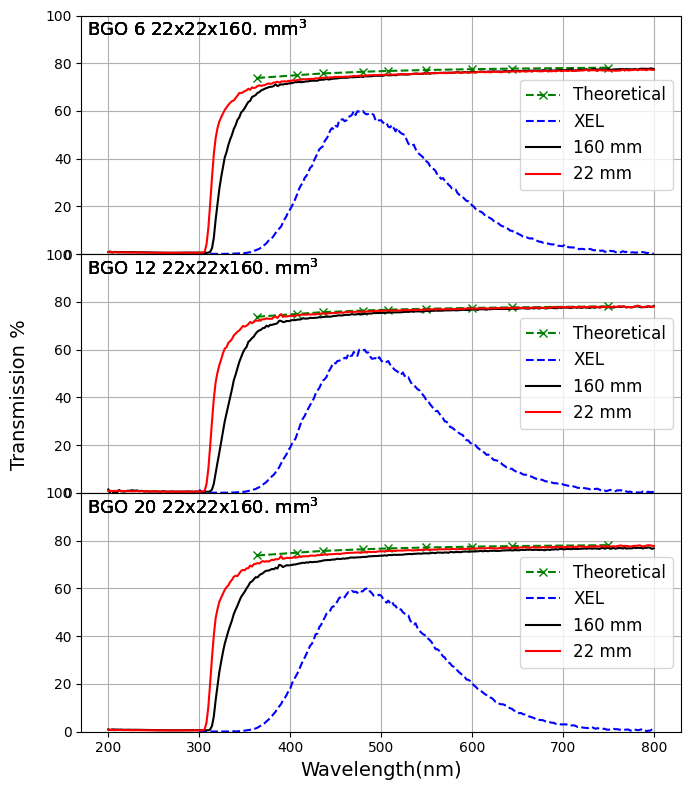

In [8]:
# File paths for the three sets of files (corresponding to BGO 1, 7, and 14)

file_paths = {
    6: {'file1': 'b-bgo-6_xel_1.TXT', 'file2': 'b-bgo-6_xel_1_bg.TXT', 'file3': 'b-bgo-6_xel_1_hp.TXT', 'TL': Tper_L[5], 'TT': Tper_T[5]},
    12: {'file1': 'b-bgo-12_xel_1.TXT', 'file2': 'b-bgo-12_xel_1_bg.TXT', 'file3': 'b-bgo-12_xel_1_hp.TXT', 'TL': Tper_L[11], 'TT': Tper_T[11]},
    20: {'file1': 'b-bgo-20_xel_1.TXT', 'file2': 'b-bgo-20_xel_1_bg.TXT', 'file3': 'b-bgo-20_xel_1_hp.TXT', 'TL': Tper_L[19], 'TT': Tper_T[19]}
    # 1: {'file1': 'b-bgo-1_xel_012925_1.TXT', 'file2': 'b-bgo-1_xel_012925_1_bg.TXT', 'file3': 'b-bgo-1_xel_012925_1_hp.TXT', 'TL': Tper_L[0], 'TT': Tper_T[0]},
    # 7: {'file1': 'b-bgo-7_xel_020425_1.TXT', 'file2': 'b-bgo-7_xel_020425_1_bg.TXT', 'file3': 'b-bgo-7_xel_020425_1_hp.TXT', 'TL': Tper_L[6], 'TT': Tper_T[6]},
    # 14: {'file1': 'b-bgo-14_xel_020425_1.TXT', 'file2': 'b-bgo-14_xel_020425_1_bg.TXT', 'file3': 'b-bgo-14_xel_020425_1_hp.TXT', 'TL': Tper_L[13], 'TT': Tper_T[13]}
}

# Example calibration data
calib = [
    1.0399, 1.0546, 1.0630, 1.0623, 1.0577, 1.0573, 1.0633, 1.0732, 1.0879, 1.1023, 
    1.1138, 1.1315, 1.1398, 1.1311, 1.1217, 1.1093, 1.0838, 1.0598, 1.0468, 1.0376, 
    1.0312, 1.0289, 1.0298, 1.0312, 1.0311, 1.0319, 1.0319, 1.0337, 1.0358, 1.0381, 
    1.0395, 1.0428, 1.0439, 1.0435, 1.0421, 1.0398, 1.0352, 1.0306, 1.0263, 1.0224, 
    1.0196, 1.0176, 1.0161, 1.0160, 1.0151, 1.0138, 1.0115, 1.0074, 1.0017, 0.9955, 
    0.9875, 0.9792, 0.9709, 0.9616, 0.9523, 0.9435, 0.9346, 0.9260, 0.9177, 0.9096, 
    0.9022, 0.8958, 0.8900, 0.8851, 0.8801, 0.8747, 0.8692, 0.8635, 0.8577, 0.8522, 
    0.8466, 0.8394, 0.8314, 0.8263, 0.8292, 0.8277, 0.8279, 0.8221, 0.8179, 0.8162, 
    0.8116, 0.8089, 0.8023, 0.7987, 0.7940, 0.7900, 0.7824, 0.7787, 0.7710, 0.7668, 
    0.7657, 0.7625, 0.7592, 0.7610, 0.7625, 0.7647, 0.7665, 0.7692, 0.7646, 0.7642, 
    0.7591, 0.7568, 0.7491, 0.7449, 0.7366, 0.7313, 0.7244, 0.7216, 0.7110, 0.7057, 
    0.7010, 0.6920, 0.6869, 0.6797, 0.6740, 0.6654, 0.6609, 0.6553, 0.6482, 0.6439, 
    0.6381, 0.6336, 0.6270, 0.6221, 0.6167, 0.6117, 0.6085, 0.6031, 0.5988, 0.5944, 
    0.5874, 0.5828, 0.5770, 0.5717, 0.5657, 0.5609, 0.5552, 0.5500, 0.5462, 0.5408, 
    0.5335, 0.5271, 0.5246, 0.5189, 0.5141, 0.5074, 0.5017, 0.4993, 0.4934, 0.4889, 
    0.4858, 0.4814, 0.4736, 0.4720, 0.4667, 0.4620, 0.4579, 0.4520, 0.4463, 0.4413, 
    0.4368, 0.4326, 0.4282, 0.4220, 0.4175, 0.4103, 0.4045, 0.4012, 0.3962, 0.3904, 
    0.3851, 0.3792, 0.3753, 0.3718, 0.3639, 0.3607, 0.3562, 0.3505, 0.3461, 0.3410, 
    0.3379, 0.3326, 0.3281, 0.3244, 0.3204, 0.3160, 0.3126, 0.3085, 0.3034, 0.3011, 
    0.2969, 0.2932, 0.2892, 0.2848, 0.2812, 0.2782, 0.2748, 0.2715, 0.2695, 0.2673, 
    0.2642, 0.2630, 0.2621, 0.2629, 0.2629, 0.2643, 0.2648, 0.2671, 0.2692, 0.2719, 
    0.2715, 0.2717, 0.2696, 0.2657, 0.2615, 0.2568, 0.2504, 0.2444, 0.2380, 0.2315, 
    0.2272, 0.2215, 0.2171, 0.2117, 0.2071, 0.2024, 0.1989, 0.1942, 0.1915, 0.1870, 
    0.1835, 0.1805, 0.1783, 0.1750, 0.1713, 0.1677, 0.1651, 0.1622, 0.1591, 0.1566, 
    0.1548, 0.1523, 0.1511, 0.1495, 0.1487, 0.1498, 0.1514, 0.1531, 0.1556, 0.1591, 
    0.1633
]
#THEORETICAL DATA
lam_th = [363.9,407.7,435.8,480,508,550,600,644,750]
tran_th = [73.83,75.01,75.73,76.43,76.78,77.17,77.52,77.75,78.15]

# Read and process the data for each set (BGO 1, 7, 14)
data = {}
for key in file_paths:
    wavelengths1, fluorescence1 = read_data(file_paths[key]['file1'])
    wavelengths2, fluorescence2 = read_data(file_paths[key]['file2'])
    wavelengths3, fluorescence3 = read_data(file_paths[key]['file3'])
    Trans_L = file_paths[key]['TL']
    Trans_T = file_paths[key]['TT']
    normalized_fluorescence = process_fluorescence(wavelengths1, fluorescence1, wavelengths2, fluorescence2, wavelengths3, fluorescence3, calib)
    data[key] = {
        'Trans_L' : Trans_L,
        'Trans_T' : Trans_T,
        'lam' : lam,
        'wavelengths': wavelengths1,
        'fluorescence': normalized_fluorescence,
        'label': f'XEL'
    }

# Create a single figure with three connected subplots sharing the x-axis
fig, axes = plt.subplots(3, 1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0})

# Plot data for each set (BGO 1, 7, 14)
ylabels = ['Transmission %', 'Transmission %', 'Transmission %']
for ax, key, ylabel in zip(axes, file_paths, ylabels):
    plot_data(ax, lam_th, tran_th, 'Theoretical', ylabel,'--', 'green', key, 'x')
    plot_data(ax, data[key]['wavelengths'], data[key]['fluorescence'], data[key]['label'], ylabel,'--', 'blue', key, None)
    plot_data(ax, data[key]['lam'], data[key]['Trans_L'], '160 mm', ylabel, '-','black',key, None)
    plot_data(ax, data[key]['lam'], data[key]['Trans_T'], '22 mm', ylabel, '-', 'red', key, None)
# Set x-axis label only for the last subplot
plt.xlabel("Wavelength(nm)", fontsize = 14)
fig.supylabel("Transmission %", fontsize = 14)
plt.tight_layout()
plt.savefig("Trans_XEL_6-12-20" + ".png", format="png")
plt.show()

EWLT

In [15]:
R = sum(data[20]['fluorescence'][i-50] * data[20]['Trans_L'][i] for i in range(50, 301)) / sum(data[20]['fluorescence'][i-50] for i in range(50, 301))

print(R)

73.44035635551523


In [ ]:


print(E)

0.12952119632326972


In [16]:
data[20]['lam'].index(300)

50

Theoretical Attenuation length from chinese paper

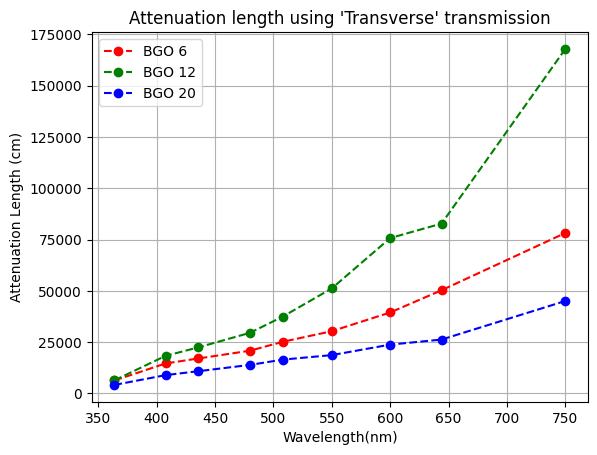

In [59]:
import numpy as np
def LAL(l, T, Ts):
    num=T*((1-Ts)**2)
    den=np.sqrt(4*pow(Ts,4)+ (T**2)*(1-Ts**2)**2) - 2*Ts**2
    ln = np.log(num/den)

    return l/ln

lta = []
Tran6 = []
Tran12 = []
Tran20 = []

AtL6= []
AtL12 =[]
AtL20 = []
for wav in lam_th:
    l= 16
    lta.append(round(wav))
    tr6 = data[6]['Trans_L'][data[6]['lam'].index(round(wav))]
    Tran6.append(tr6)
    tr12 = data[12]['Trans_L'][data[12]['lam'].index(round(wav))]
    Tran12.append(tr12)
    tr20 = data[20]['Trans_L'][data[20]['lam'].index(round(wav))]
    Tran20.append(tr20)
    trth = tran_th[lam_th.index(wav)]
    al6= LAL(l, tr6, trth)
    AtL6.append(al6)
    al12= LAL(l, tr12, trth)
    AtL12.append(al12)
    al20= LAL(l, tr20, trth)
    AtL20.append(al20)
# print(AtL)
# print(Tran)
# print(lta)
plt.Figure
plt.plot(lam_th, AtL6, linestyle= '--', color= 'red', marker = 'o', label = 'BGO 6')
plt.plot(lam_th, AtL12, linestyle= '--', color= 'green', marker = 'o', label = 'BGO 12')
plt.plot(lam_th, AtL20, linestyle= '--', color= 'blue', marker = 'o', label = 'BGO 20')
plt.title('Attenuation length using \'Transverse\' transmission')
# plt.plot(lam_th, Tran1, label = 'Longitudinal Transmittance')
# plt.plot(lam_th, tran_th, label = 'Theoretical Transmittance', marker = 'x', linestyle= '--')
plt.ylabel('Attenuation Length (cm)')
plt.xlabel('Wavelength(nm)')
plt.legend()
plt.grid(True)
plt.savefig("Longitudinal_at_Length" + ".pdf", format="pdf")

In [47]:
print(lam_th)

[363.9, 407.7, 435.8, 480, 508, 550, 600, 644, 750]


In [45]:
pow(2,4)

16

In [2]:
wavelengths1.index(700)

200